# Goal
- Analyze the bias variance tradeoff of the dataset
- We adopt the setting from Cuarana 2009

In [1]:
import os
os.chdir('../')

import sys
sys.path.insert(0, './my_interpret/python')

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import loaddata_utils
import pickle
import copy
from general_utils import vector_in

# interpret.set_show_addr(("127.0.0.1", 7001))

In [3]:
random_state = 1377

## Models

In [152]:
all_record_df = pd.read_csv('./results/112819_bias_var.csv')
all_record_df.tail()

,d_name,model_name,split_idx,n_splits,random_state,fit_time,test_size,bias,variance,error_test_mse,avg_test_auc,avg_test_aupr,avg_test_acc,avg_test_logloss,n_subsamples,subsample_ratio
1525,mimiciii,xgb-d1-o20-cols1,2,5,1377,593.765150,0.15,0.074763,0.000954,0.075716,0.800694,0.365235,0.905770,0.263844,8,0.5
1526,mimiciii,xgb-d1-o20-cols1,3,5,1377,550.908465,0.15,0.073595,0.000941,0.074535,0.814754,0.377408,0.906349,0.258625,8,0.5
1527,mimiciii,xgb-d1-o20-cols1,4,5,1377,655.275638,0.15,0.072814,0.000979,0.073792,0.809570,0.387962,0.906319,0.257967,8,0.5
1528,support2cls2,spline-v2,3,5,1377,4429.648565,0.15,0.139240,0.001060,0.140300,0.816059,0.638052,0.796486,0.438136,8,0.5
1529,support2cls2,spline-v2,4,5,1377,3570.815536,0.15,0.144501,0.001079,0.145580,0.806902,0.610083,0.789074,0.450837,8,0.5


## Check

In [153]:
all_record_df.model_name.unique()

array(['ebm-bf-o50', 'ebm-o50-i50', 'flam', 'ilr', 'lr', 'mlr',
       'rf-n1000', 'spline-v2', 'xgb-d1-o20-cv', 'xgb-d3', 'xgb-d3-o20',
       'ebm-h-bf-o50', 'ebm-h-o50-i50', 'ebm-bf-o50-q', 'ilr-q',
       'ebm-o50-i50-q', 'mlr-q', 'ebm-h-bf-o50-q', 'ebm',
       'ebm-h-o50-i50-q', 'rspline', 'rspline-v2', 'xgb-d1-o20-cols1',
       'xgb-d1-o20-cols0.5', 'xgb-d1-o20-cols0.1',
       'xgb-d1-o20-cols0.00001', 'lr-l1', 'rspline-v2-s', 'spline-b',
       'xgb-l-d1-o20-cols0.5', 'xgb-l-d1-o20-cols1'], dtype=object)

In [154]:
all_record_df.d_name.unique()

array(['bikeshare', 'breast', 'calhousing', 'churn', 'pneumonia', 'heart',
       'onlinenews', 'mimicii', 'mimiciii', 'wine', 'adult', 'credit',
       'compass', 'diabetes2', 'support2cls2', 'support2reg2'],
      dtype=object)

In [253]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 500)
all_record_df.groupby(['d_name', 'model_name']).apply(lambda x: len(x))

d_name        model_name            
adult         ebm-bf-o50-q              5
              ebm-h-bf-o50              5
              ebm-h-bf-o50-q            5
              ebm-h-o50-i50             5
              ebm-h-o50-i50-q           5
              ebm-o50-i50-q             5
              flam                      5
              ilr                       5
              ilr-q                     5
              lr                        5
              lr-l1                     5
              mlr                       5
              mlr-q                     5
              rf-n1000                  5
              rspline                   5
              rspline-v2                5
              rspline-v2-s              5
              spline-v2                 5
              xgb-d1-o20-cols0.00001    5
              xgb-d1-o20-cols0.1        5
              xgb-d1-o20-cols0.5        5
              xgb-d1-o20-cols1          5
              xgb-d1-o20-cv            

## Modify some records

In [156]:
# all_record_df['test_size'] = all_record_df.apply(lambda x: 0.3065004577787168 if x.d_name == 'pneumonia' else 0.33, axis=1)
# all_record_df.head(20)

In [157]:
# all_record_df.to_csv('./results/082819_bias_var.csv', index=None)

## Performance

### Table

- Run xgb-l-d1-o20-cols0.5 for churn, compass, support2cls2
- Run xgb-d1-o20-cols0.5 for diabetes2, mimiciii, pneumonia, support2cls2

In [ ]:
# for metric in all_tables:
#     all_tables[metric].to_csv('notebooks/figures/real_%s.csv' % metric)

# for metric in all_tables:
#     all_tables[metric].to_csv('notebooks/figures/final_real_%s.csv' % metric)
#     all_tables[metric].to_csv('notebooks/figures/final_real_%s_std.csv' % metric)

In [286]:
from vis_utils import rank, normalized_score, add_new_row, highlight_min_max, cal_statistics
from general_utils import vector_in

cls_record_df = all_record_df[~vector_in(all_record_df.d_name, ['calhousing', 'bikeshare', 'onlinenews', 'wine', 'support2reg2', 'diabetes2'])]
cls_record_df = cls_record_df[vector_in(cls_record_df.model_name, [
    'ebm-o50-i50-q', 'ebm-bf-o50-q',
#     'xgb-d1-o20-cv', 
#     'xgb-l-d1-o20-cols0.5',
#     'xgb-d1-o20-cols0.5', 
    'xgb-d1-o20-cols0.00001',
#     'xgb-l-d1-o20-cols1',
    'xgb-d1-o20-cols1',
    'flam',
    'spline-v2',
    'lr', 'mlr-q', 'ilr-q', 
#     'rf-n1000', 'xgb-d3', 'xgb-d3-o20',
    
#     'skgbt-d1-o20-cv', 'skgbt-d3-cv',
#     'spline-v2',
#     'xgb-d1-o20-cols0.00001', 'xgb-d1-o20-cols0.1', 'xgb-d1-o20-cols0.5', 'xgb-d1-o20-cols1',
#     'lr', 'lr-l1',
])]


# cls_record_df = cls_record_df[cls_record_df.d_name != 'diabetes']

# for metric in ['test_auc', 'test_mse', 'test_aupr', 'test_logloss', 'test_acc']:
for metric in ['avg_test_auc', 'error_test_mse', 'avg_test_aupr', 'avg_test_logloss', 'avg_test_acc']:

# for metric in ['test_auc', 'test_mse', 'test_aupr', 'test_logloss', 'test_acc', 'train_auc', 'train_aupr', 'train_logloss', 'train_acc']:
    print(metric)
    the_format = '%.5f +- %.5f' if 'mse' not in metric else '%.5f +- %.5f'
    tmp = cls_record_df.groupby(['d_name', 'model_name'], as_index=False)[metric].agg(['mean', 'std']).apply(lambda x: the_format % (x['mean'], x['std']), axis=1)
#     tmp = cls_record_df.groupby(['d_name', 'model_name'], as_index=False)[metric].agg(['mean', 'std']).apply(lambda x: '%.5f' % (x['mean']), axis=1)

    results = []
    for d_name in tmp.index.levels[0]:
        tmp_df = pd.DataFrame(tmp[d_name]).T
        tmp_df.index = [d_name]
        results.append(tmp_df)
    table = pd.concat(results, axis=0, sort=False)
    
    ### Copy the performance from the one-hot
#     table['xgb-l-d1-o20-cols1'] = table.apply(lambda row: row['xgb-d1-o20-cols1'] if pd.isna(row['xgb-l-d1-o20-cols1']) else row['xgb-l-d1-o20-cols1'], axis=1)
    
    is_metric_higher_better = (metric in ['avg_test_auc', 'avg_test_aupr', 'avg_test_acc'])
    new_table = cal_statistics(table, is_metric_higher_better)

    display(new_table.style.apply(highlight_min_max, axis=1))


avg_test_auc


model_name,ebm-bf-o50-q,ebm-o50-i50-q,flam,ilr-q,lr,mlr-q,spline-v2,xgb-d1-o20-cols0.00001,xgb-d1-o20-cols1
adult,0.92687 +- 0.00585,0.92745 +- 0.00551,0.92034 +- 0.00524,0.92048 +- 0.00603,0.90702 +- 0.00648,0.92182 +- 0.00387,0.91652 +- 0.00689,0.91568 +- 0.00615,0.92481 +- 0.00574
breast,0.99327 +- 0.00760,0.99513 +- 0.00631,0.99496 +- 0.00604,0.97588 +- 0.01054,0.99515 +- 0.00501,0.97604 +- 0.01164,0.98103 +- 0.00812,0.99515 +- 0.00592,0.99544 +- 0.00510
churn,0.84092 +- 0.00847,0.84170 +- 0.00714,0.83976 +- 0.00674,0.83220 +- 0.00553,0.84078 +- 0.00639,0.80997 +- 0.00852,0.84182 +- 0.00746,0.84025 +- 0.00680,0.84115 +- 0.00772
compass,0.74237 +- 0.01686,0.74004 +- 0.01388,0.73910 +- 0.01585,0.72644 +- 0.01244,0.72589 +- 0.00963,0.70652 +- 0.01137,0.74133 +- 0.01549,0.74064 +- 0.01376,0.74194 +- 0.01564
credit,0.97262 +- 0.01102,0.97411 +- 0.00787,0.96320 +- 0.00597,0.94741 +- 0.00772,0.96144 +- 0.01242,0.93970 +- 0.01065,0.97832 +- 0.00536,0.97643 +- 0.00532,0.97435 +- 0.00456
heart,0.83697 +- 0.06586,0.84956 +- 0.06623,0.84412 +- 0.06486,0.85441 +- 0.06165,0.86328 +- 0.06314,0.69677 +- 0.02667,0.86263 +- 0.06652,0.85302 +- 0.06577,0.84259 +- 0.06133
mimicii,0.83060 +- 0.00875,0.83072 +- 0.00869,0.82944 +- 0.00924,0.79912 +- 0.00951,0.79223 +- 0.00768,0.79581 +- 0.00954,0.82515 +- 0.00828,0.83008 +- 0.00902,0.83059 +- 0.00964
mimiciii,0.80256 +- 0.00644,0.80555 +- 0.00476,0.80426 +- 0.00579,0.74322 +- 0.01102,0.78382 +- 0.00540,0.74500 +- 0.00495,0.80849 +- 0.00531,0.80780 +- 0.00551,0.80659 +- 0.00557
pneumonia,0.84653 +- 0.00877,0.84956 +- 0.00624,0.84602 +- 0.00919,0.83606 +- 0.00854,0.83410 +- 0.00567,0.82522 +- 0.00446,0.84703 +- 0.00492,0.84582 +- 0.00490,0.84489 +- 0.00676
support2cls2,0.80842 +- 0.00948,0.80684 +- 0.00983,0.80568 +- 0.00977,0.79144 +- 0.00963,0.80124 +- 0.00603,0.73474 +- 0.00873,0.80779 +- 0.00867,0.80766 +- 0.01012,0.80796 +- 0.01070


error_test_mse


model_name,ebm-bf-o50-q,ebm-o50-i50-q,flam,ilr-q,lr,mlr-q,spline-v2,xgb-d1-o20-cols0.00001,xgb-d1-o20-cols1
adult,0.08921 +- 0.00299,0.08878 +- 0.00294,0.09374 +- 0.00256,0.09264 +- 0.00328,0.10154 +- 0.00322,0.09231 +- 0.00250,0.09504 +- 0.00381,0.09652 +- 0.00299,0.09043 +- 0.00310
breast,0.02761 +- 0.01390,0.02544 +- 0.01701,0.02460 +- 0.01288,0.23351 +- 0.00000,0.02431 +- 0.01107,0.15398 +- 0.00303,0.05755 +- 0.00815,0.02182 +- 0.00972,0.02193 +- 0.01094
churn,0.13701 +- 0.00350,0.13651 +- 0.00344,0.13724 +- 0.00320,0.14087 +- 0.00252,0.13710 +- 0.00247,0.15241 +- 0.00401,0.13660 +- 0.00331,0.13706 +- 0.00325,0.13675 +- 0.00331
compass,0.20422 +- 0.00534,0.20499 +- 0.00448,0.20570 +- 0.00513,0.21034 +- 0.00426,0.21134 +- 0.00303,0.21905 +- 0.00439,0.20452 +- 0.00536,0.20482 +- 0.00433,0.20424 +- 0.00531
credit,0.00053 +- 0.00007,0.00053 +- 0.00006,0.00049 +- 0.00005,0.00058 +- 0.00006,0.00078 +- 0.00005,0.00081 +- 0.00009,0.00048 +- 0.00004,0.00051 +- 0.00005,0.00048 +- 0.00005
heart,0.17086 +- 0.02818,0.16032 +- 0.03309,0.16519 +- 0.03249,0.16779 +- 0.02569,0.15840 +- 0.02987,0.26606 +- 0.01832,0.15879 +- 0.02858,0.15515 +- 0.03758,0.16451 +- 0.03871
mimicii,0.08682 +- 0.00118,0.08677 +- 0.00143,0.08690 +- 0.00136,0.09172 +- 0.00139,0.09004 +- 0.00075,0.09658 +- 0.00209,0.08681 +- 0.00125,0.08682 +- 0.00145,0.08710 +- 0.00150
mimiciii,0.07517 +- 0.00078,0.07507 +- 0.00072,0.07488 +- 0.00105,0.08595 +- 0.00078,0.07666 +- 0.00058,0.08754 +- 0.00080,0.07483 +- 0.00050,0.07467 +- 0.00086,0.07500 +- 0.00081
pneumonia,0.07542 +- 0.00109,0.07586 +- 0.00109,0.07611 +- 0.00153,0.07890 +- 0.00120,0.07907 +- 0.00069,0.08489 +- 0.00097,0.07501 +- 0.00067,0.07661 +- 0.00106,0.07613 +- 0.00118
support2cls2,0.14543 +- 0.00197,0.14562 +- 0.00210,0.14607 +- 0.00226,0.15170 +- 0.00187,0.14716 +- 0.00198,0.18223 +- 0.00493,0.14510 +- 0.00317,0.14494 +- 0.00237,0.14521 +- 0.00303


avg_test_aupr


model_name,ebm-bf-o50-q,ebm-o50-i50-q,flam,ilr-q,lr,mlr-q,spline-v2,xgb-d1-o20-cols0.00001,xgb-d1-o20-cols1
adult,0.82577 +- 0.01119,0.82712 +- 0.00988,0.80997 +- 0.01088,0.81568 +- 0.01080,0.76885 +- 0.01308,0.81732 +- 0.00893,0.80090 +- 0.01387,0.79711 +- 0.01296,0.82040 +- 0.01150
breast,0.99575 +- 0.00505,0.99671 +- 0.00449,0.99673 +- 0.00412,0.98094 +- 0.01228,0.99691 +- 0.00331,0.97989 +- 0.01593,0.98664 +- 0.00845,0.99687 +- 0.00388,0.99714 +- 0.00332
churn,0.64325 +- 0.02532,0.64757 +- 0.02593,0.64620 +- 0.02339,0.62874 +- 0.02130,0.64758 +- 0.02186,0.59175 +- 0.01845,0.65054 +- 0.02129,0.64580 +- 0.02549,0.64608 +- 0.02390
compass,0.71096 +- 0.01943,0.70608 +- 0.01628,0.70470 +- 0.01472,0.68303 +- 0.01337,0.68696 +- 0.01109,0.65819 +- 0.01635,0.70734 +- 0.01606,0.70789 +- 0.01682,0.70888 +- 0.01846
credit,0.79097 +- 0.04129,0.80205 +- 0.03779,0.81711 +- 0.02133,0.78281 +- 0.03780,0.72498 +- 0.02582,0.68538 +- 0.05518,0.82480 +- 0.02410,0.82220 +- 0.02784,0.82873 +- 0.02603
heart,0.81017 +- 0.08365,0.82073 +- 0.08007,0.81910 +- 0.08522,0.82752 +- 0.08108,0.84626 +- 0.08436,0.66882 +- 0.03841,0.83391 +- 0.08565,0.82989 +- 0.07989,0.81534 +- 0.07459
mimicii,0.42923 +- 0.01679,0.43130 +- 0.01861,0.42954 +- 0.01747,0.37150 +- 0.01970,0.39614 +- 0.00791,0.36762 +- 0.01444,0.43185 +- 0.01337,0.43133 +- 0.01832,0.42766 +- 0.01888
mimiciii,0.36940 +- 0.01289,0.36823 +- 0.01209,0.37071 +- 0.01693,0.26317 +- 0.02149,0.34576 +- 0.00699,0.28267 +- 0.00803,0.37103 +- 0.00641,0.37504 +- 0.01308,0.37099 +- 0.01142
pneumonia,0.46001 +- 0.01350,0.45188 +- 0.00953,0.44224 +- 0.01554,0.41186 +- 0.01532,0.40963 +- 0.00358,0.38882 +- 0.00853,0.46226 +- 0.00446,0.43720 +- 0.00803,0.44200 +- 0.01145
support2cls2,0.60872 +- 0.00801,0.60661 +- 0.01074,0.60562 +- 0.00902,0.57131 +- 0.00808,0.59825 +- 0.01459,0.48731 +- 0.01597,0.60882 +- 0.01808,0.61000 +- 0.01217,0.61085 +- 0.01522


avg_test_logloss


model_name,ebm-bf-o50-q,ebm-o50-i50-q,flam,ilr-q,lr,mlr-q,spline-v2,xgb-d1-o20-cols0.00001,xgb-d1-o20-cols1
adult,0.28187 +- 0.00908,0.27990 +- 0.00923,0.29692 +- 0.00699,0.29438 +- 0.01140,0.31993 +- 0.01014,0.29027 +- 0.00772,0.30754 +- 0.01153,0.30489 +- 0.00815,0.28546 +- 0.00946
breast,0.10158 +- 0.04608,0.16038 +- 0.16187,0.09840 +- 0.05505,0.65979 +- 0.00000,0.10518 +- 0.03231,0.48686 +- 0.00589,0.22119 +- 0.02242,0.08261 +- 0.03604,0.07891 +- 0.03697
churn,0.42226 +- 0.00790,0.42099 +- 0.00792,0.42318 +- 0.00663,0.43201 +- 0.00490,0.42417 +- 0.00919,0.47193 +- 0.01475,0.42224 +- 0.00986,0.42205 +- 0.00702,0.42313 +- 0.01021
compass,0.59548 +- 0.01216,0.59724 +- 0.01026,0.59918 +- 0.01187,0.61036 +- 0.01068,0.61432 +- 0.00863,0.63700 +- 0.01253,0.59842 +- 0.01431,0.59704 +- 0.00986,0.59588 +- 0.01237
credit,0.00319 +- 0.00036,0.00322 +- 0.00041,0.00314 +- 0.00027,0.00656 +- 0.00085,0.00474 +- 0.00055,0.00486 +- 0.00069,0.00299 +- 0.00026,0.00323 +- 0.00037,0.00323 +- 0.00037
heart,0.52020 +- 0.06822,0.49615 +- 0.08919,0.51327 +- 0.08861,0.51285 +- 0.06287,0.49719 +- 0.07916,0.92495 +- 0.07944,0.49290 +- 0.06536,0.48834 +- 0.11283,0.52039 +- 0.12851
mimicii,0.29007 +- 0.00409,0.28957 +- 0.00462,0.28993 +- 0.00471,0.30676 +- 0.00482,0.30646 +- 0.00301,0.32479 +- 0.00752,0.29118 +- 0.00408,0.28955 +- 0.00484,0.28986 +- 0.00520
mimiciii,0.26329 +- 0.00269,0.26165 +- 0.00237,0.26133 +- 0.00320,0.30771 +- 0.00391,0.26943 +- 0.00217,0.32905 +- 0.00402,0.26036 +- 0.00214,0.26008 +- 0.00282,0.26120 +- 0.00270
pneumonia,0.25932 +- 0.00383,0.25830 +- 0.00325,0.25962 +- 0.00494,0.26815 +- 0.00403,0.26780 +- 0.00189,0.29111 +- 0.00274,0.25909 +- 0.00472,0.26007 +- 0.00297,0.25913 +- 0.00390
support2cls2,0.44986 +- 0.00626,0.45003 +- 0.00702,0.45199 +- 0.00705,0.46533 +- 0.00638,0.45623 +- 0.00556,0.58252 +- 0.01905,0.45141 +- 0.00964,0.44872 +- 0.00771,0.44997 +- 0.00932


avg_test_acc


model_name,ebm-bf-o50-q,ebm-o50-i50-q,flam,ilr-q,lr,mlr-q,spline-v2,xgb-d1-o20-cols0.00001,xgb-d1-o20-cols1
adult,0.87074 +- 0.00582,0.87202 +- 0.00399,0.86387 +- 0.00556,0.86676 +- 0.00427,0.85273 +- 0.00605,0.86537 +- 0.00463,0.86222 +- 0.00624,0.86114 +- 0.00645,0.86921 +- 0.00567
breast,0.96483 +- 0.01662,0.96890 +- 0.01749,0.96919 +- 0.01574,0.62791 +- 0.00000,0.97238 +- 0.01853,0.77791 +- 0.02867,0.93256 +- 0.01776,0.97209 +- 0.01298,0.97122 +- 0.01491
churn,0.79588 +- 0.01408,0.79607 +- 0.01561,0.79636 +- 0.01272,0.78798 +- 0.01176,0.80073 +- 0.01033,0.77874 +- 0.00800,0.79818 +- 0.01504,0.79536 +- 0.01380,0.79671 +- 0.01289
compass,0.68545 +- 0.01271,0.68202 +- 0.01128,0.68202 +- 0.01041,0.67241 +- 0.00820,0.67433 +- 0.00486,0.66037 +- 0.00698,0.68664 +- 0.00951,0.68213 +- 0.01136,0.68639 +- 0.01170
credit,0.99939 +- 0.00010,0.99939 +- 0.00007,0.99945 +- 0.00007,0.99938 +- 0.00007,0.99908 +- 0.00007,0.99904 +- 0.00011,0.99946 +- 0.00005,0.99941 +- 0.00006,0.99946 +- 0.00006
heart,0.74964 +- 0.05782,0.77609 +- 0.05554,0.76087 +- 0.05531,0.76957 +- 0.05533,0.78551 +- 0.06467,0.63478 +- 0.03613,0.78188 +- 0.06254,0.78225 +- 0.05718,0.76957 +- 0.04521
mimicii,0.88506 +- 0.00154,0.88477 +- 0.00206,0.88482 +- 0.00183,0.87930 +- 0.00185,0.88427 +- 0.00189,0.87411 +- 0.00255,0.88532 +- 0.00211,0.88507 +- 0.00187,0.88443 +- 0.00190
mimiciii,0.90564 +- 0.00076,0.90585 +- 0.00103,0.90646 +- 0.00098,0.90131 +- 0.00069,0.90388 +- 0.00117,0.89330 +- 0.00096,0.90595 +- 0.00034,0.90628 +- 0.00060,0.90627 +- 0.00032
pneumonia,0.90148 +- 0.00153,0.90005 +- 0.00085,0.89969 +- 0.00168,0.89616 +- 0.00186,0.89661 +- 0.00057,0.89063 +- 0.00121,0.90237 +- 0.00082,0.89954 +- 0.00082,0.90002 +- 0.00100
support2cls2,0.78662 +- 0.00370,0.78693 +- 0.00260,0.78840 +- 0.00115,0.77522 +- 0.00187,0.78629 +- 0.00372,0.74833 +- 0.00490,0.78812 +- 0.00510,0.78790 +- 0.00387,0.79056 +- 0.00402


### The summarized rank and NS for bias and variance

In [287]:
cls_record_df.head()

,d_name,model_name,split_idx,n_splits,random_state,fit_time,test_size,bias,variance,error_test_mse,avg_test_auc,avg_test_aupr,avg_test_acc,avg_test_logloss,n_subsamples,subsample_ratio
57,breast,flam,0,5,1377,314.967950,0.15,0.009963,0.004772,0.014735,0.999638,0.999791,0.982558,0.062182,8,0.5
59,breast,lr,0,5,1377,2.243470,0.15,0.009171,0.006364,0.015534,0.996817,0.997935,0.986919,0.071462,8,0.5
62,breast,spline-v2,0,5,1377,29122.399617,0.15,0.058178,0.003663,0.061841,0.983507,0.990977,0.918605,0.230170,8,0.5
68,breast,flam,1,5,1377,312.104530,0.15,0.019732,0.005635,0.025366,0.994502,0.996542,0.969477,0.098102,8,0.5
70,breast,lr,1,5,1377,2.307035,0.15,0.018201,0.005479,0.023680,0.995804,0.997438,0.973837,0.105597,8,0.5


In [288]:
def get_2d_table(record_dfs, row_name='d_name', col_name='model_name', value='bias'):
    '''
    Aggregate the value based on row and col name and take average value. Then organize them into a 2d table.
    '''
    tmp = record_dfs.groupby([row_name, col_name], as_index=False)[value].agg(['mean'])['mean']
    
    results = []
    for d_name in tmp.index.levels[0]:
        tmp_df = pd.DataFrame(tmp[d_name]).T
        tmp_df.index = [d_name]
        results.append(tmp_df)
    table = pd.concat(results, axis=0, sort=False)
    return table

In [289]:
from vis_utils import cal_statistics

# Since spline-v2 can not do bias/variance analysis on it. Remove the diabetes dataset
tmp = cls_record_df[~vector_in(cls_record_df.d_name, ['diabetes'])]

bias_table = get_2d_table(tmp, row_name='d_name', col_name='model_name', value='bias')
var_table = get_2d_table(tmp, row_name='d_name', col_name='model_name', value='variance')
error_table = get_2d_table(tmp, row_name='d_name', col_name='model_name', value='error_test_mse')

# bias_table['xgb-l-d1-o20-cols1'] = bias_table.apply(lambda row: row['xgb-d1-o20-cols1'] if pd.isna(row['xgb-l-d1-o20-cols1']) else row['xgb-l-d1-o20-cols1'], axis=1)
# var_table['xgb-l-d1-o20-cols1'] = var_table.apply(lambda row: row['xgb-d1-o20-cols1'] if pd.isna(row['xgb-l-d1-o20-cols1']) else row['xgb-l-d1-o20-cols1'], axis=1)
# error_table['xgb-l-d1-o20-cols1'] = error_table.apply(lambda row: row['xgb-d1-o20-cols1'] if pd.isna(row['xgb-l-d1-o20-cols1']) else row['xgb-l-d1-o20-cols1'], axis=1)

display(cal_statistics(bias_table, is_metric_higher_better=False).style.apply(highlight_min_max, axis=1))

model_name,ebm-bf-o50-q,ebm-o50-i50-q,flam,ilr-q,lr,mlr-q,spline-v2,xgb-d1-o20-cols0.00001,xgb-d1-o20-cols1
adult,0.0887038,0.0876806,0.0921623,0.088758,0.100909,0.0909692,0.0934358,0.096211,0.0898226
breast,0.0247295,0.0206916,0.0189276,0.233512,0.0197186,0.153199,0.0539549,0.0202911,0.0194111
churn,0.136188,0.135777,0.135689,0.139434,0.136378,0.14443,0.135701,0.13645,0.135565
compass,0.203322,0.204057,0.203956,0.207678,0.210948,0.211677,0.203754,0.203913,0.203184
credit,0.000521753,0.000510831,0.000472048,0.000552826,0.000765709,0.000751117,0.00046031,0.000500735,0.000466781
heart,0.16642,0.15584,0.157051,0.161129,0.150194,0.210879,0.158155,0.148817,0.154215
mimicii,0.086266,0.0861796,0.0861394,0.0901798,0.0899052,0.0908629,0.0864784,0.0862695,0.0864044
mimiciii,0.074589,0.0744943,0.0739738,0.0830798,0.0763343,0.0803873,0.0740736,0.0739511,0.0740371
pneumonia,0.0747263,0.0751931,0.0749029,0.0779743,0.0783584,0.0782447,0.0739854,0.0759998,0.0750745
support2cls2,0.144443,0.144289,0.144076,0.14879,0.146226,0.163228,0.143976,0.14362,0.143409


In [290]:
bias_rank = bias_table.apply(rank, is_metric_higher_better=False, axis=1).sort_index()
bias_rank = cal_statistics(bias_rank, is_metric_higher_better=False)
display(bias_rank.style.apply(highlight_min_max, axis=1))

model_name,ebm-bf-o50-q,ebm-o50-i50-q,flam,ilr-q,lr,mlr-q,spline-v2,xgb-d1-o20-cols0.00001,xgb-d1-o20-cols1
adult,2,1,6,3,9,5,7,8,4
breast,6,5,1,9,3,8,7,4,2
churn,5,4,2,8,6,9,3,7,1
compass,2,6,5,7,8,9,3,4,1
credit,6,5,3,7,9,8,1,4,2
heart,8,4,5,7,2,9,6,1,3
mimicii,3,2,1,8,7,9,6,4,5
mimiciii,6,5,2,9,7,8,4,1,3
pneumonia,2,5,3,7,9,8,1,6,4
support2cls2,6,5,4,8,7,9,3,2,1


In [291]:
display(cal_statistics(var_table, is_metric_higher_better=True).style.apply(highlight_min_max, axis=1))

model_name,ebm-bf-o50-q,ebm-o50-i50-q,flam,ilr-q,lr,mlr-q,spline-v2,xgb-d1-o20-cols0.00001,xgb-d1-o20-cols1
adult,0.000503672,0.00110171,0.00157342,0.00388632,0.000632242,0.00134496,0.00160727,0.000311012,0.000612291
breast,0.00287779,0.00475066,0.00567514,1.69953e-09,0.00459166,0.000776598,0.00359585,0.00153386,0.00251911
churn,0.000819757,0.000733141,0.00154975,0.00143101,0.000719563,0.00797943,0.000903813,0.000612116,0.00118341
compass,0.000895563,0.000928894,0.00174442,0.00266277,0.000392833,0.00737045,0.000768719,0.000910648,0.00105664
credit,1.01661e-05,1.50858e-05,1.70816e-05,2.79801e-05,1.333e-05,5.87667e-05,2.10269e-05,1.3051e-05,1.4361e-05
heart,0.00444471,0.00448518,0.00813715,0.00665831,0.00820687,0.055182,0.000633934,0.00633282,0.0102953
mimicii,0.000553154,0.000594112,0.000755652,0.00154162,0.000134715,0.00571959,0.000328697,0.000549023,0.000691659
mimiciii,0.000577233,0.000575299,0.000906281,0.00286838,0.00033038,0.00714798,0.000752658,0.000720314,0.000958685
pneumonia,0.000693632,0.000666039,0.00120651,0.000924062,0.000715958,0.00664091,0.0010255,0.000606794,0.00105716
support2cls2,0.000992061,0.00132782,0.00199422,0.00291101,0.000931486,0.0190019,0.0011282,0.00131621,0.0017967


In [292]:
var_rank = var_table.apply(rank, is_metric_higher_better=False, axis=1).sort_index()
var_rank = cal_statistics(var_rank, is_metric_higher_better=False)
display(var_rank.style.apply(highlight_min_max, axis=1))

model_name,ebm-bf-o50-q,ebm-o50-i50-q,flam,ilr-q,lr,mlr-q,spline-v2,xgb-d1-o20-cols0.00001,xgb-d1-o20-cols1
adult,2,5,7,9,4,6,8,1,3
breast,5,8,9,1,7,2,6,3,4
churn,4,3,8,7,2,9,5,1,6
compass,3,5,7,8,1,9,2,4,6
credit,1,5,6,8,3,9,7,2,4
heart,2,3,6,5,7,9,1,4,8
mimicii,4,5,7,8,1,9,2,3,6
mimiciii,3,2,6,8,1,9,5,4,7
pneumonia,3,2,8,5,4,9,6,1,7
support2cls2,2,5,7,8,1,9,3,4,6


In [293]:
error_rank = error_table.apply(rank, is_metric_higher_better=False, axis=1).sort_index()
error_rank = cal_statistics(error_rank, is_metric_higher_better=False)
display(error_rank.style.apply(highlight_min_max, axis=1))

model_name,ebm-bf-o50-q,ebm-o50-i50-q,flam,ilr-q,lr,mlr-q,spline-v2,xgb-d1-o20-cols0.00001,xgb-d1-o20-cols1
adult,2,1,6,5,9,4,7,8,3
breast,6,5,4,9,3,8,7,1,2
churn,4,1,7,8,6,9,2,5,3
compass,1,5,6,7,8,9,3,4,2
credit,6,5,3,7,8,9,2,4,1
heart,8,4,6,7,2,9,3,1,5
mimicii,4,1,5,8,7,9,2,3,6
mimiciii,6,5,3,8,7,9,2,1,4
pneumonia,2,3,4,7,8,9,1,6,5
support2cls2,4,5,6,8,7,9,2,1,3


In [294]:
bias_ns = bias_table.apply(normalized_score, is_metric_higher_better=True, axis=1).sort_index()
bias_ns = cal_statistics(bias_ns, is_metric_higher_better=False)
display(bias_ns.style.apply(highlight_min_max, axis=1))

model_name,ebm-bf-o50-q,ebm-o50-i50-q,flam,ilr-q,lr,mlr-q,spline-v2,xgb-d1-o20-cols0.00001,xgb-d1-o20-cols1
adult,0.0773473,0,0.338791,0.0814476,1,0.248602,0.435058,0.644843,0.161925
breast,0.0270378,0.00822088,0,1,0.0036862,0.62573,0.163233,0.00635415,0.00225314
churn,0.0702626,0.0239847,0.0140375,0.436499,0.0917371,1,0.015343,0.0998576,0
compass,0.0162568,0.102802,0.0908768,0.529219,0.914191,1,0.0670867,0.0857828,0
credit,0.201191,0.165426,0.0384374,0.302934,1,0.952221,0,0.132369,0.0211908
heart,0.283629,0.113152,0.132663,0.198384,0.0221897,1,0.150458,0,0.0869697
mimicii,0.0268046,0.00849859,0,0.855383,0.79723,1,0.0717579,0.0275479,0.0561095
mimiciii,0.0698859,0.0595132,0.00248668,1,0.261071,0.705052,0.013427,0,0.00942536
pneumonia,0.16942,0.27617,0.209816,0.912181,1,0.974008,0,0.460645,0.249056
support2cls2,0.0521423,0.0444185,0.0336359,0.271514,0.142116,1,0.0286154,0.01064,0


In [295]:
var_ns = var_table.apply(normalized_score, is_metric_higher_better=True, axis=1).sort_index()
var_ns = cal_statistics(var_ns, is_metric_higher_better=True)
display(var_ns.style.apply(highlight_min_max, axis=1))

model_name,ebm-bf-o50-q,ebm-o50-i50-q,flam,ilr-q,lr,mlr-q,spline-v2,xgb-d1-o20-cols0.00001,xgb-d1-o20-cols1
adult,0.0538863,0.221156,0.353091,1,0.0898468,0.289192,0.362559,0,0.0842666
breast,0.507086,0.837099,1,0,0.809082,0.136842,0.633614,0.270276,0.443885
churn,0.0281841,0.0164272,0.12727,0.111153,0.0145843,1,0.0395935,0,0.0775439
compass,0.0720489,0.0768259,0.193704,0.325316,0,1,0.0538703,0.0742108,0.0951332
credit,0,0.101228,0.142292,0.366539,0.0651007,1,0.223471,0.0593599,0.0863135
heart,0.0698608,0.0706028,0.137552,0.110442,0.13883,1,0,0.104475,0.177116
mimicii,0.0749236,0.0822574,0.111182,0.251912,0,1,0.0347334,0.0741839,0.0997236
mimiciii,0.0362083,0.0359245,0.0844727,0.372272,0,1,0.0619395,0.0571953,0.0921593
pneumonia,0.0143913,0.00981843,0.0993885,0.0525791,0.0180911,1,0.0693902,0,0.0746365
support2cls2,0.00335214,0.0219326,0.0588105,0.109545,0,1,0.0108861,0.0212902,0.0478801


In [296]:
error_ns = error_table.apply(normalized_score, is_metric_higher_better=True, axis=1).sort_index()
error_ns = cal_statistics(error_ns, is_metric_higher_better=True)
display(error_ns.style.apply(highlight_min_max, axis=1))

model_name,ebm-bf-o50-q,ebm-o50-i50-q,flam,ilr-q,lr,mlr-q,spline-v2,xgb-d1-o20-cols0.00001,xgb-d1-o20-cols1
adult,0.0333222,0,0.388227,0.302687,1,0.276814,0.490689,0.606599,0.129525
breast,0.0273154,0.0170883,0.0131221,1,0.0117405,0.624276,0.168767,0,0.000497167
churn,0.0312525,0,0.0458165,0.273912,0.0369247,1,0.00591631,0.0346945,0.0149468
compass,0,0.0518103,0.0999758,0.412933,0.480327,1,0.0205557,0.0408334,0.00155195
credit,0.154459,0.136199,0.0242977,0.303166,0.906173,1,0.000590948,0.0992995,0
heart,0.141684,0.046657,0.0905017,0.113943,0.0293135,1,0.0328079,0,0.0843915
mimicii,0.00463976,0,0.0123761,0.50442,0.332984,1,0.00340422,0.0045765,0.0328721
mimiciii,0.0384711,0.0309598,0.0162211,0.876623,0.154954,1,0.0120427,0,0.0252189
pneumonia,0.0414186,0.0858977,0.111247,0.393681,0.411497,1,0,0.161592,0.113499
support2cls2,0.0133634,0.018262,0.0304009,0.181398,0.0595535,1,0.0045113,0,0.00722973


No handles with labels found to put in legend.


Text(0, 0.5, 'Variance Normalized Score')

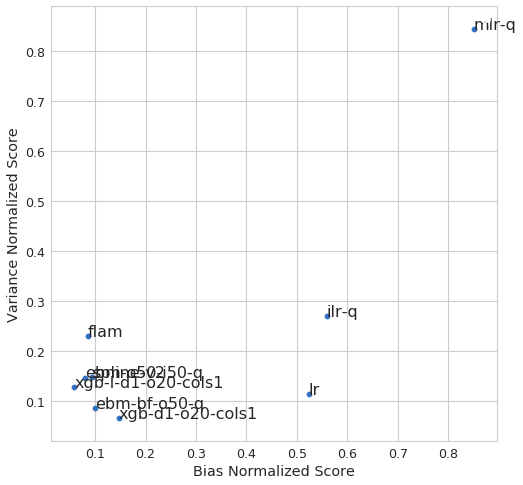

In [297]:
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(8, 8))
x, y, model_names = bias_ns.loc['average'], var_ns.loc['average'], x.index
colors = cm.rainbow(np.linspace(0, 1, len(x)))

ax.scatter(x, y)
# for x1, y1, c, model_name in zip(x, y, colors, model_names):
#     plt.scatter(x1, y1, color=c, label=model_name)

for i, txt in enumerate(model_names):
    ax.annotate(txt, (x[i], y[i]), size=16)

plt.legend()
plt.xlabel('Bias Normalized Score')
plt.ylabel('Variance Normalized Score')

In [298]:
model_name_dict = {
    'xgb-l-d1-o20-cols1': 'XGB-LE',
    'xgb-d1-o20-cols1': 'XGB',
    'xgb-d1-o20-cols0.00001': 'XGB-L2',
    'spline-v2': 'Spline',
    'ebm-o50-i50-q': 'EBM',
    'ebm-bf-o50-q': 'EBM-BF',
    'flam': 'FLAM',
    'ilr-q': 'iLR',
    'lr': 'LR',
    'mlr-q': 'mLR',
}

In [299]:
import seaborn as sns
sns.set_style('whitegrid')

No handles with labels found to put in legend.


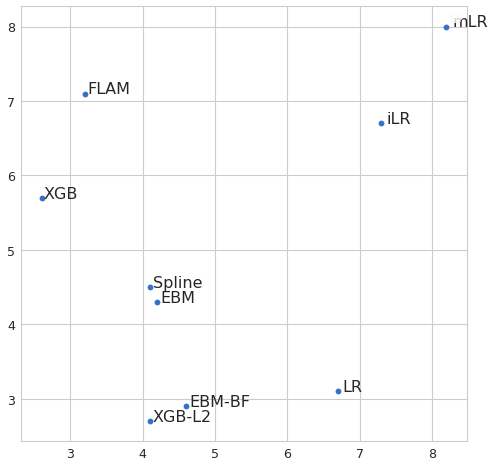

In [300]:
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(8, 8))
x, y, model_names = bias_rank.loc['average'], var_rank.loc['average'], x.index
colors = cm.rainbow(np.linspace(0, 1, len(x)))

ax.scatter(x, y)

for i, txt in enumerate(model_names):
    if txt in model_name_dict:
        txt = model_name_dict[txt]
    ax.annotate(txt, (x[i] + 0.01 * x[i], y[i]), size=16)

plt.legend()
# plt.xlabel('Bias Rank')
# plt.ylabel('Variance Rank')

In [301]:
fig.savefig('notebooks/figures/bias_var_rank.pdf', bbox_inches='tight', dpi=300)

No handles with labels found to put in legend.


Text(0, 0.5, 'Variance NS')

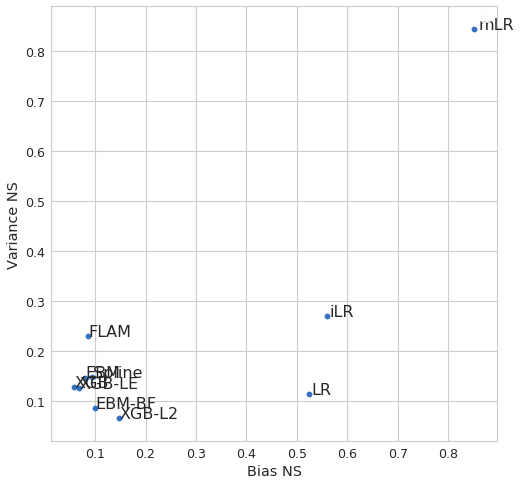

In [235]:
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(8, 8))
x, y, model_names = bias_ns.loc['average'], var_ns.loc['average'], x.index
colors = cm.rainbow(np.linspace(0, 1, len(x)))

ax.scatter(x, y)

for i, txt in enumerate(model_names):
    if txt in model_name_dict:
        txt = model_name_dict[txt]
    ax.annotate(txt, (x[i] + 0.01 * x[i], y[i]), size=16)

plt.legend()
plt.xlabel('Bias NS')
plt.ylabel('Variance NS')

### BIas/Var Graph

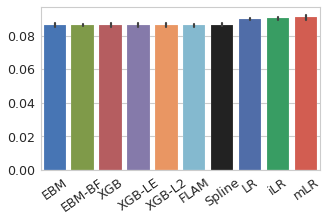

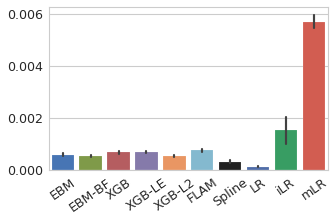

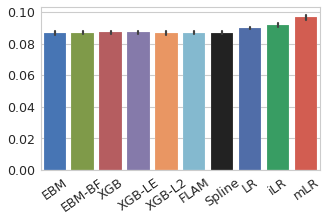

In [315]:
order = None
# order = ['dt', 'bagging-10', 'bagging-25', 'bagging-100']
# order = ['rf-10', 'rf-50', 'rf-200', 'rf-500', 'rf-1000']
# order = ['lr', 'bagging-100', 'rf-1000', 'xgb-d1', 'xgb-d3', 'ebm-main', 'ebm-pair']
# order = ['']
order = ['ebm-o50-i50-q', 'ebm-bf-o50-q', 'xgb-d1-o20-cols1', 'xgb-l-d1-o20-cols1', 'xgb-d1-o20-cols0.00001', 'flam', 'spline-v2', 'lr', 'ilr-q', 'mlr-q']

# for name, group in cls_record_df.groupby('d_name'):
all_figs = {}
all_axes = {}

for fig_name in ['bias', 'variance', 'error_test_mse']:
    for name in ['mimicii']:
        group = cls_record_df[cls_record_df.d_name == name]
    #     group = group.sort_values('model_name')

        # Impute for XGB label encoding
        if name in ['mimicii', 'credit', 'breast', 'mimiciii', 'pneumonia']:
            assert (np.sum(group.model_name == 'xgb-l-d1-o20-cols1') == 0.)
            tmp_df = group[group.model_name == 'xgb-d1-o20-cols1'].copy()
            tmp_df.model_name = 'xgb-l-d1-o20-cols1'
            group = pd.concat([group, tmp_df], axis=0)

        group['model_name'] = group.model_name.apply(lambda x: x if x not in model_name_dict else model_name_dict[x])
        order = [c if c not in model_name_dict else model_name_dict[c] for c in order]

        fig, ax = plt.subplots(figsize=(5, 3))

    #     if name == 'bikeshare':
    #         group = group[group.model_name.apply(lambda x: x != 'mlr')]

        sns.barplot(data=group, x='model_name', y=fig_name, ax=ax, order=order)    
#         sns.barplot(data=group, x='model_name', y='variance', ax=axes[1], order=order)

    #     second_highest = np.mean(group.variance.values)
    #     axes[1].set_ylim(0., second_highest + 0.6 * second_highest)

#         sns.barplot(data=group, x='model_name', y='error_test_mse', ax=axes[2], order=order)
    #     sns.barplot(data=group, x='model_name', y='avg_test_auc', ax=axes[3], order=order)
    #     axes[3].set_ylim(group.avg_test_auc.min() - 0.05, 1.)

#         for ax in axes:
#             for tick in ax.get_xticklabels():
#                 tick.set_rotation(60)

    #     fig.suptitle(name, fontsize=32)
        ax.set_ylabel('')
        ax.set_xlabel('')
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_rotation(35)
        all_figs[fig_name] = fig
        all_axes[fig_name] = ax
        plt.show()

In [316]:
for fig_name in ['bias', 'variance', 'error_test_mse']:
    all_figs[fig_name].savefig('notebooks/figures/mimicii_%s.pdf' % fig_name, bbox_inches='tight', dpi=300)

In [ ]:
fig

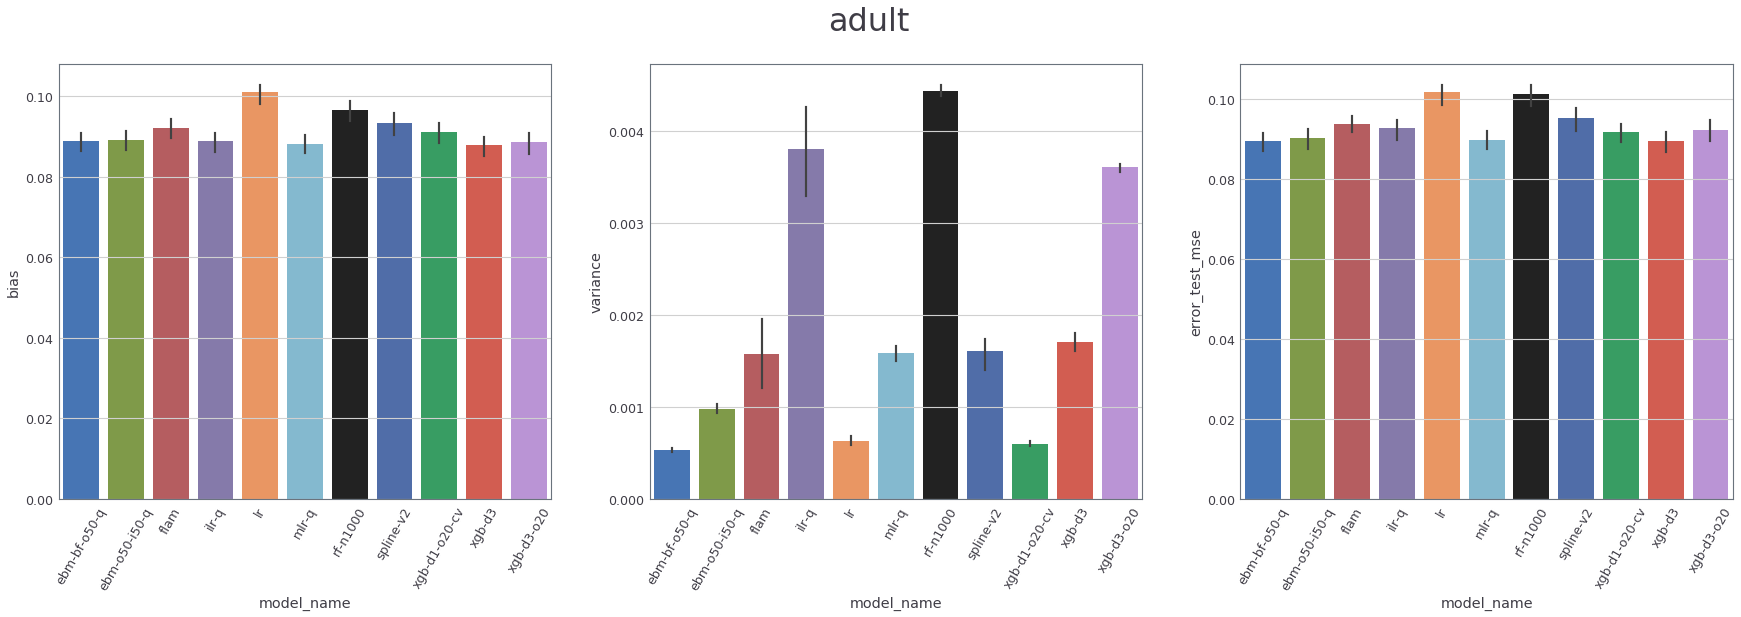

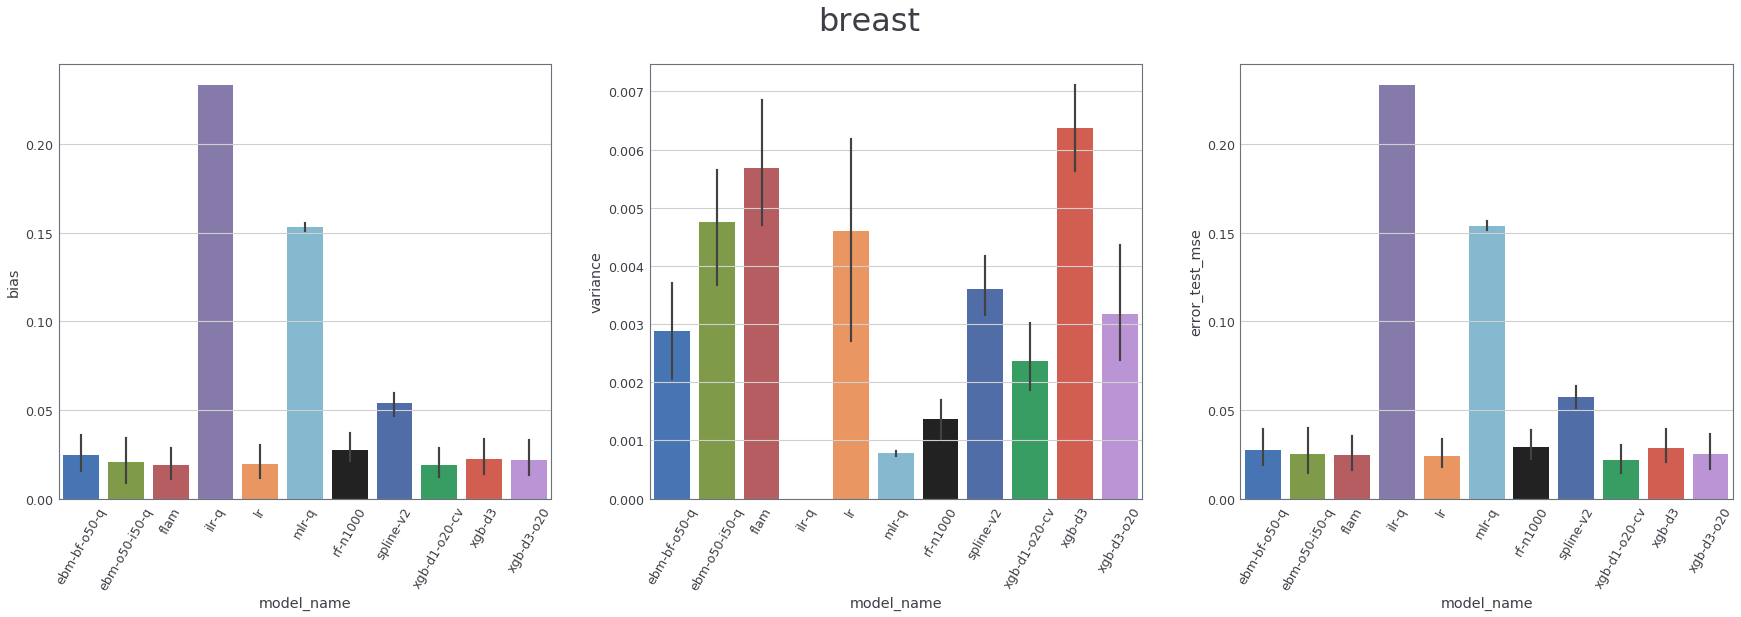

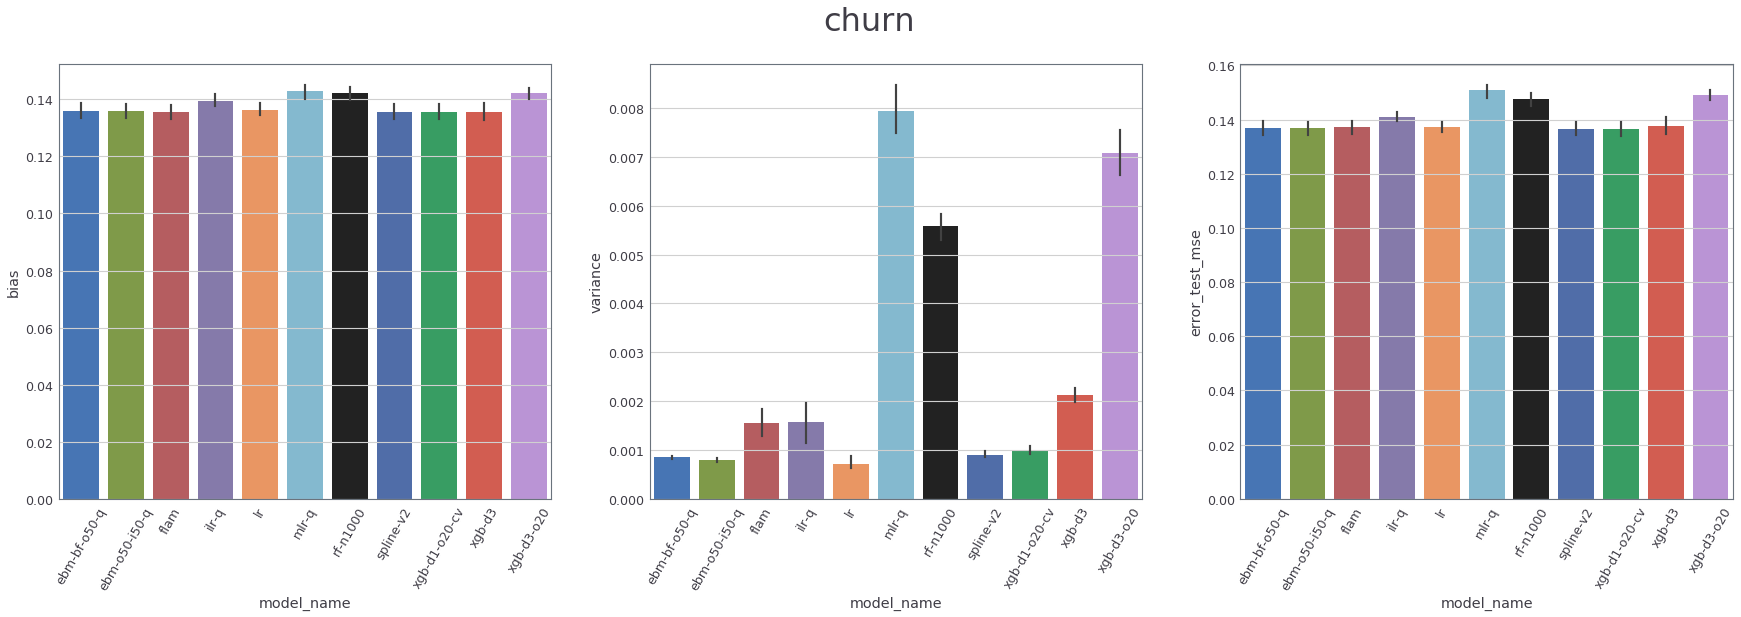

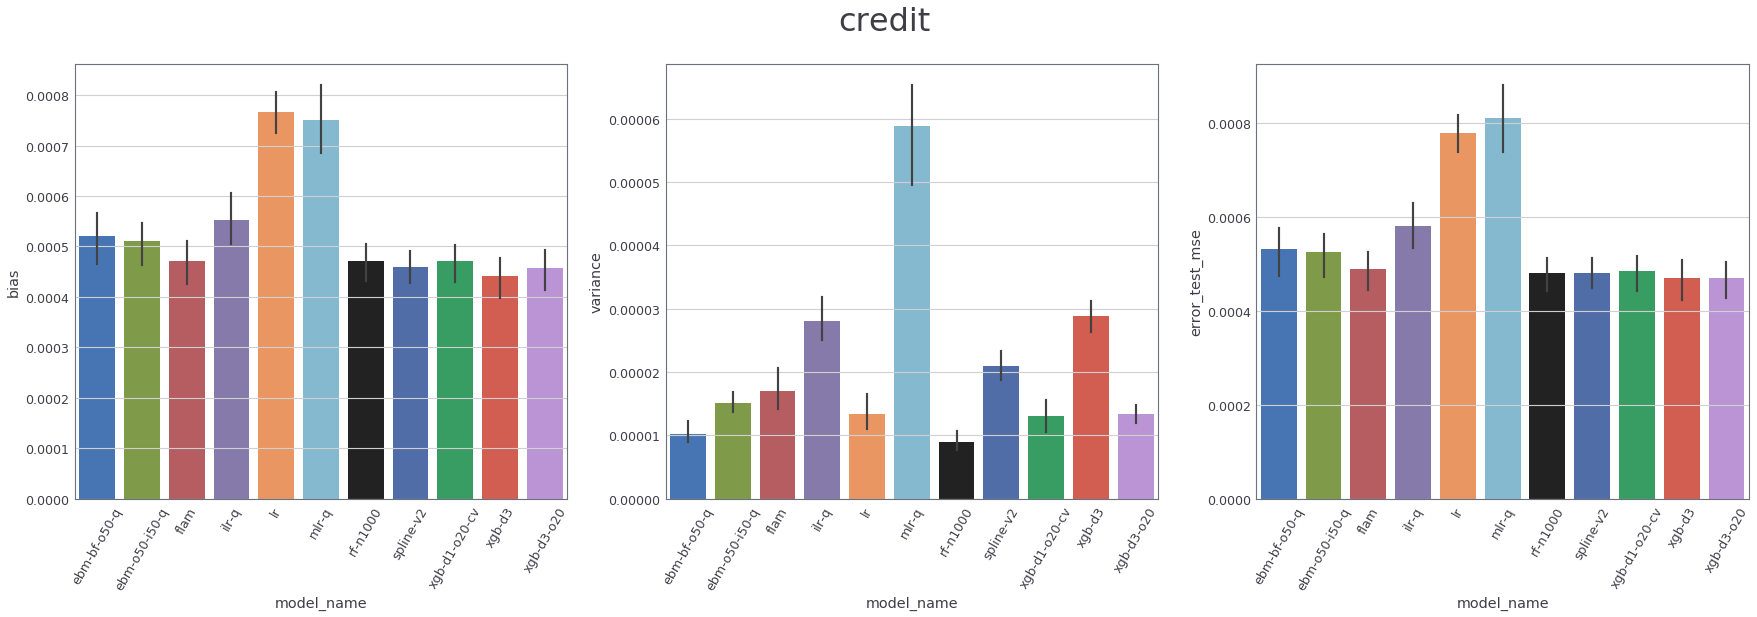

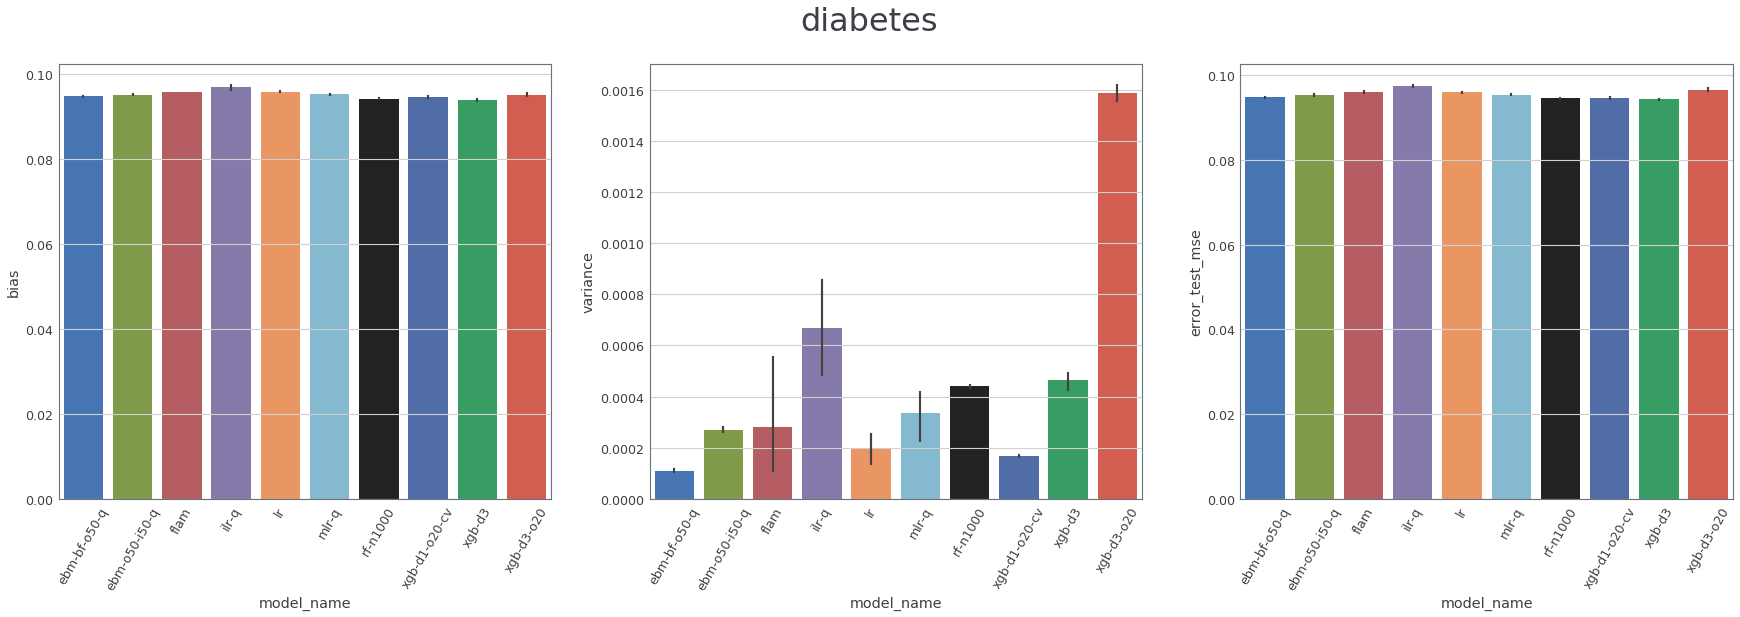

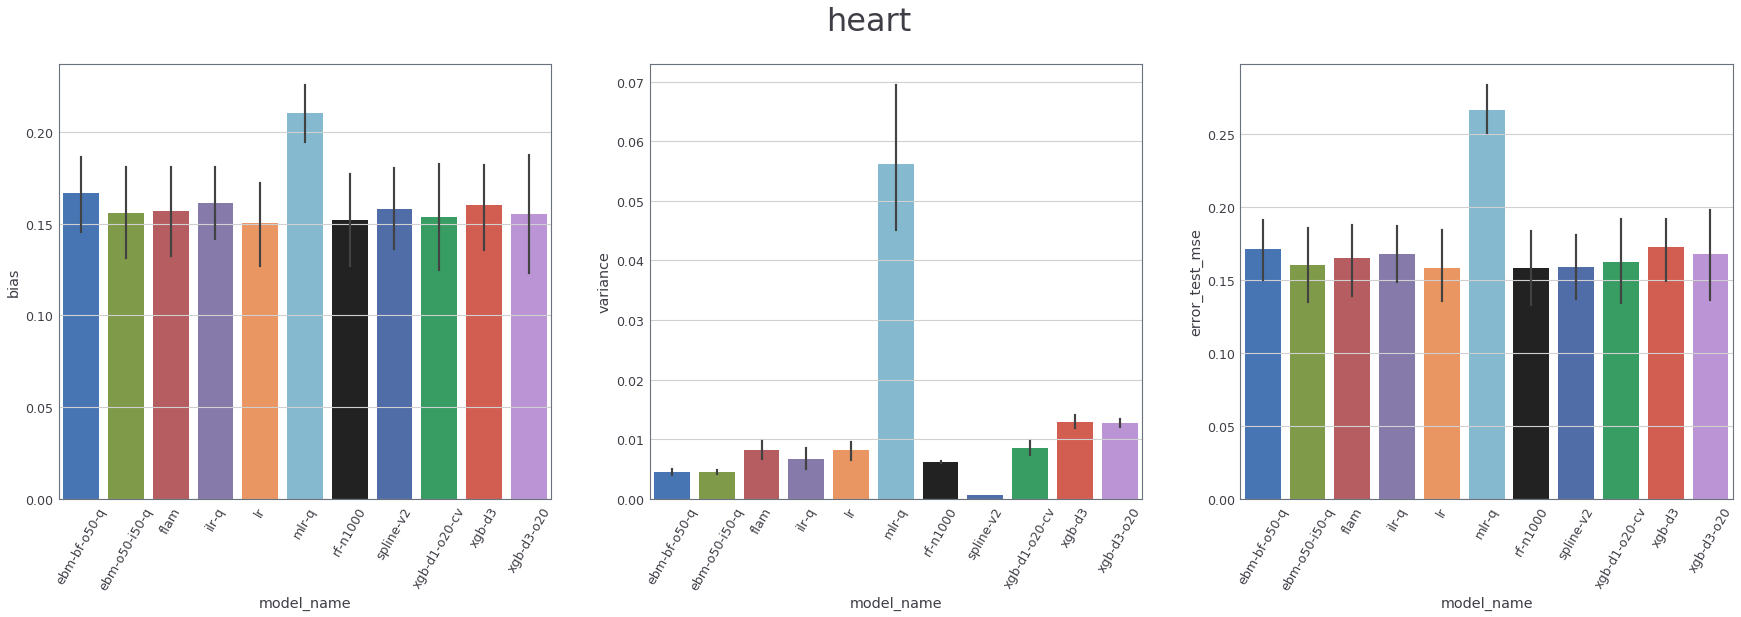

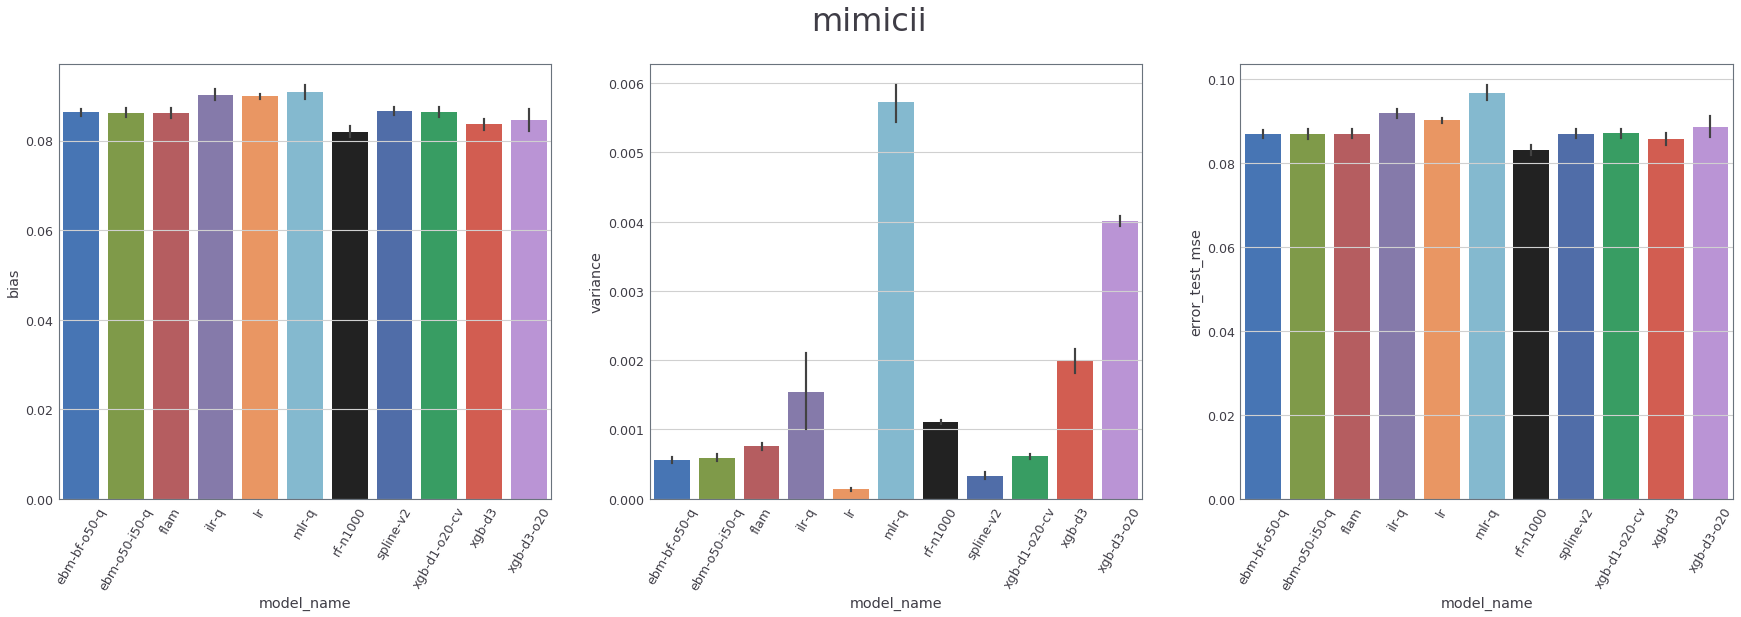

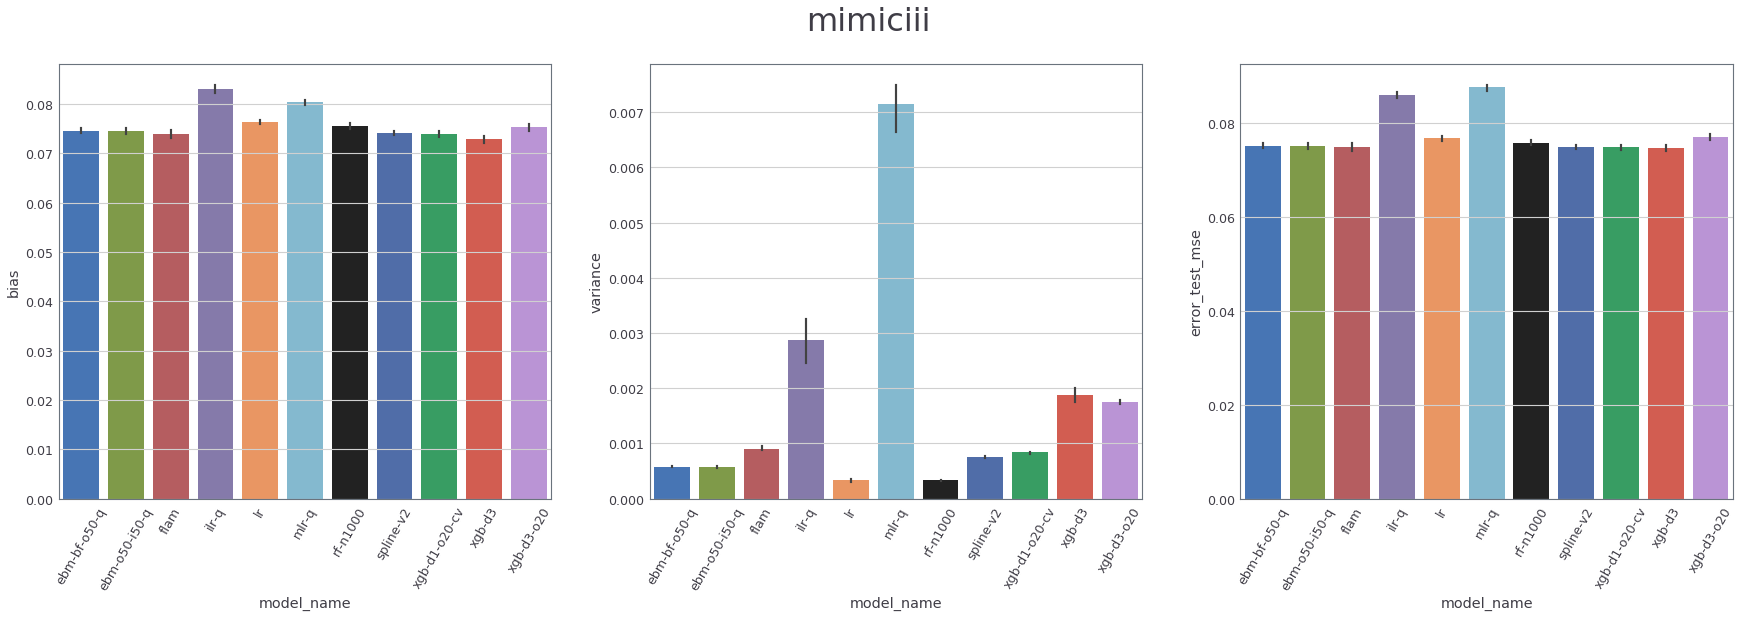

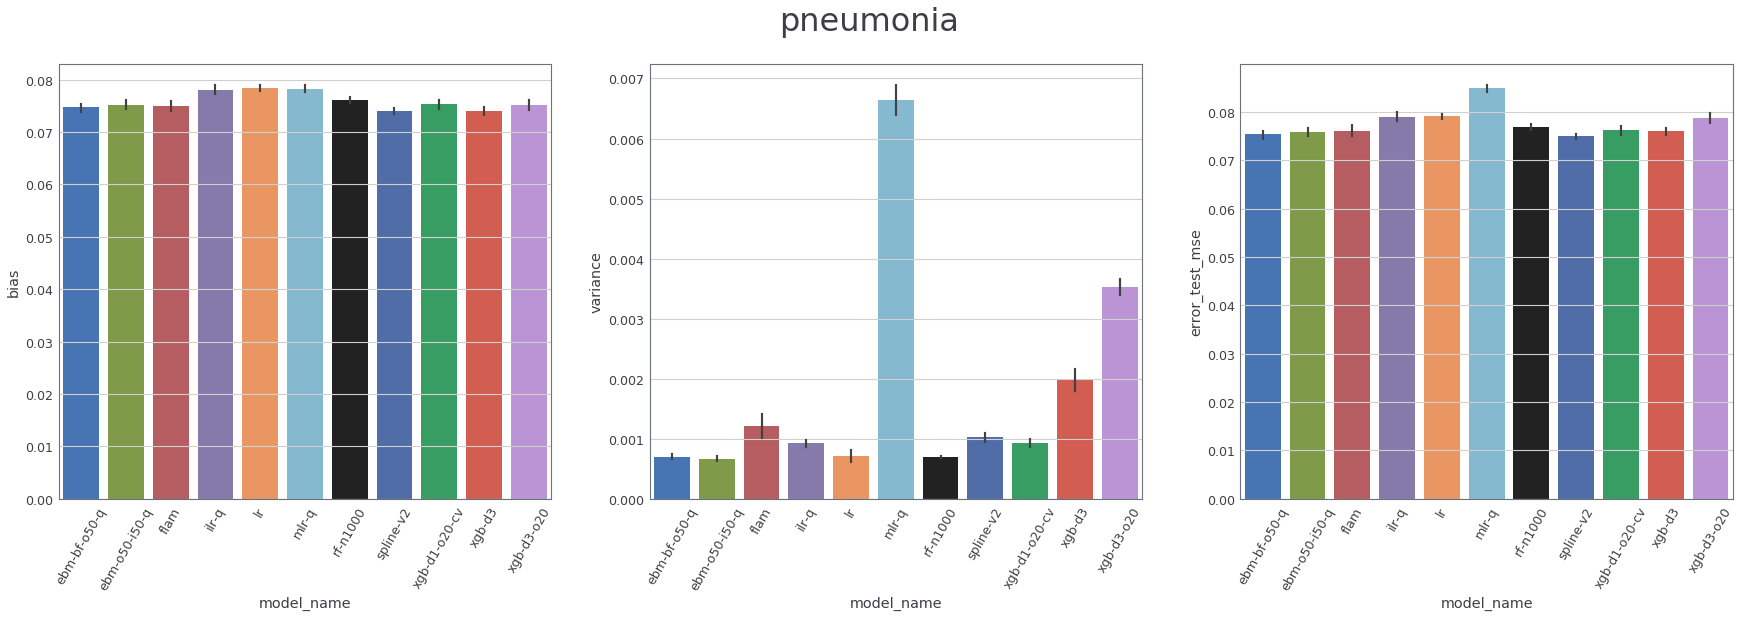

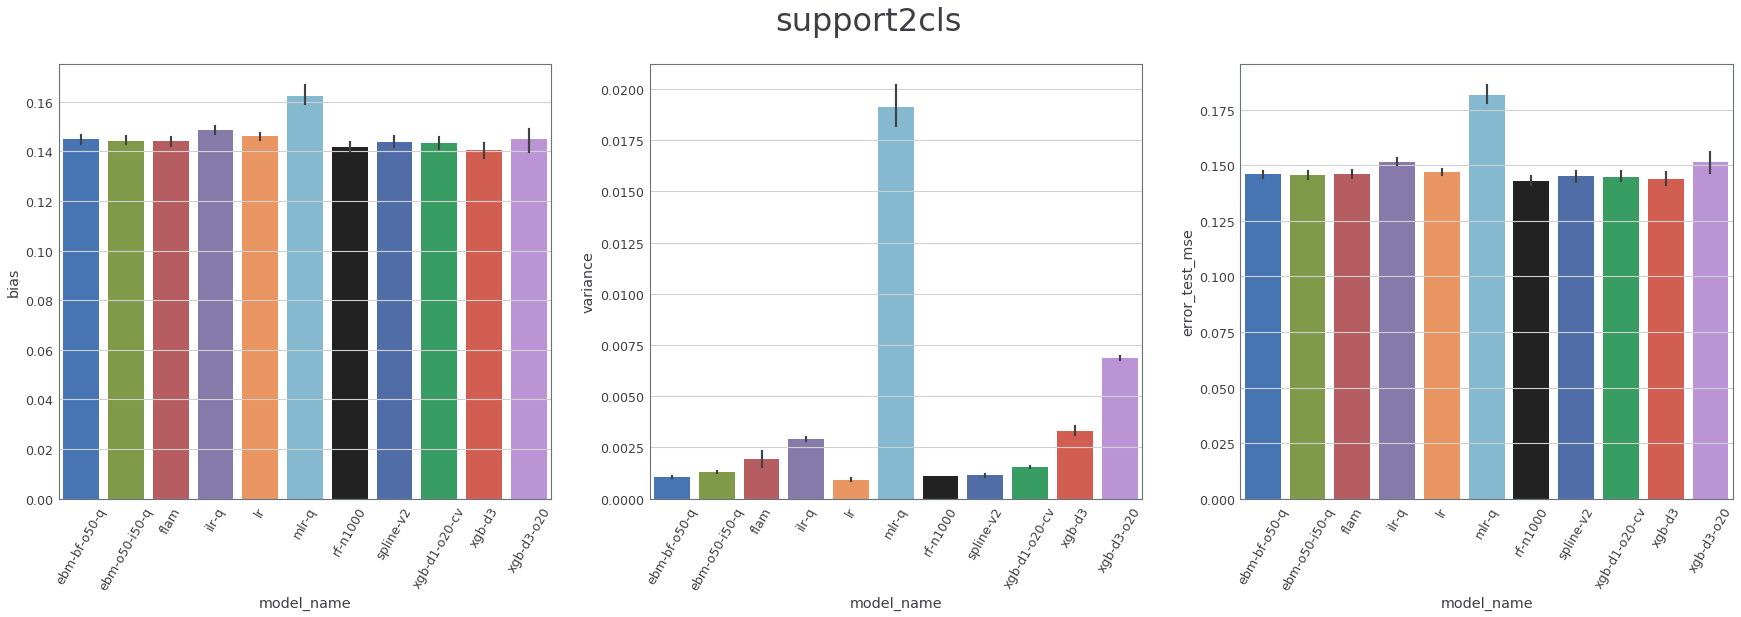

In [18]:
order = None
# order = ['dt', 'bagging-10', 'bagging-25', 'bagging-100']
# order = ['rf-10', 'rf-50', 'rf-200', 'rf-500', 'rf-1000']
# order = ['lr', 'bagging-100', 'rf-1000', 'xgb-d1', 'xgb-d3', 'ebm-main', 'ebm-pair']

for name, group in cls_record_df.groupby('d_name'):
    group = group.sort_values('model_name')
    fig, axes = plt.subplots(1, 3, figsize=(30, 8))
    
#     if name == 'bikeshare':
#         group = group[group.model_name.apply(lambda x: x != 'mlr')]
    
    sns.barplot(data=group, x='model_name', y='bias', ax=axes[0], order=order)    
    sns.barplot(data=group, x='model_name', y='variance', ax=axes[1], order=order)
    
#     second_highest = np.mean(group.variance.values)
#     axes[1].set_ylim(0., second_highest + 0.6 * second_highest)
    
    sns.barplot(data=group, x='model_name', y='error_test_mse', ax=axes[2], order=order)
#     sns.barplot(data=group, x='model_name', y='avg_test_auc', ax=axes[3], order=order)
#     axes[3].set_ylim(group.avg_test_auc.min() - 0.05, 1.)
    
    for ax in axes:
        for tick in ax.get_xticklabels():
            tick.set_rotation(60)
        
    fig.suptitle(name, fontsize=32)
    plt.show()

### Combined Bias/Var graph

In [135]:
%matplotlibtlib inline

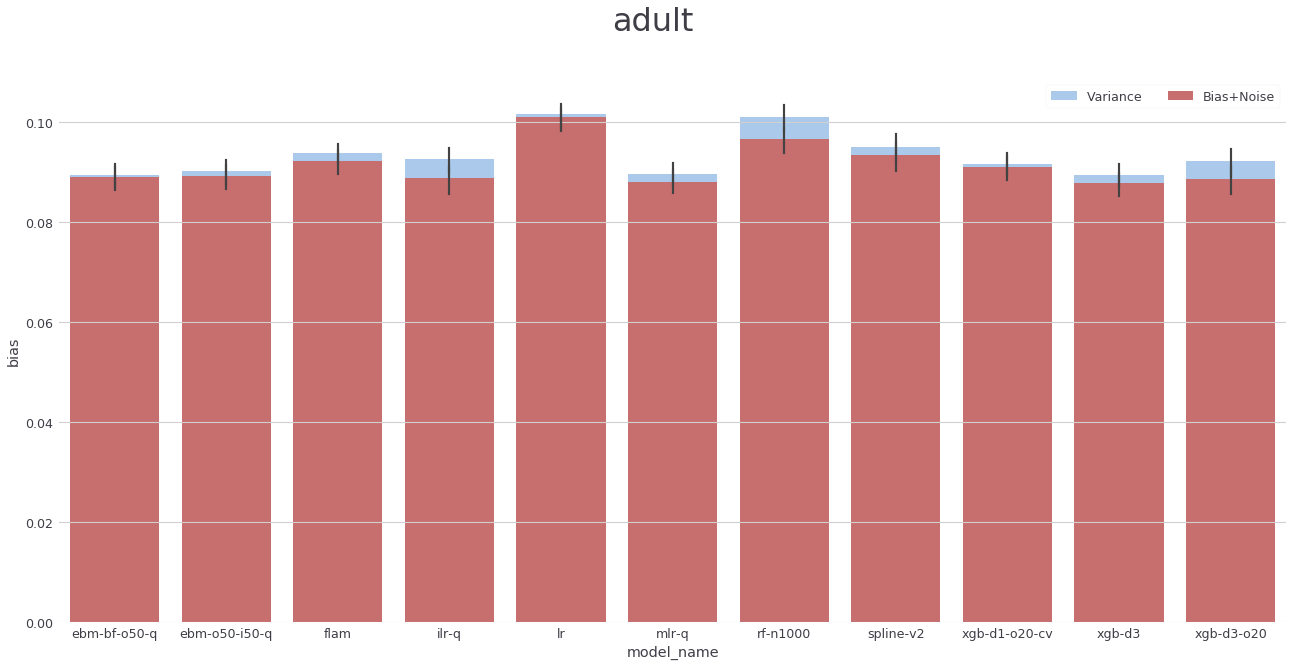

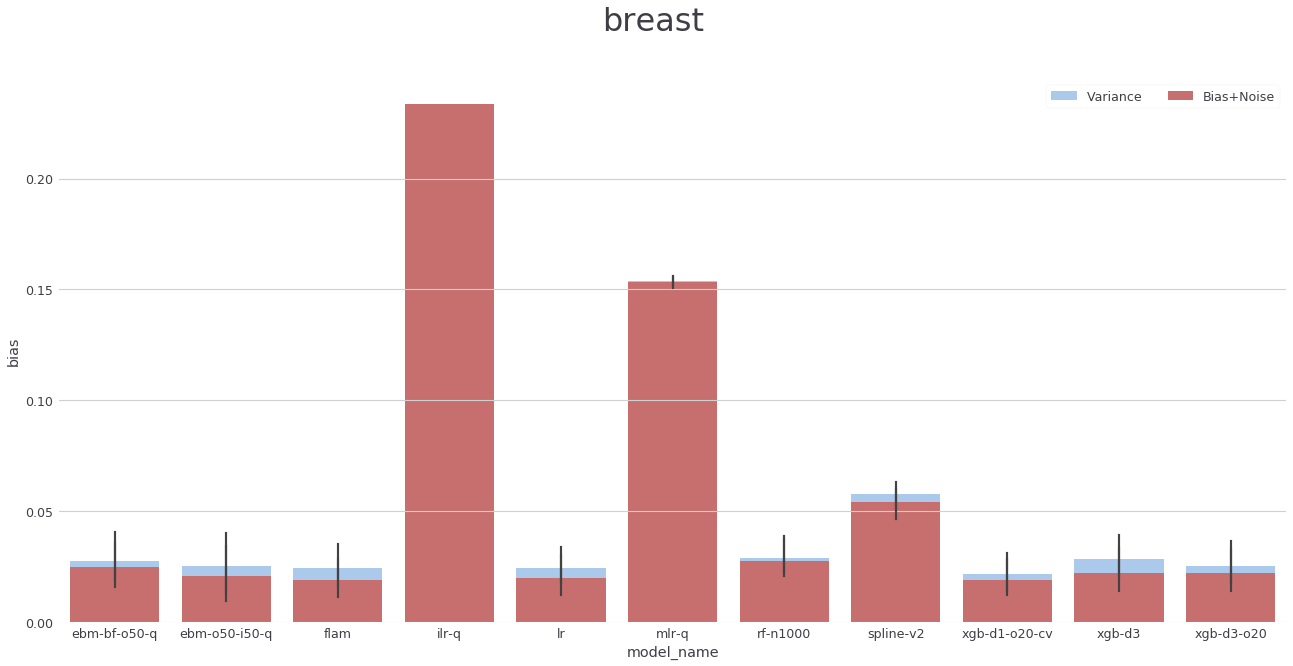

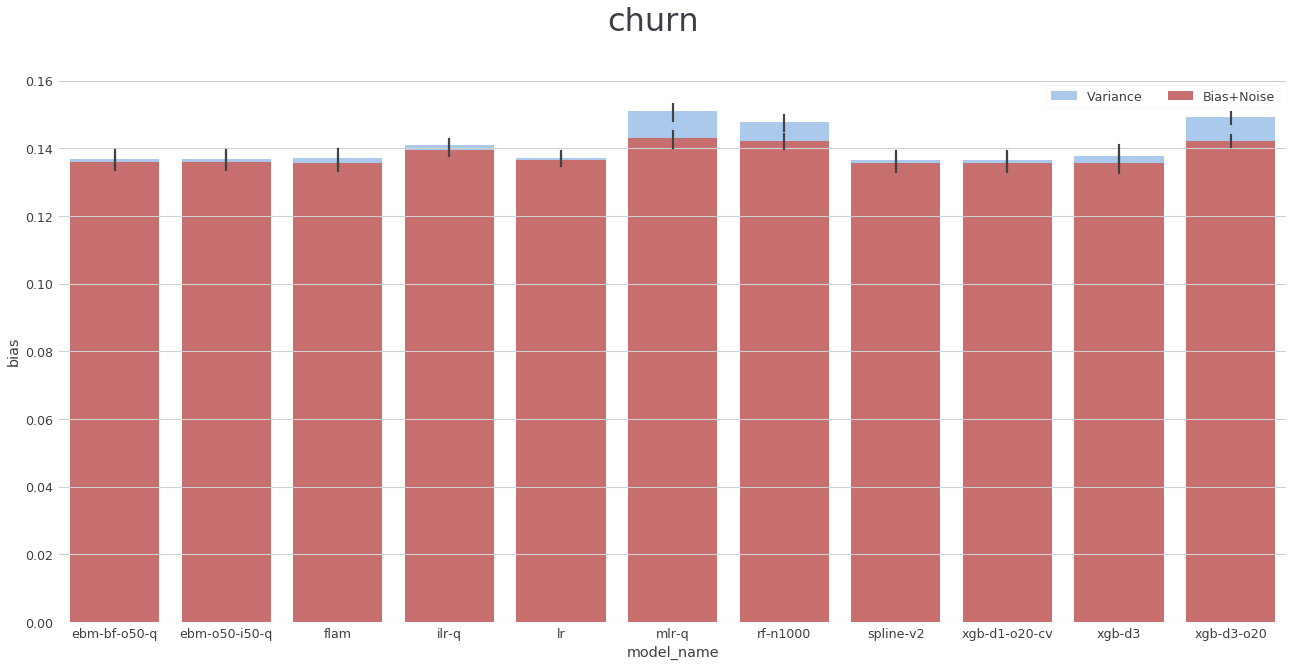

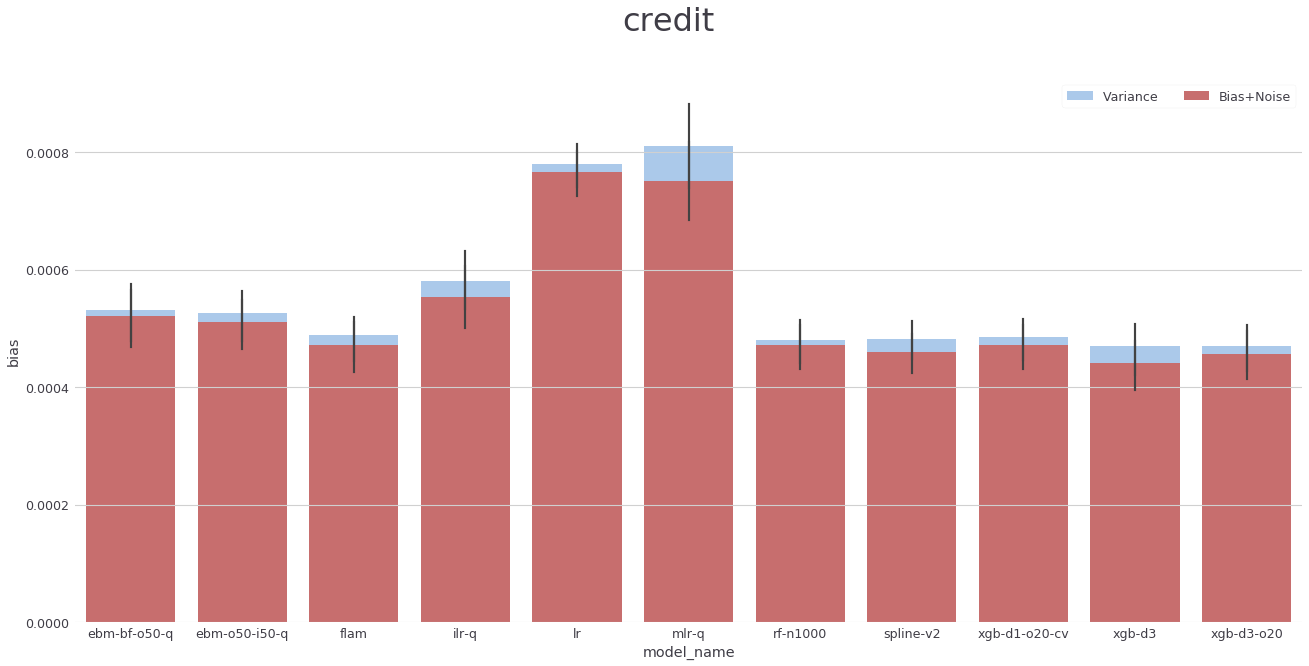

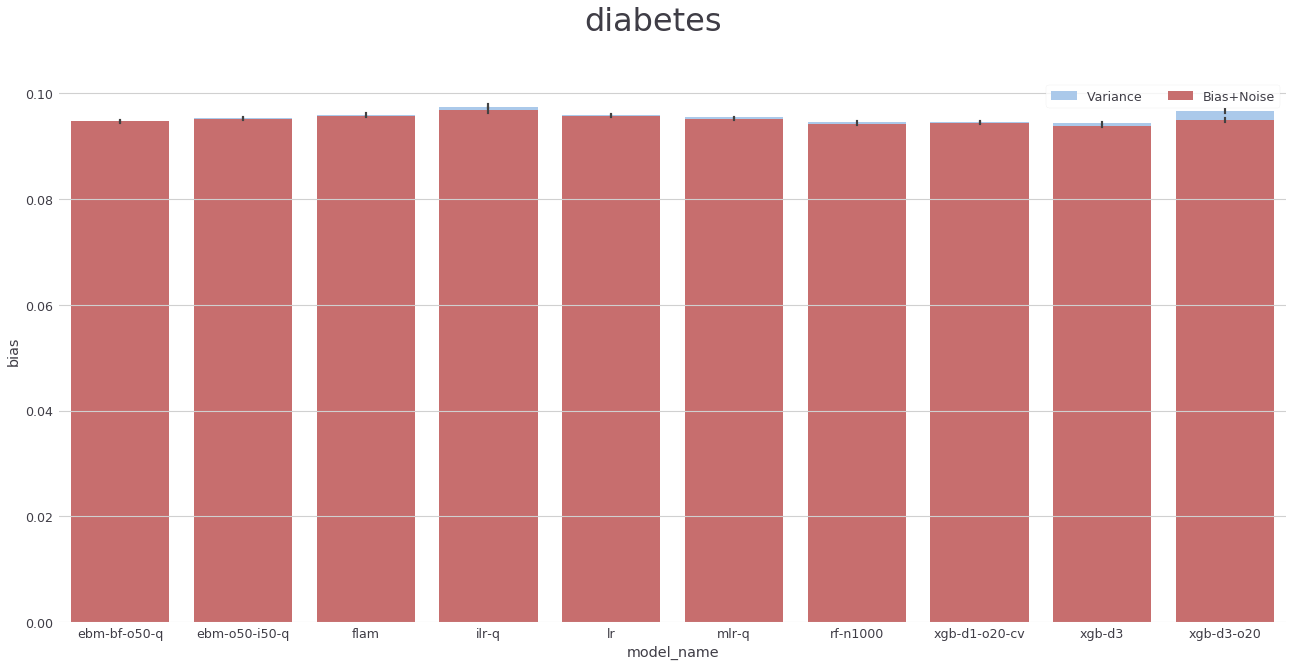

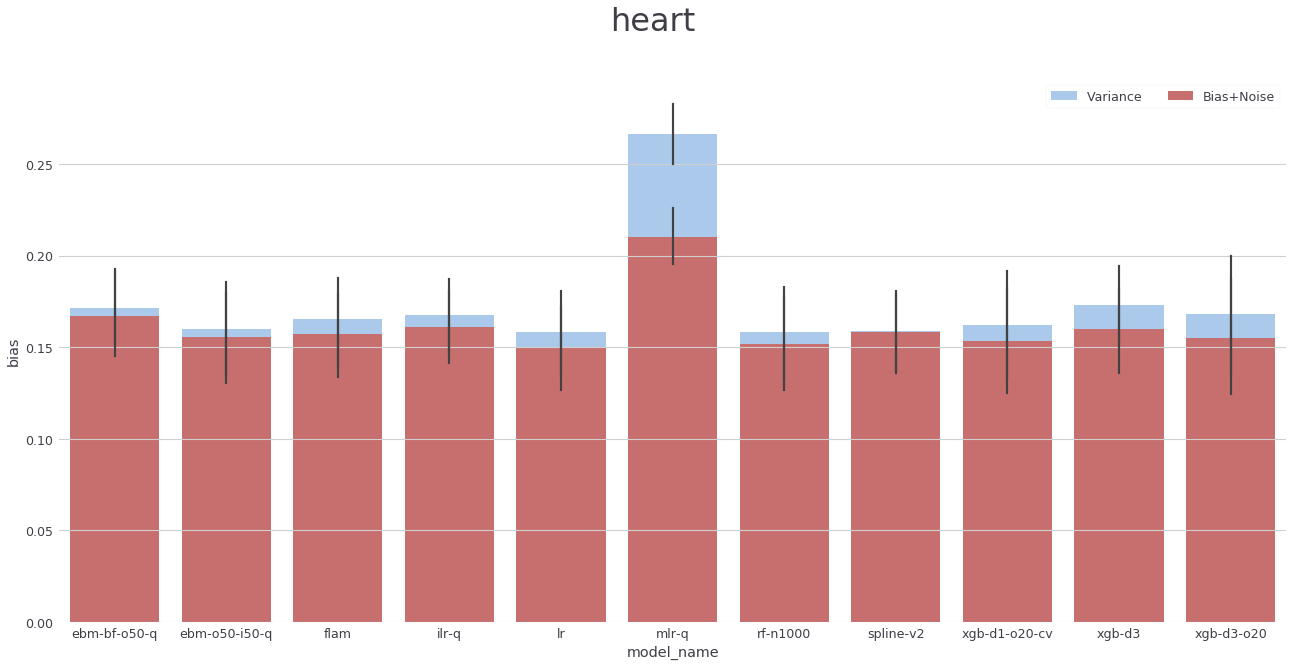

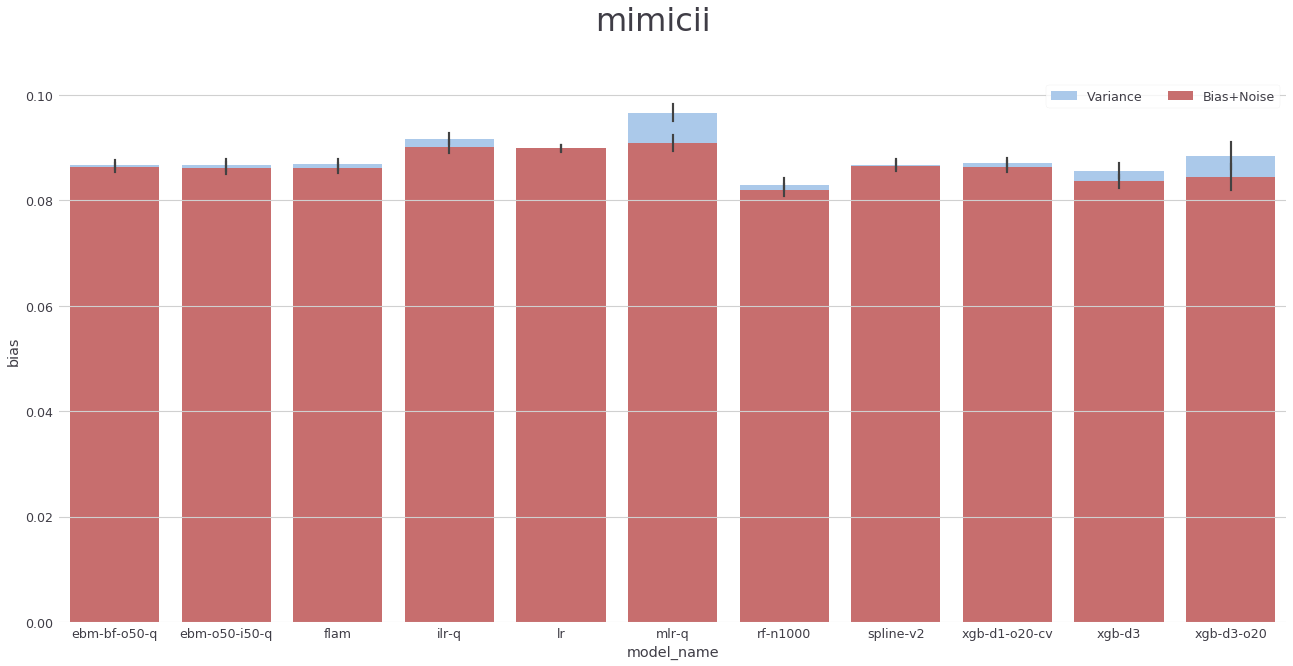

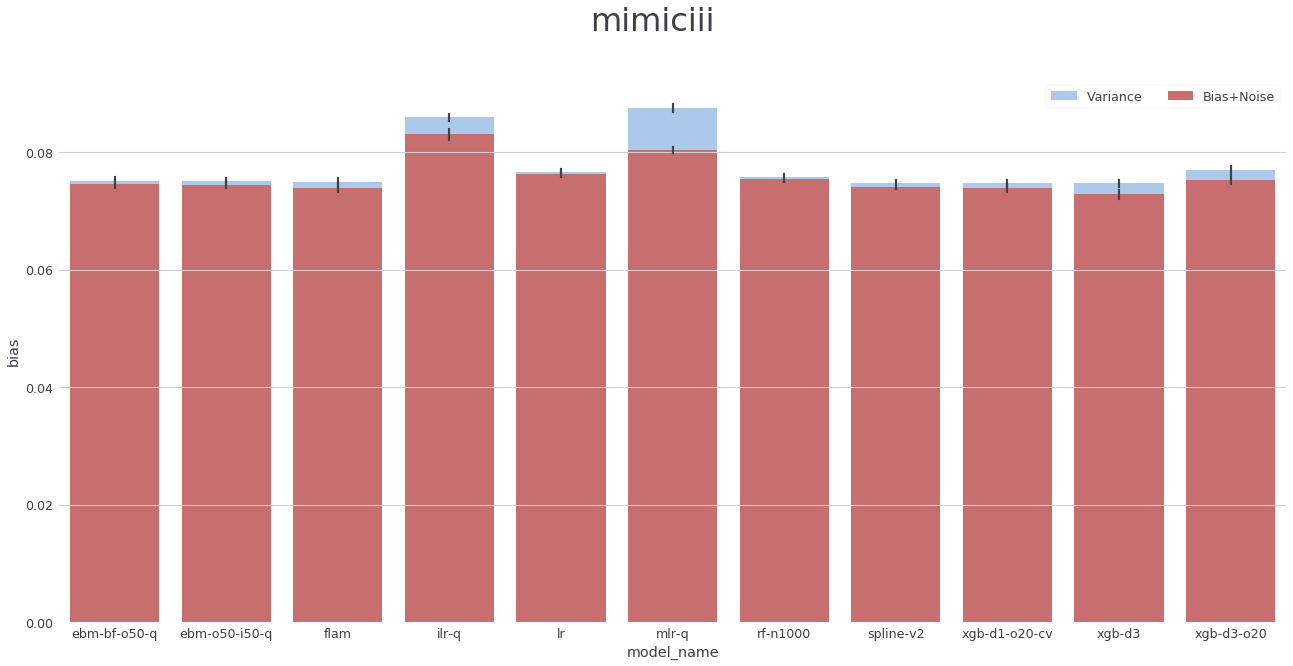

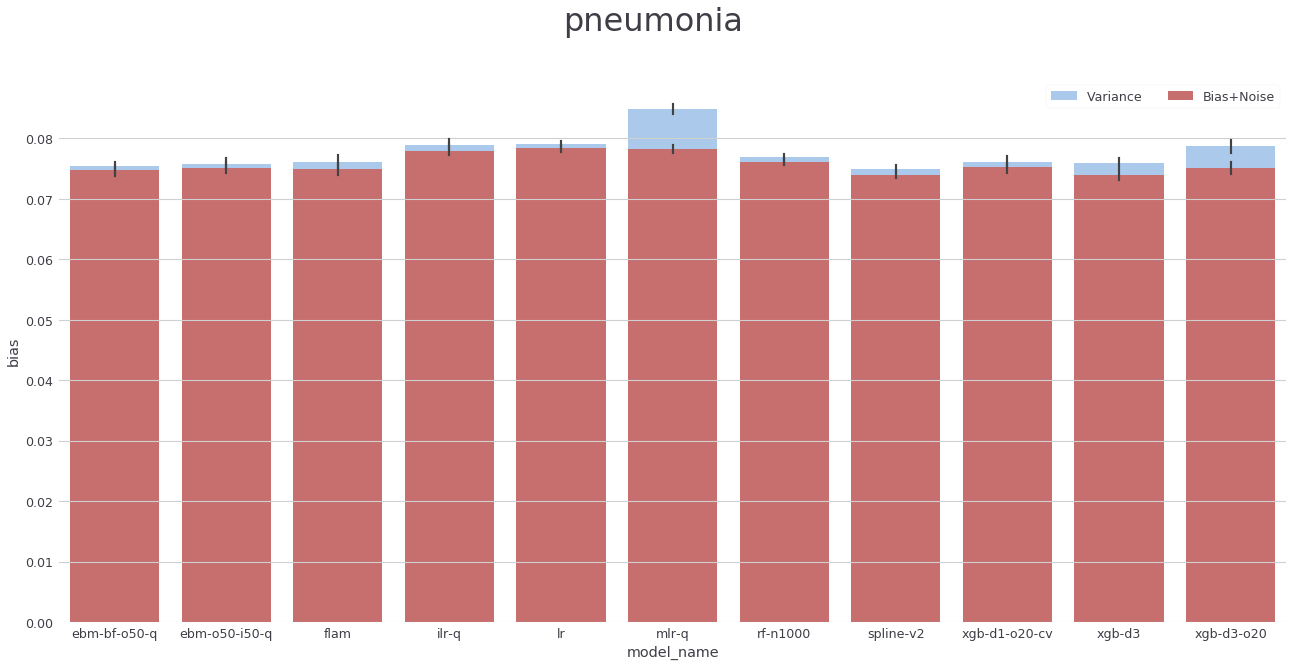

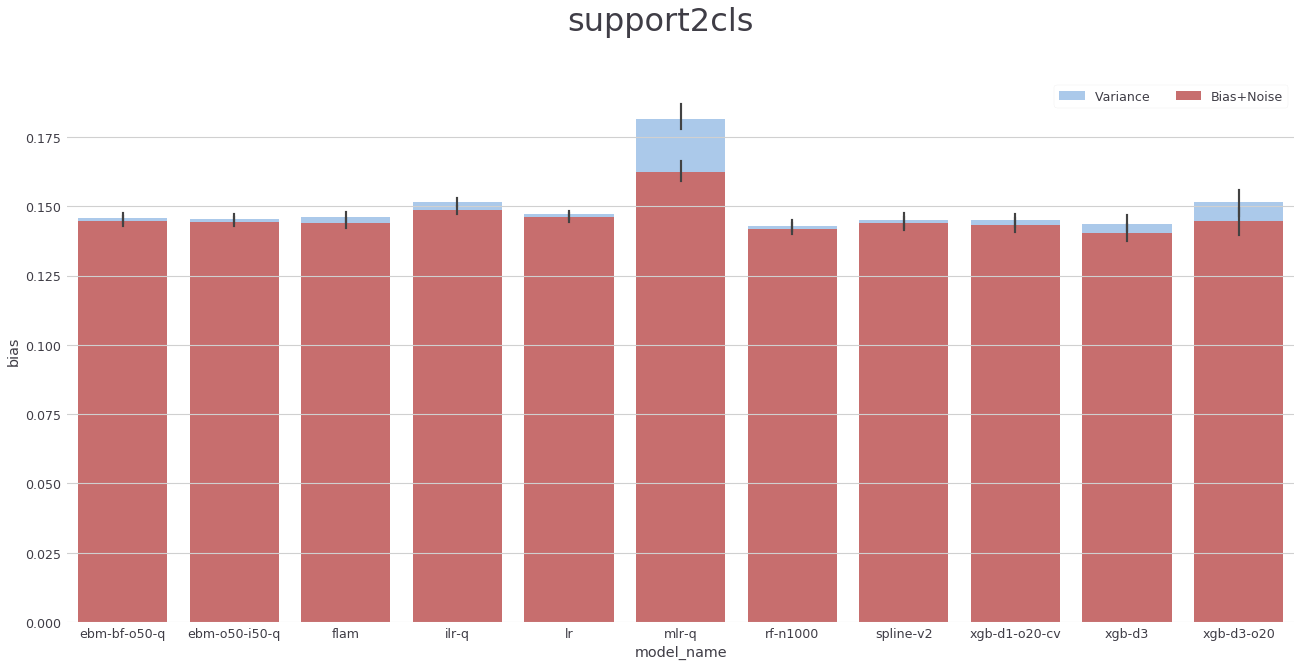

In [19]:
order = None
# order = ['dt', 'bagging-10', 'bagging-25', 'bagging-100']
# order = ['rf-10', 'rf-50', 'rf-200', 'rf-500', 'rf-1000']
# order = ['lr', 'dt', 'bagging-100', 'rf-10', 'rf-1000', 'xgb-d1', 'xgb-d2', 'xgb-d3', 'ebm-main', 'ebm-pair']
# order = ['lr', 'dt', 'bagging-100', 'rf-1000-d5', 'rf-1000-d10', 'rf-1000', 'xgb-d3', 'ebm-main', 'ebm-pair']

for name, group in cls_record_df.sort_values('model_name').groupby('d_name'):
    fig, ax = plt.subplots(figsize=(22, 10))

    sns.set_color_codes("pastel")
    sns.barplot(x="model_name", y="error_test_mse", data=group,
                label="Variance", color="b", order=order)

    sns.set_color_codes("muted")
    sns.barplot(x="model_name", y="bias", data=group,
                label="Bias+Noise", color="r", order=order)

    ax.legend(ncol=2, loc="best", frameon=True)

    sns.despine(left=True, bottom=True)

    fig.suptitle(name, fontsize=32)
    plt.show()

## Refined Performance

### Table

In [81]:
from vis_utils import rank, normalized_score, add_new_row, highlight_min_max
from general_utils import vector_in

cls_record_df = all_record_df[~vector_in(all_record_df.d_name, ['calhousing', 'bikeshare', 'onlinenews', 'wine', 'support2reg'])]
cls_record_df = cls_record_df[vector_in(cls_record_df.model_name, [
#     'ebm-o50-i50-q', 'ebm-bf-o50-q',
#     'xgb-d1-o20-cv', 'xgb-d3', 'xgb-d3-o20',
#     'flam',
#     'spline-v2',
#     'lr', 'mlr-q', 'ilr-q', 'rf-n1000', 
#     'skgbt-d1-o20-cv', 'skgbt-d3-cv',
    
    'ebm-o50-i50-q', 'ebm-bf-o50-q',
    'spline-v2',
    'xgb-d1-o20-cols0.00001', 'xgb-d1-o20-cols0.1', 'xgb-d1-o20-cols0.5', 'xgb-d1-o20-cols1',
    'lr', 'lr-l1',
])]

# cls_record_df = cls_record_df[cls_record_df.d_name != 'diabetes']

# for metric in ['test_auc', 'test_mse', 'test_aupr', 'test_logloss', 'test_acc']:
for metric in ['avg_test_auc', 'error_test_mse', 'avg_test_aupr', 'avg_test_logloss', 'avg_test_acc']:

# for metric in ['test_auc', 'test_mse', 'test_aupr', 'test_logloss', 'test_acc', 'train_auc', 'train_aupr', 'train_logloss', 'train_acc']:
    print(metric)
    the_format = '%.4f +- %.4f' if 'mse' not in metric else '%.5f +- %.5f'
    tmp = cls_record_df.groupby(['d_name', 'model_name'], as_index=False)[metric].agg(['mean', 'std']).apply(lambda x: the_format % (x['mean'], x['std']), axis=1)
    
    results = []
    for d_name in tmp.index.levels[0]:
        tmp_df = pd.DataFrame(tmp[d_name]).T
        tmp_df.index = [d_name]
        results.append(tmp_df)
    table = pd.concat(results, axis=0, sort=False)
    
    is_metric_higher_better = (metric in ['avg_test_auc', 'avg_test_aupr', 'avg_test_acc'])
    # Add two rows
    mean_score = table.apply(lambda x: '%.4f' % (x.apply(lambda s: float(s[:s.index(' +-')] if isinstance(s, str) and ' +-' in s else s)).mean()), axis=0)
    new_table = add_new_row(table, mean_score, 'average')

    mean_rank = table.apply(rank, axis=1, is_metric_higher_better=is_metric_higher_better).mean()
    new_table = add_new_row(new_table, mean_rank.apply(lambda x: '%.2f' % x), 'avg_rank')
    
    avg_rank_rank = mean_rank.rank(ascending=True)
    new_table = add_new_row(new_table, avg_rank_rank, 'avg_rank_rank')

    mean_normalized_score = table.apply(normalized_score, axis=1, is_metric_higher_better=is_metric_higher_better).mean()
    new_table = add_new_row(new_table, mean_normalized_score.apply(lambda x: '%.3f' % x), 'avg_score')
    
    avg_score_rank = mean_normalized_score.rank(ascending=False)
    new_table = add_new_row(new_table, avg_score_rank, 'avg_score_rank')
    
    if 'auc' in metric:
        mean_normalized_score_b = table.apply(normalized_score, axis=1, min_value=0.5, is_metric_higher_better=is_metric_higher_better).mean()
        new_table = add_new_row(new_table, mean_normalized_score_b.apply(lambda x: '%.3f' % x), 'avg_score_b0.5')

        avg_score_rank_b = mean_normalized_score_b.rank(ascending=False)
        new_table = add_new_row(new_table, avg_score_rank_b, 'avg_score_b0.5_rank')

    display(new_table.style.apply(highlight_min_max, axis=1))


avg_test_auc


,ebm-bf-o50-q,ebm-o50-i50-q,lr,lr-l1,spline-v2,xgb-d1-o20-cols0.00001,xgb-d1-o20-cols0.1,xgb-d1-o20-cols0.5,xgb-d1-o20-cols1
adult,0.9268 +- 0.0056,0.9236 +- 0.0064,0.9070 +- 0.0065,0.9085 +- 0.0071,0.9165 +- 0.0069,0.9167 +- 0.0066,0.9229 +- 0.0058,0.9266 +- 0.0056,0.9248 +- 0.0057
breast,0.9933 +- 0.0076,0.9951 +- 0.0063,0.9952 +- 0.0050,0.9940 +- 0.0044,0.9810 +- 0.0081,0.9952 +- 0.0059,0.9956 +- 0.0056,0.9956 +- 0.0051,0.9954 +- 0.0051
churn,0.8410 +- 0.0082,0.8410 +- 0.0068,0.8408 +- 0.0064,nan,0.8418 +- 0.0075,nan,nan,nan,nan
compass,0.7425 +- 0.0170,0.7396 +- 0.0141,0.7259 +- 0.0096,0.7270 +- 0.0106,0.7378 +- 0.0179,0.7406 +- 0.0138,0.7406 +- 0.0138,0.7417 +- 0.0152,0.7419 +- 0.0156
credit,0.9726 +- 0.0110,0.9741 +- 0.0079,0.9614 +- 0.0124,0.9587 +- nan,0.9783 +- 0.0054,0.9767 +- 0.0042,0.9736 +- 0.0027,0.9731 +- 0.0029,0.9729 +- 0.0029
diabetes,0.6738 +- 0.0054,0.6609 +- 0.0049,0.6617 +- 0.0052,0.6275 +- nan,nan,0.6588 +- nan,0.6834 +- nan,0.6835 +- nan,0.6795 +- 0.0056
heart,0.8361 +- 0.0649,0.8492 +- 0.0676,0.8633 +- 0.0631,nan,0.8626 +- 0.0665,nan,nan,nan,nan
mimicii,0.8306 +- 0.0087,0.8307 +- 0.0087,0.7922 +- 0.0077,0.7922 +- 0.0077,0.8252 +- 0.0083,0.8301 +- 0.0090,0.8301 +- 0.0090,0.8306 +- 0.0096,0.8306 +- 0.0096
mimiciii,0.8026 +- 0.0064,0.8055 +- 0.0048,0.7838 +- 0.0054,nan,0.8085 +- 0.0053,nan,nan,nan,nan
pneumonia,0.8465 +- 0.0088,0.8496 +- 0.0062,0.8341 +- 0.0057,nan,0.8470 +- 0.0049,nan,nan,nan,nan


error_test_mse


,ebm-bf-o50-q,ebm-o50-i50-q,lr,lr-l1,spline-v2,xgb-d1-o20-cols0.00001,xgb-d1-o20-cols0.1,xgb-d1-o20-cols0.5,xgb-d1-o20-cols1
adult,0.08945 +- 0.00291,0.09018 +- 0.00320,0.10154 +- 0.00322,0.10098 +- 0.00351,0.09504 +- 0.00381,0.09601 +- 0.00318,0.09161 +- 0.00291,0.08941 +- 0.00298,0.09043 +- 0.00310
breast,0.02761 +- 0.01390,0.02544 +- 0.01701,0.02431 +- 0.01107,0.02437 +- 0.00926,0.05755 +- 0.00815,0.02182 +- 0.00972,0.02031 +- 0.01151,0.02145 +- 0.01101,0.02193 +- 0.01094
churn,0.13686 +- 0.00348,0.13676 +- 0.00323,0.13710 +- 0.00247,nan,0.13660 +- 0.00331,nan,nan,nan,nan
compass,0.20420 +- 0.00537,0.20515 +- 0.00458,0.21134 +- 0.00303,0.21128 +- 0.00309,0.20587 +- 0.00636,0.20482 +- 0.00433,0.20482 +- 0.00433,0.20433 +- 0.00516,0.20424 +- 0.00531
credit,0.00053 +- 0.00007,0.00053 +- 0.00006,0.00078 +- 0.00005,0.00075 +- nan,0.00048 +- 0.00004,0.00051 +- 0.00000,0.00050 +- 0.00001,0.00049 +- 0.00002,0.00049 +- 0.00002
diabetes,0.09479 +- 0.00025,0.09535 +- 0.00025,0.09598 +- 0.00021,0.09697 +- nan,nan,0.09770 +- nan,0.09461 +- nan,0.09458 +- nan,0.09463 +- 0.00008
heart,0.17141 +- 0.02764,0.16018 +- 0.03373,0.15840 +- 0.02987,nan,0.15879 +- 0.02858,nan,nan,nan,nan
mimicii,0.08682 +- 0.00118,0.08677 +- 0.00143,0.09004 +- 0.00075,0.09003 +- 0.00074,0.08681 +- 0.00125,0.08682 +- 0.00145,0.08682 +- 0.00145,0.08710 +- 0.00149,0.08710 +- 0.00150
mimiciii,0.07517 +- 0.00078,0.07507 +- 0.00072,0.07666 +- 0.00058,nan,0.07483 +- 0.00050,nan,nan,nan,nan
pneumonia,0.07542 +- 0.00109,0.07586 +- 0.00109,0.07907 +- 0.00069,nan,0.07501 +- 0.00067,nan,nan,nan,nan


avg_test_aupr


,ebm-bf-o50-q,ebm-o50-i50-q,lr,lr-l1,spline-v2,xgb-d1-o20-cols0.00001,xgb-d1-o20-cols0.1,xgb-d1-o20-cols0.5,xgb-d1-o20-cols1
adult,0.8250 +- 0.0109,0.8210 +- 0.0115,0.7689 +- 0.0131,0.7714 +- 0.0146,0.8009 +- 0.0139,0.7997 +- 0.0134,0.8162 +- 0.0107,0.8242 +- 0.0108,0.8204 +- 0.0115
breast,0.9958 +- 0.0050,0.9967 +- 0.0045,0.9969 +- 0.0033,0.9961 +- 0.0032,0.9866 +- 0.0085,0.9969 +- 0.0039,0.9972 +- 0.0036,0.9973 +- 0.0033,0.9971 +- 0.0033
churn,0.6446 +- 0.0249,0.6472 +- 0.0247,0.6476 +- 0.0219,nan,0.6505 +- 0.0213,nan,nan,nan,nan
compass,0.7110 +- 0.0194,0.7054 +- 0.0173,0.6870 +- 0.0111,0.6882 +- 0.0119,0.7049 +- 0.0222,0.7079 +- 0.0168,0.7079 +- 0.0168,0.7089 +- 0.0183,0.7089 +- 0.0185
credit,0.7910 +- 0.0413,0.8021 +- 0.0378,0.7250 +- 0.0258,0.7254 +- nan,0.8248 +- 0.0241,0.8070 +- 0.0277,0.8100 +- 0.0280,0.8112 +- 0.0260,0.8126 +- 0.0240
diabetes,0.2184 +- 0.0054,0.2084 +- 0.0059,0.2098 +- 0.0058,0.1877 +- nan,nan,0.1947 +- nan,0.2189 +- nan,0.2194 +- nan,0.2189 +- 0.0006
heart,0.8104 +- 0.0825,0.8209 +- 0.0817,0.8463 +- 0.0844,nan,0.8339 +- 0.0856,nan,nan,nan,nan
mimicii,0.4292 +- 0.0168,0.4313 +- 0.0186,0.3961 +- 0.0079,0.3962 +- 0.0079,0.4319 +- 0.0134,0.4313 +- 0.0183,0.4313 +- 0.0183,0.4275 +- 0.0188,0.4277 +- 0.0189
mimiciii,0.3694 +- 0.0129,0.3682 +- 0.0121,0.3458 +- 0.0070,nan,0.3710 +- 0.0064,nan,nan,nan,nan
pneumonia,0.4600 +- 0.0135,0.4519 +- 0.0095,0.4096 +- 0.0036,nan,0.4623 +- 0.0045,nan,nan,nan,nan


avg_test_logloss


,ebm-bf-o50-q,ebm-o50-i50-q,lr,lr-l1,spline-v2,xgb-d1-o20-cols0.00001,xgb-d1-o20-cols0.1,xgb-d1-o20-cols0.5,xgb-d1-o20-cols1
adult,0.2824 +- 0.0085,0.2893 +- 0.0107,0.3199 +- 0.0101,0.3170 +- 0.0106,0.3075 +- 0.0115,0.3034 +- 0.0086,0.2889 +- 0.0091,0.2822 +- 0.0091,0.2855 +- 0.0095
breast,0.1016 +- 0.0461,0.1604 +- 0.1619,0.1052 +- 0.0323,0.1216 +- 0.0530,0.2212 +- 0.0224,0.0826 +- 0.0360,0.0762 +- 0.0391,0.0776 +- 0.0370,0.0789 +- 0.0370
churn,0.4221 +- 0.0075,0.4216 +- 0.0077,0.4242 +- 0.0092,nan,0.4222 +- 0.0099,nan,nan,nan,nan
compass,0.5954 +- 0.0122,0.5978 +- 0.0107,0.6143 +- 0.0086,0.6137 +- 0.0084,0.6007 +- 0.0164,0.5970 +- 0.0099,0.5970 +- 0.0099,0.5961 +- 0.0120,0.5959 +- 0.0124
credit,0.0032 +- 0.0004,0.0032 +- 0.0004,0.0047 +- 0.0005,0.0045 +- nan,0.0030 +- 0.0003,0.0034 +- 0.0003,0.0034 +- 0.0003,0.0034 +- 0.0003,0.0034 +- 0.0003
diabetes,0.3304 +- 0.0009,0.3329 +- 0.0010,0.3356 +- 0.0008,0.3404 +- nan,nan,0.3427 +- nan,0.3285 +- nan,0.3284 +- nan,0.3289 +- 0.0007
heart,0.5218 +- 0.0673,0.4956 +- 0.0907,0.4972 +- 0.0792,nan,0.4929 +- 0.0654,nan,nan,nan,nan
mimicii,0.2901 +- 0.0041,0.2896 +- 0.0046,0.3065 +- 0.0030,0.3064 +- 0.0030,0.2912 +- 0.0041,0.2896 +- 0.0048,0.2896 +- 0.0048,0.2899 +- 0.0052,0.2899 +- 0.0052
mimiciii,0.2633 +- 0.0027,0.2617 +- 0.0024,0.2694 +- 0.0022,nan,0.2604 +- 0.0021,nan,nan,nan,nan
pneumonia,0.2593 +- 0.0038,0.2583 +- 0.0033,0.2678 +- 0.0019,nan,0.2591 +- 0.0047,nan,nan,nan,nan


avg_test_acc


,ebm-bf-o50-q,ebm-o50-i50-q,lr,lr-l1,spline-v2,xgb-d1-o20-cols0.00001,xgb-d1-o20-cols0.1,xgb-d1-o20-cols0.5,xgb-d1-o20-cols1
adult,0.8698 +- 0.0056,0.8704 +- 0.0046,0.8527 +- 0.0060,0.8534 +- 0.0068,0.8622 +- 0.0062,0.8621 +- 0.0071,0.8673 +- 0.0052,0.8708 +- 0.0058,0.8692 +- 0.0057
breast,0.9648 +- 0.0166,0.9689 +- 0.0175,0.9724 +- 0.0185,0.9706 +- 0.0164,0.9326 +- 0.0178,0.9721 +- 0.0130,0.9727 +- 0.0167,0.9721 +- 0.0150,0.9712 +- 0.0149
churn,0.7955 +- 0.0136,0.7950 +- 0.0148,0.8007 +- 0.0103,nan,0.7982 +- 0.0150,nan,nan,nan,nan
compass,0.6856 +- 0.0126,0.6814 +- 0.0118,0.6743 +- 0.0049,0.6771 +- 0.0057,0.6806 +- 0.0065,0.6821 +- 0.0114,0.6821 +- 0.0114,0.6851 +- 0.0113,0.6864 +- 0.0117
credit,0.9994 +- 0.0001,0.9994 +- 0.0001,0.9991 +- 0.0001,0.9992 +- nan,0.9995 +- 0.0001,0.9994 +- 0.0000,0.9994 +- 0.0000,0.9995 +- 0.0000,0.9995 +- 0.0000
diabetes,0.8885 +- 0.0002,0.8884 +- 0.0001,0.8883 +- 0.0001,0.8886 +- nan,nan,0.8884 +- nan,0.8882 +- nan,0.8882 +- nan,0.8882 +- 0.0000
heart,0.7478 +- 0.0571,0.7746 +- 0.0599,0.7855 +- 0.0647,nan,0.7819 +- 0.0625,nan,nan,nan,nan
mimicii,0.8851 +- 0.0015,0.8848 +- 0.0021,0.8843 +- 0.0019,0.8843 +- 0.0019,0.8853 +- 0.0021,0.8851 +- 0.0019,0.8851 +- 0.0019,0.8845 +- 0.0020,0.8844 +- 0.0019
mimiciii,0.9056 +- 0.0008,0.9058 +- 0.0010,0.9039 +- 0.0012,nan,0.9059 +- 0.0003,nan,nan,nan,nan
pneumonia,0.9015 +- 0.0015,0.9000 +- 0.0009,0.8966 +- 0.0006,nan,0.9024 +- 0.0008,nan,nan,nan,nan


### The summarized rank and NS for bias and variance

In [82]:
cls_record_df.head()

,d_name,model_name,split_idx,n_splits,random_state,fit_time,test_size,bias,variance,error_test_mse,avg_test_auc,avg_test_aupr,avg_test_acc,avg_test_logloss,n_subsamples,subsample_ratio
59,breast,lr,0,5,1377,2.243470,0.15,0.009171,0.006364,0.015534,0.996817,0.997935,0.986919,0.071462,8,0.5
62,breast,spline-v2,0,5,1377,29122.399617,0.15,0.058178,0.003663,0.061841,0.983507,0.990977,0.918605,0.230170,8,0.5
70,breast,lr,1,5,1377,2.307035,0.15,0.018201,0.005479,0.023680,0.995804,0.997438,0.973837,0.105597,8,0.5
73,breast,spline-v2,1,5,1377,28788.919928,0.15,0.050353,0.002937,0.053290,0.979384,0.986470,0.950581,0.214226,8,0.5
81,breast,lr,2,5,1377,2.232021,0.15,0.011848,0.006361,0.018209,0.998553,0.999124,0.982558,0.112170,8,0.5


In [83]:
def get_2d_table(record_dfs, row_name='d_name', col_name='model_name', value='bias'):
    '''
    Aggregate the value based on row and col name and take average value. Then organize them into a 2d table.
    '''
    tmp = record_dfs.groupby([row_name, col_name], as_index=False)[value].agg(['mean'])['mean']
    
    results = []
    for d_name in tmp.index.levels[0]:
        tmp_df = pd.DataFrame(tmp[d_name]).T
        tmp_df.index = [d_name]
        results.append(tmp_df)
    table = pd.concat(results, axis=0, sort=False)
    return table

In [84]:
from vis_utils import cal_statistics

# Since spline-v2 can not do bias/variance analysis on it. Remove the diabetes dataset
tmp = cls_record_df[~vector_in(cls_record_df.d_name, ['diabetes'])]

bias_table = get_2d_table(tmp, row_name='d_name', col_name='model_name', value='bias')
var_table = get_2d_table(tmp, row_name='d_name', col_name='model_name', value='variance')
error_table = get_2d_table(tmp, row_name='d_name', col_name='model_name', value='error_test_mse')

display(cal_statistics(bias_table, is_metric_higher_better=True).style.apply(highlight_min_max, axis=1))

,ebm-bf-o50-q,ebm-o50-i50-q,lr,lr-l1,spline-v2,xgb-d1-o20-cols0.00001,xgb-d1-o20-cols0.1,xgb-d1-o20-cols0.5,xgb-d1-o20-cols1
adult,0.0889197,0.0892072,0.100909,0.100488,0.0934358,0.0956972,0.091058,0.0887622,0.0898226
breast,0.0247295,0.0206916,0.0197186,0.0189276,0.0539549,0.0202911,0.018536,0.0190451,0.0194111
churn,0.136015,0.13596,0.136378,nan,0.135701,nan,nan,nan,nan
compass,0.203307,0.204136,0.210948,0.210923,0.205091,0.203913,0.203913,0.203298,0.203184
credit,0.000521753,0.000510831,0.000765709,0.00073838,0.00046031,0.000497789,0.000487353,0.000477845,0.00047461
heart,0.166867,0.155681,0.150194,nan,0.158155,nan,nan,nan,nan
mimicii,0.086266,0.0861796,0.0899052,0.0898976,0.0864784,0.0862695,0.0862696,0.0864112,0.0864044
mimiciii,0.074589,0.0744943,0.0763343,nan,0.0740736,nan,nan,nan,nan
pneumonia,0.0747263,0.0751931,0.0783584,nan,0.0739854,nan,nan,nan,nan
support2cls,0.144884,0.144254,0.146237,0.146109,0.143978,0.143588,0.143173,0.143406,0.143398


In [85]:
bias_rank = bias_table.apply(rank, is_metric_higher_better=False, axis=1).sort_index()
bias_rank = cal_statistics(bias_rank, is_metric_higher_better=False)
display(bias_rank.style.apply(highlight_min_max, axis=1))

,ebm-bf-o50-q,ebm-o50-i50-q,lr,lr-l1,spline-v2,xgb-d1-o20-cols0.00001,xgb-d1-o20-cols0.1,xgb-d1-o20-cols0.5,xgb-d1-o20-cols1
adult,2,3,9,8,6,7,5,1,4
breast,8,7,5,2,9,6,1,3,4
churn,3,2,4,7,1,7,7,7,7
compass,3,6,9,8,7,4,5,2,1
credit,7,6,9,8,1,5,4,3,2
heart,4,2,1,7,3,7,7,7,7
mimicii,2,1,9,8,7,3,4,6,5
mimiciii,3,2,4,7,1,7,7,7,7
pneumonia,2,3,4,7,1,7,7,7,7
support2cls,7,6,9,8,5,4,1,3,2


In [86]:
var_rank = var_table.apply(rank, is_metric_higher_better=False, axis=1).sort_index()
var_rank = cal_statistics(var_rank, is_metric_higher_better=False)
display(var_rank.style.apply(highlight_min_max, axis=1))

,ebm-bf-o50-q,ebm-o50-i50-q,lr,lr-l1,spline-v2,xgb-d1-o20-cols0.00001,xgb-d1-o20-cols0.1,xgb-d1-o20-cols0.5,xgb-d1-o20-cols1
adult,3,8,6,2,9,1,4,7,5
breast,5,8,7,9,6,1,2,3,4
churn,3,2,1,7,4,7,7,7,7
compass,4,7,2,1,3,6,5,8,9
credit,2,8,6,1,9,3,7,5,4
heart,3,2,4,7,1,7,7,7,7
mimicii,6,7,1,2,3,5,4,8,9
mimiciii,3,2,1,7,4,7,7,7,7
pneumonia,2,1,3,7,4,7,7,7,7
support2cls,3,6,1,2,4,5,7,8,9


In [87]:
error_rank = error_table.apply(rank, is_metric_higher_better=False, axis=1).sort_index()
error_rank = cal_statistics(error_rank, is_metric_higher_better=False)
display(error_rank.style.apply(highlight_min_max, axis=1))

,ebm-bf-o50-q,ebm-o50-i50-q,lr,lr-l1,spline-v2,xgb-d1-o20-cols0.00001,xgb-d1-o20-cols0.1,xgb-d1-o20-cols0.5,xgb-d1-o20-cols1
adult,2,3,9,8,6,7,5,1,4
breast,8,7,5,6,9,3,1,2,4
churn,3,2,4,7,1,7,7,7,7
compass,1,6,9,8,7,4,5,3,2
credit,7,6,9,8,1,5,4,3,2
heart,4,3,1,7,2,7,7,7,7
mimicii,5,1,9,8,2,3,4,7,6
mimiciii,3,2,4,7,1,7,7,7,7
pneumonia,2,3,4,7,1,7,7,7,7
support2cls,7,6,9,8,3,2,1,5,4


In [88]:
bias_ns = bias_table.apply(normalized_score, is_metric_higher_better=True, axis=1).sort_index()
bias_ns = cal_statistics(bias_ns, is_metric_higher_better=True)
display(bias_ns.style.apply(highlight_min_max, axis=1))

,ebm-bf-o50-q,ebm-o50-i50-q,lr,lr-l1,spline-v2,xgb-d1-o20-cols0.00001,xgb-d1-o20-cols0.1,xgb-d1-o20-cols0.5,xgb-d1-o20-cols1
adult,0.0129673,0.0366327,1,0.965304,0.384752,0.570917,0.189,0,0.087297
breast,0.174863,0.0608612,0.033388,0.0110561,1,0.0495517,0,0.0143732,0.0247058
churn,0.464686,0.38212,1,nan,0,nan,nan,nan,nan
compass,0.0158668,0.122602,1,0.996782,0.245634,0.0938347,0.0938349,0.0147126,0
credit,0.201191,0.165426,1,0.910512,0,0.122723,0.0885517,0.0574163,0.0468247
heart,1,0.329057,0,nan,0.477462,nan,nan,nan,nan
mimicii,0.0232095,0,1,0.997964,0.0802039,0.0241519,0.0241709,0.0621793,0.0603639
mimiciii,0.227984,0.186099,1,nan,0,nan,nan,nan,nan
pneumonia,0.16942,0.27617,1,nan,0,nan,nan,nan,nan
support2cls,0.558482,0.352779,1,0.958308,0.262712,0.135461,0,0.0760269,0.073338


In [89]:
var_ns = var_table.apply(normalized_score, is_metric_higher_better=True, axis=1).sort_index()
var_ns = cal_statistics(var_ns, is_metric_higher_better=True)
display(var_ns.style.apply(highlight_min_max, axis=1))

,ebm-bf-o50-q,ebm-o50-i50-q,lr,lr-l1,spline-v2,xgb-d1-o20-cols0.00001,xgb-d1-o20-cols0.1,xgb-d1-o20-cols0.5,xgb-d1-o20-cols1
adult,0.167818,0.513976,0.2495,0.139302,1,0,0.185695,0.259331,0.234144
breast,0.344272,0.824043,0.783313,1,0.528218,0,0.0624197,0.22232,0.252392
churn,0.687208,0.428027,0,nan,1,nan,nan,nan,nan
compass,0.758972,0.940002,0.0525353,0,0.602176,0.791627,0.791626,0.965897,1
credit,0.0116118,0.459332,0.299545,0,1,0.262558,0.331031,0.292305,0.271632
heart,0.516352,0.510765,1,nan,0,nan,nan,nan,nan
mimicii,0.751313,0.824854,0,0.00157632,0.348297,0.743895,0.743844,0.999863,1
mimiciii,0.584575,0.579994,0,nan,1,nan,nan,nan,nan
pneumonia,0.0767626,0,0.13887,nan,1,nan,nan,nan,nan
support2cls,0.149451,0.452915,0,0.0320643,0.249446,0.444153,0.731854,0.991105,1


In [90]:
error_ns = error_table.apply(normalized_score, is_metric_higher_better=True, axis=1).sort_index()
error_ns = cal_statistics(error_ns, is_metric_higher_better=True)
display(error_ns.style.apply(highlight_min_max, axis=1))

,ebm-bf-o50-q,ebm-o50-i50-q,lr,lr-l1,spline-v2,xgb-d1-o20-cols0.00001,xgb-d1-o20-cols0.1,xgb-d1-o20-cols0.5,xgb-d1-o20-cols1
adult,0.00318292,0.0639352,1,0.953469,0.464458,0.543752,0.181315,0,0.0846921
breast,0.195872,0.137732,0.107331,0.108805,1,0.0405884,0,0.0304341,0.0434147
churn,0.521455,0.311165,1,nan,0,nan,nan,nan,nan
compass,0,0.133718,1,0.991352,0.23427,0.0879143,0.0879144,0.0190347,0.00639312
credit,0.16991,0.149747,1,0.897142,0,0.0986763,0.066149,0.0327792,0.0211508
heart,1,0.136917,0,nan,0.0297903,nan,nan,nan,nan
mimicii,0.0139339,0,1,0.997946,0.0102234,0.0137439,0.013757,0.100767,0.0987197
mimiciii,0.184929,0.13237,1,nan,0,nan,nan,nan,nan
pneumonia,0.100653,0.208744,1,nan,0,nan,nan,nan,nan
support2cls,0.497382,0.345477,1,0.958853,0.160639,0.069124,0,0.186807,0.186555


No handles with labels found to put in legend.


Text(0, 0.5, 'Variance Normalized Score')

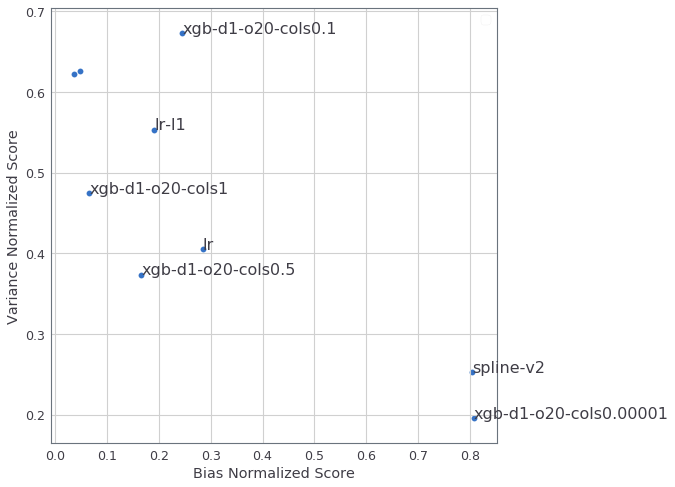

In [91]:
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(8, 8))
x, y, model_names = bias_ns.loc['average'], var_ns.loc['average'], x.index
colors = cm.rainbow(np.linspace(0, 1, len(x)))

ax.scatter(x, y)
# for x1, y1, c, model_name in zip(x, y, colors, model_names):
#     plt.scatter(x1, y1, color=c, label=model_name)

for i, txt in enumerate(model_names):
    ax.annotate(txt, (x[i], y[i]), size=16)

plt.legend()
plt.xlabel('Bias Normalized Score')
plt.ylabel('Variance Normalized Score')

No handles with labels found to put in legend.


Text(0, 0.5, 'Variance Rank')

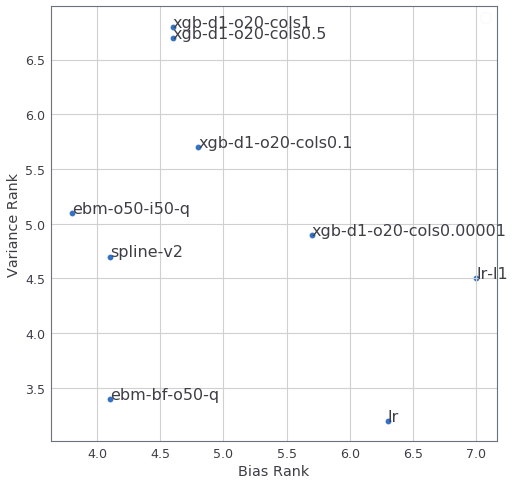

In [92]:
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(8, 8))
x, y, model_names = bias_rank.loc['average'], var_rank.loc['average'], x.index
colors = cm.rainbow(np.linspace(0, 1, len(x)))

ax.scatter(x, y)

for i, txt in enumerate(model_names):
    ax.annotate(txt, (x[i], y[i]), size=16)

plt.legend()
plt.xlabel('Bias Rank')
plt.ylabel('Variance Rank')

### BIas/Var Graph

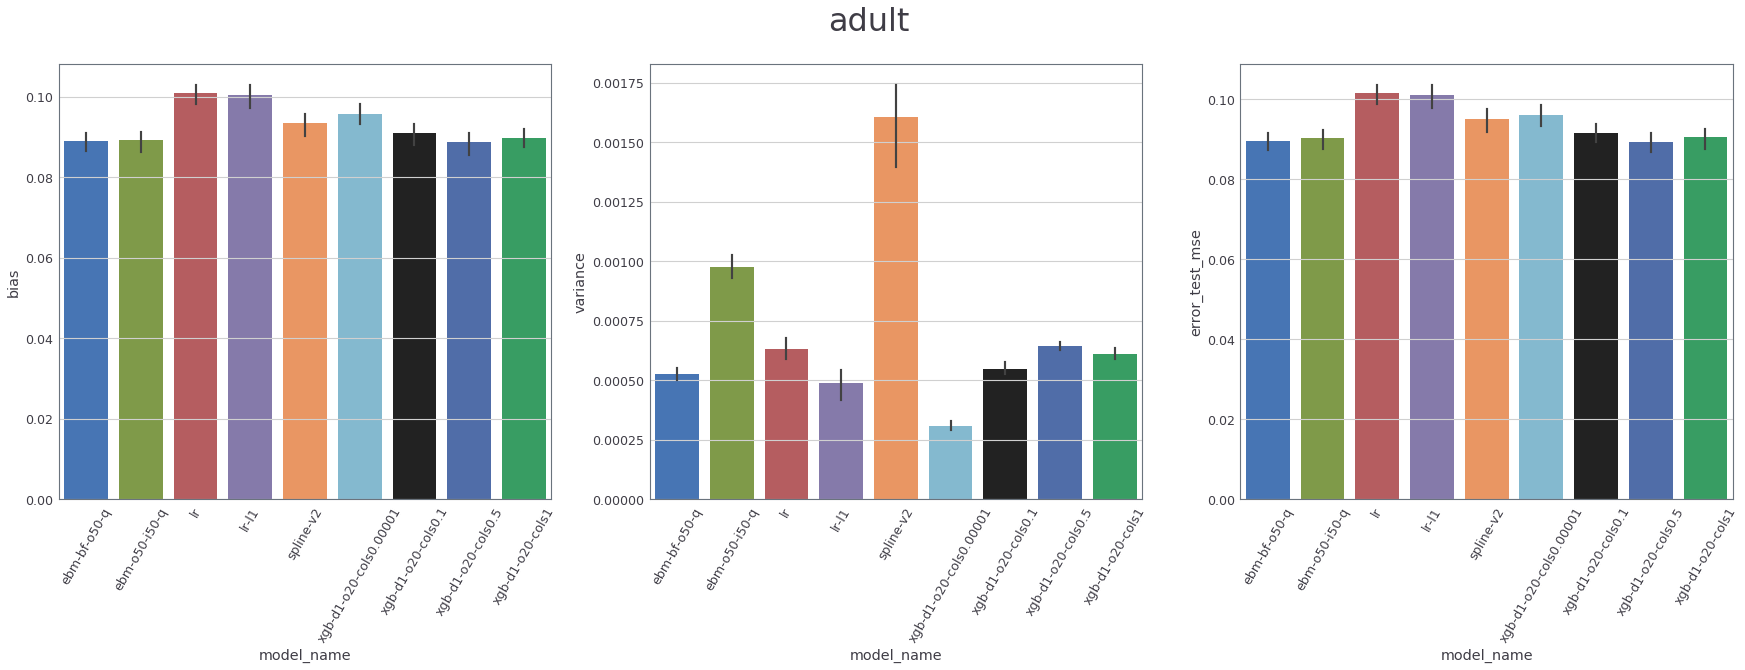

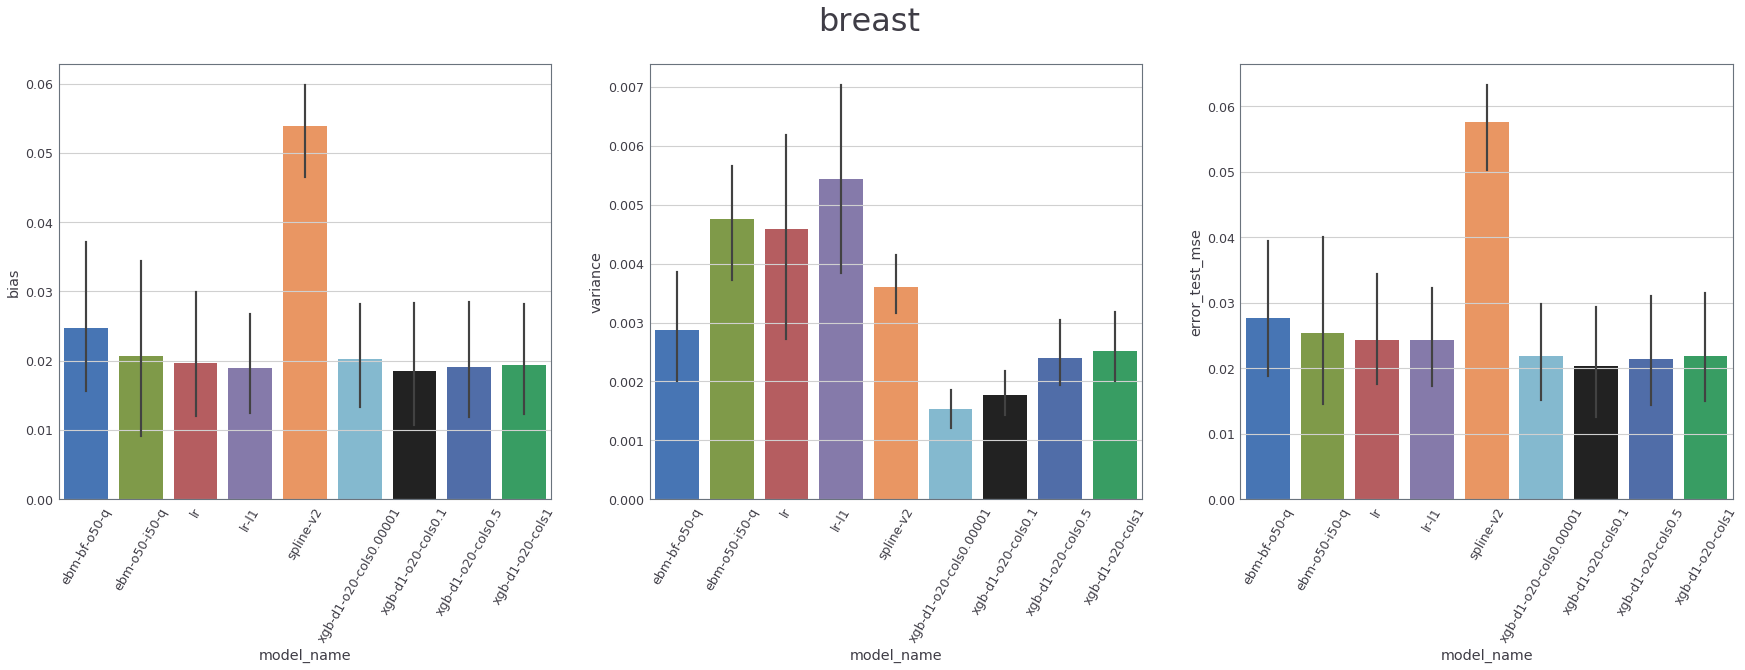

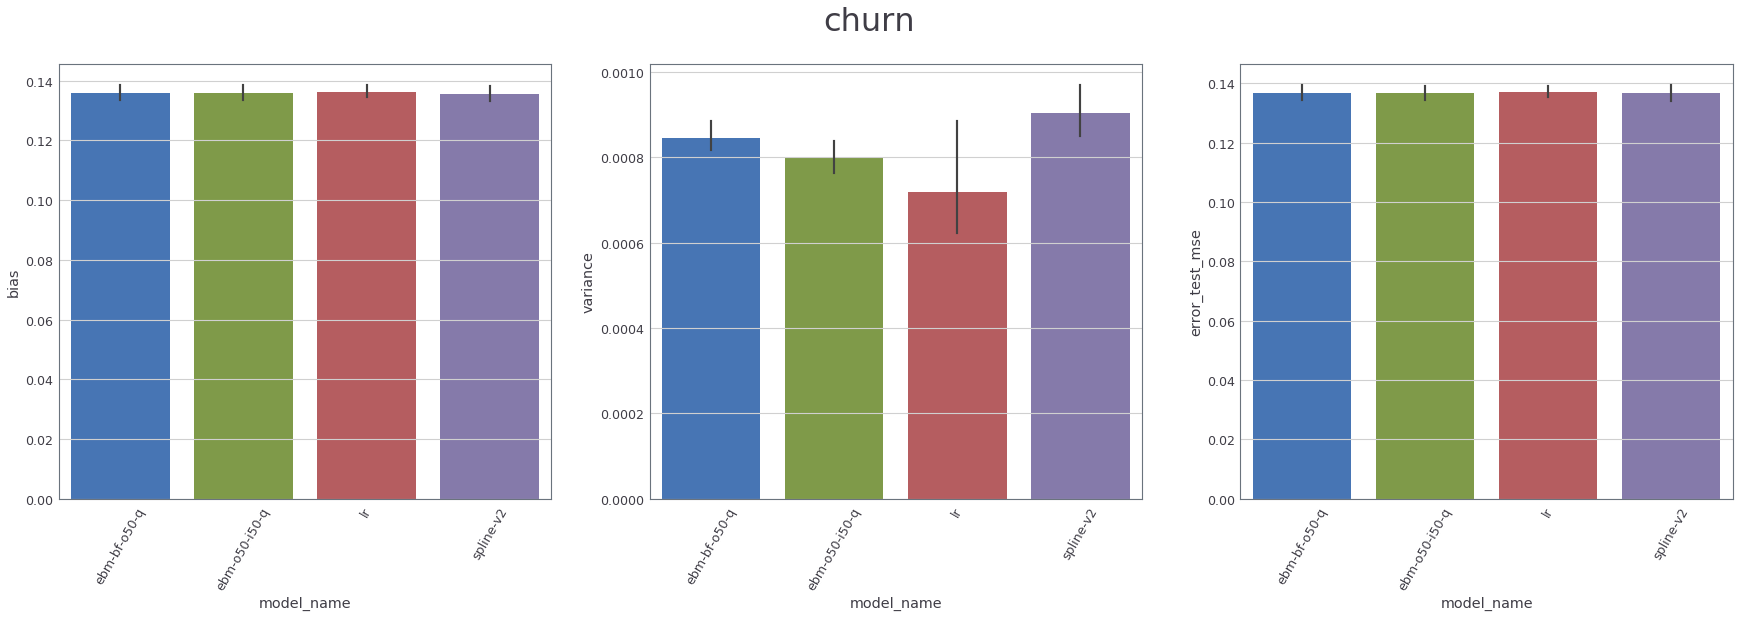

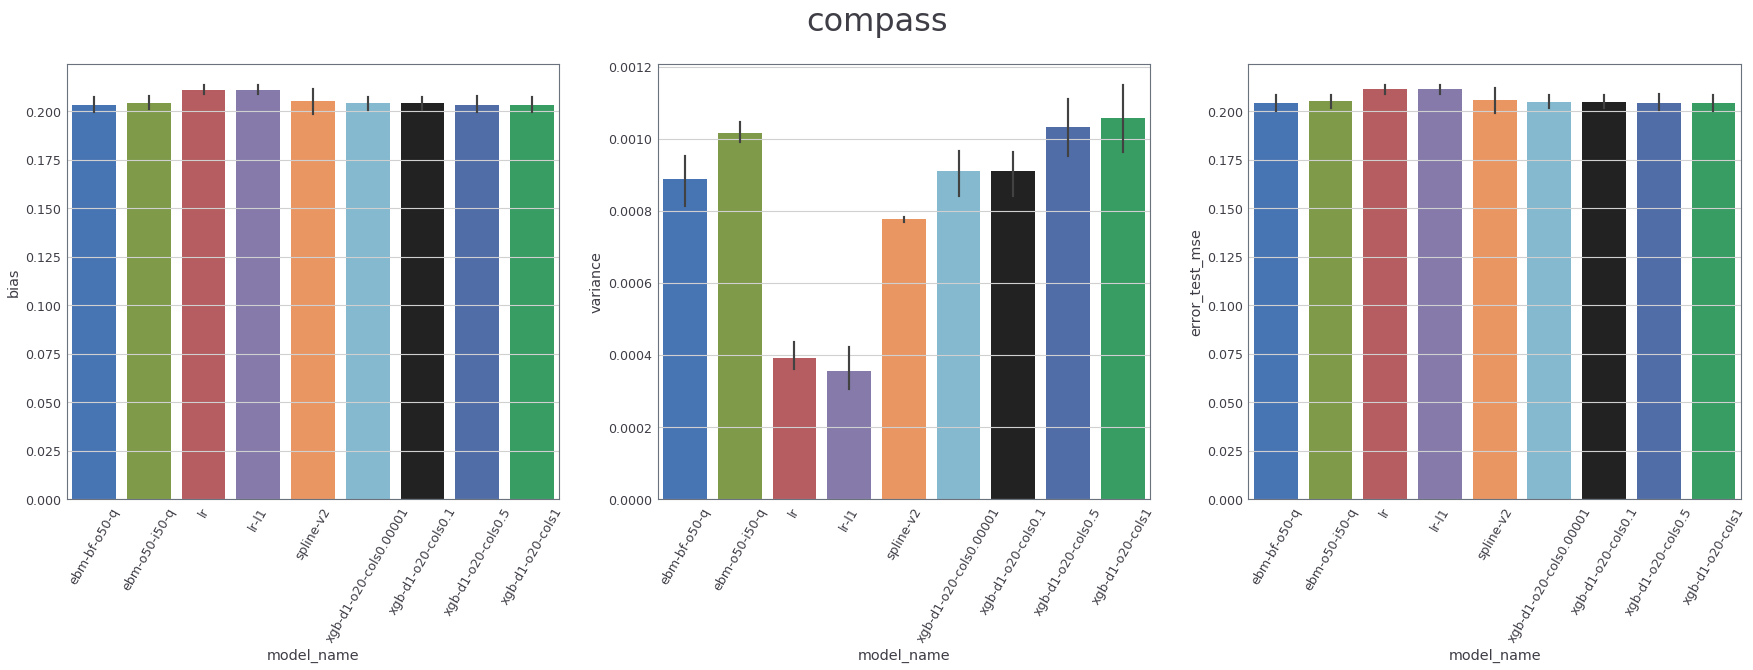

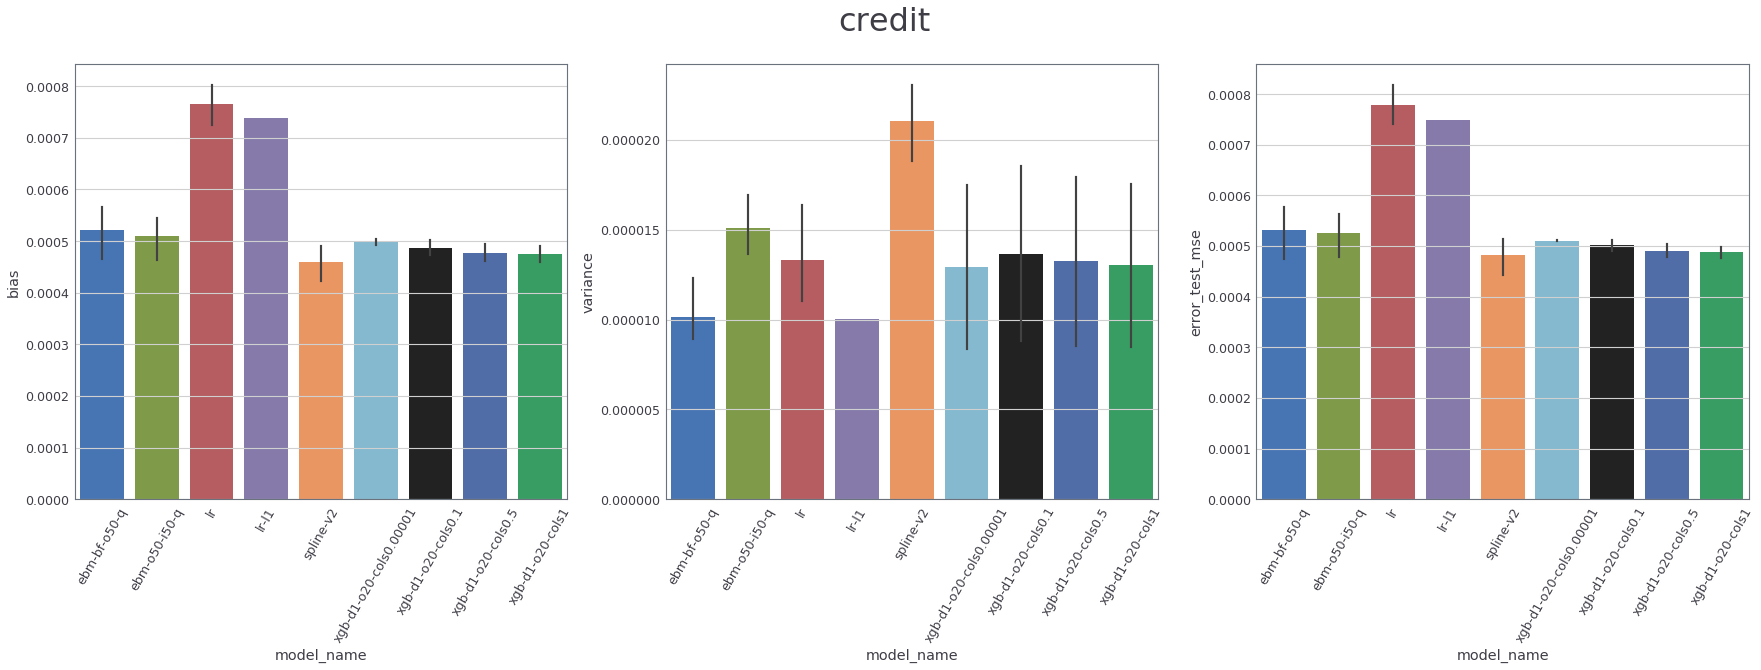

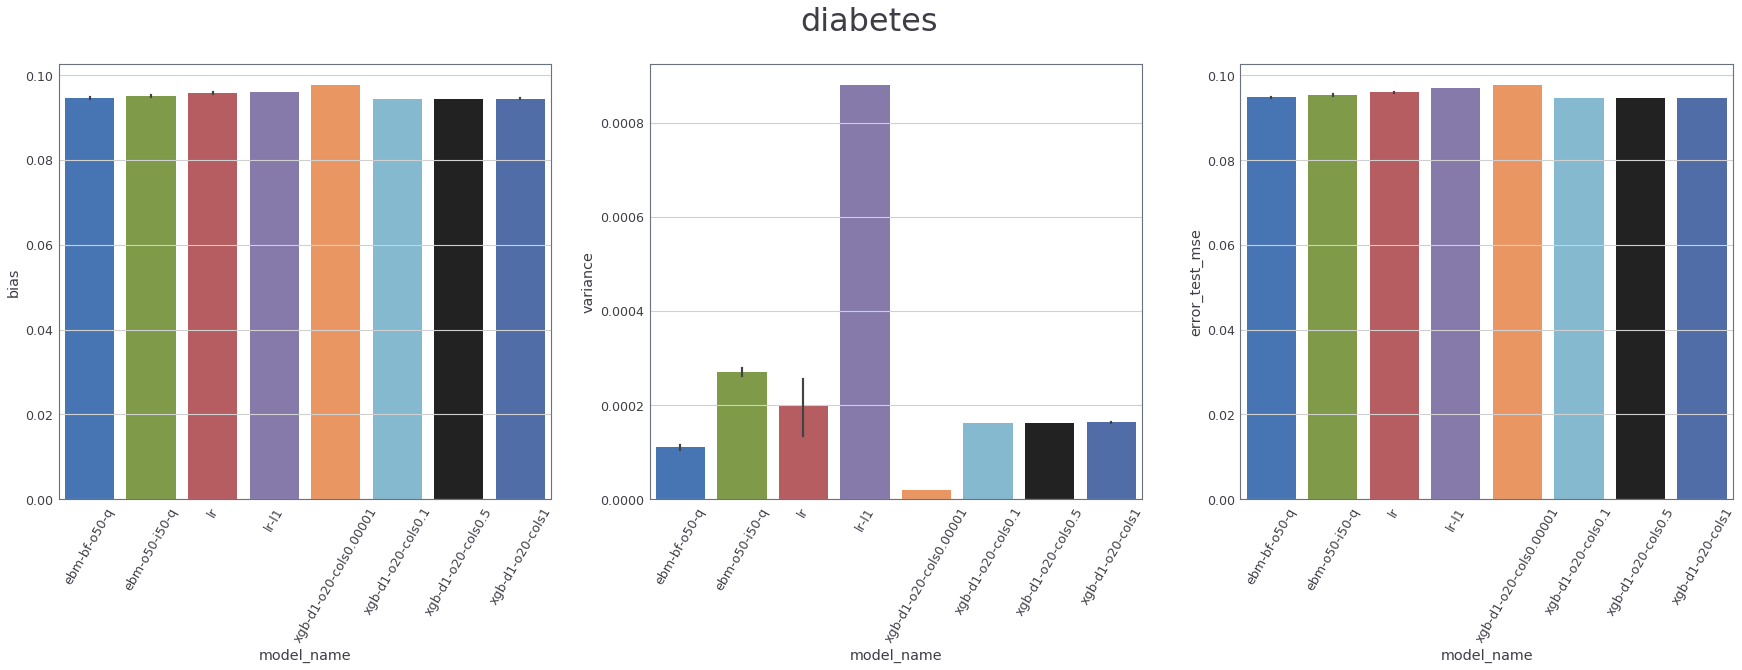

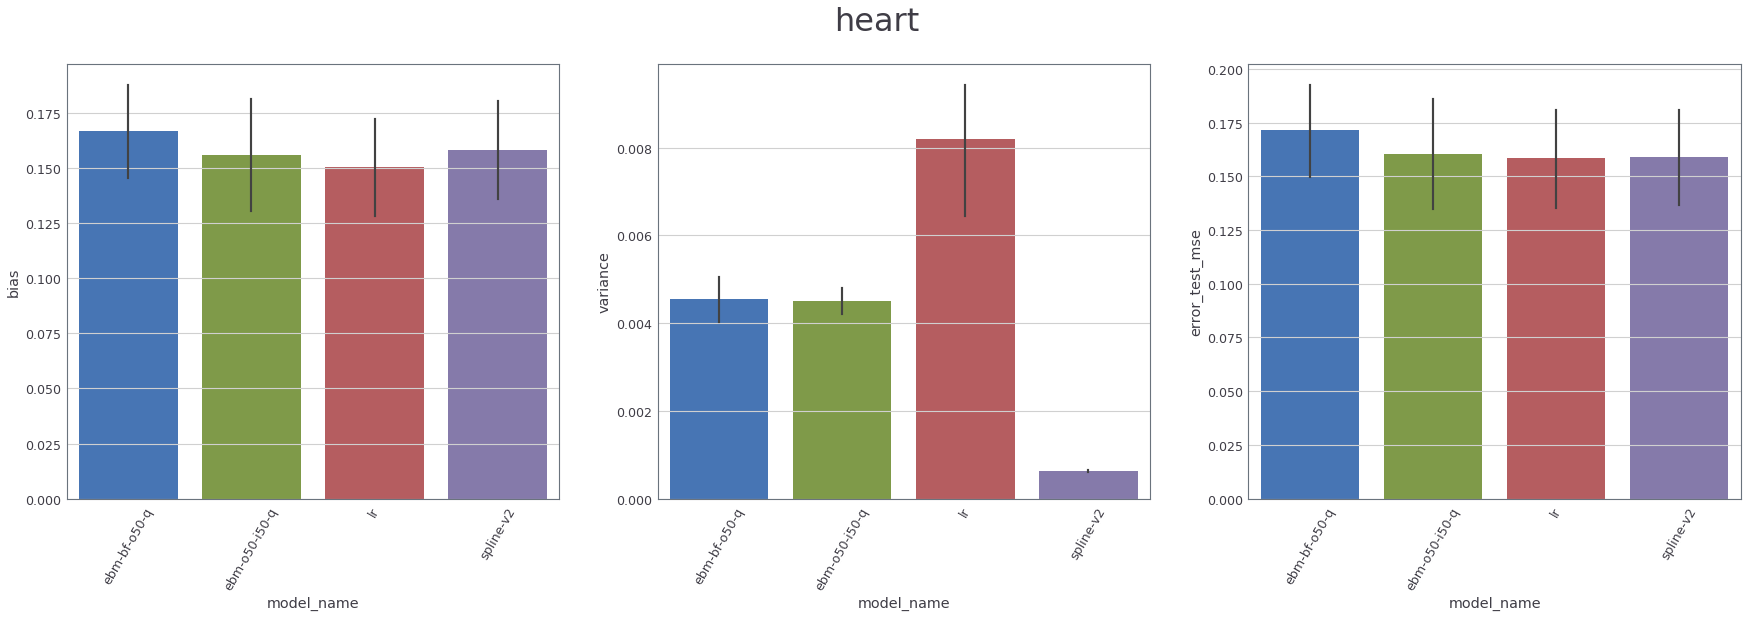

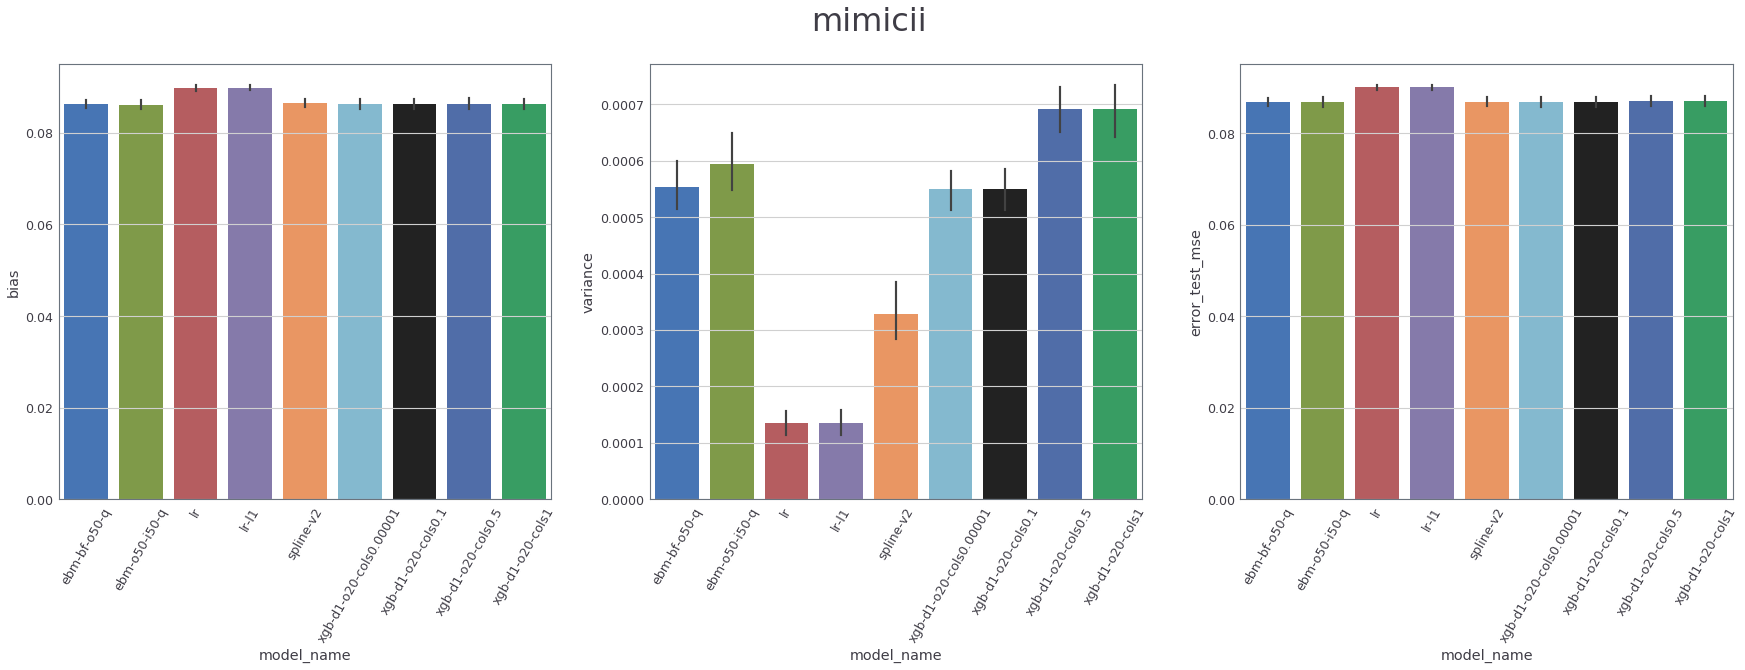

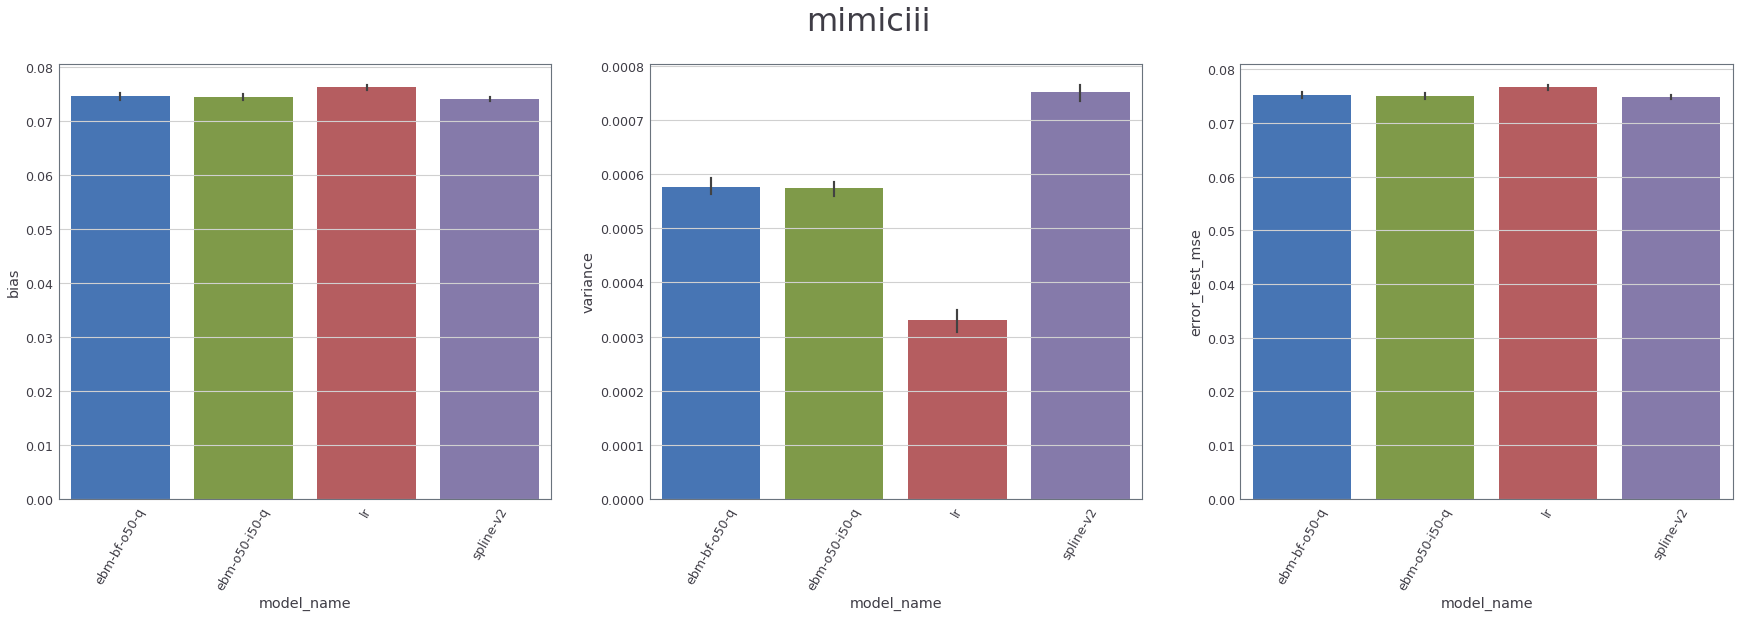

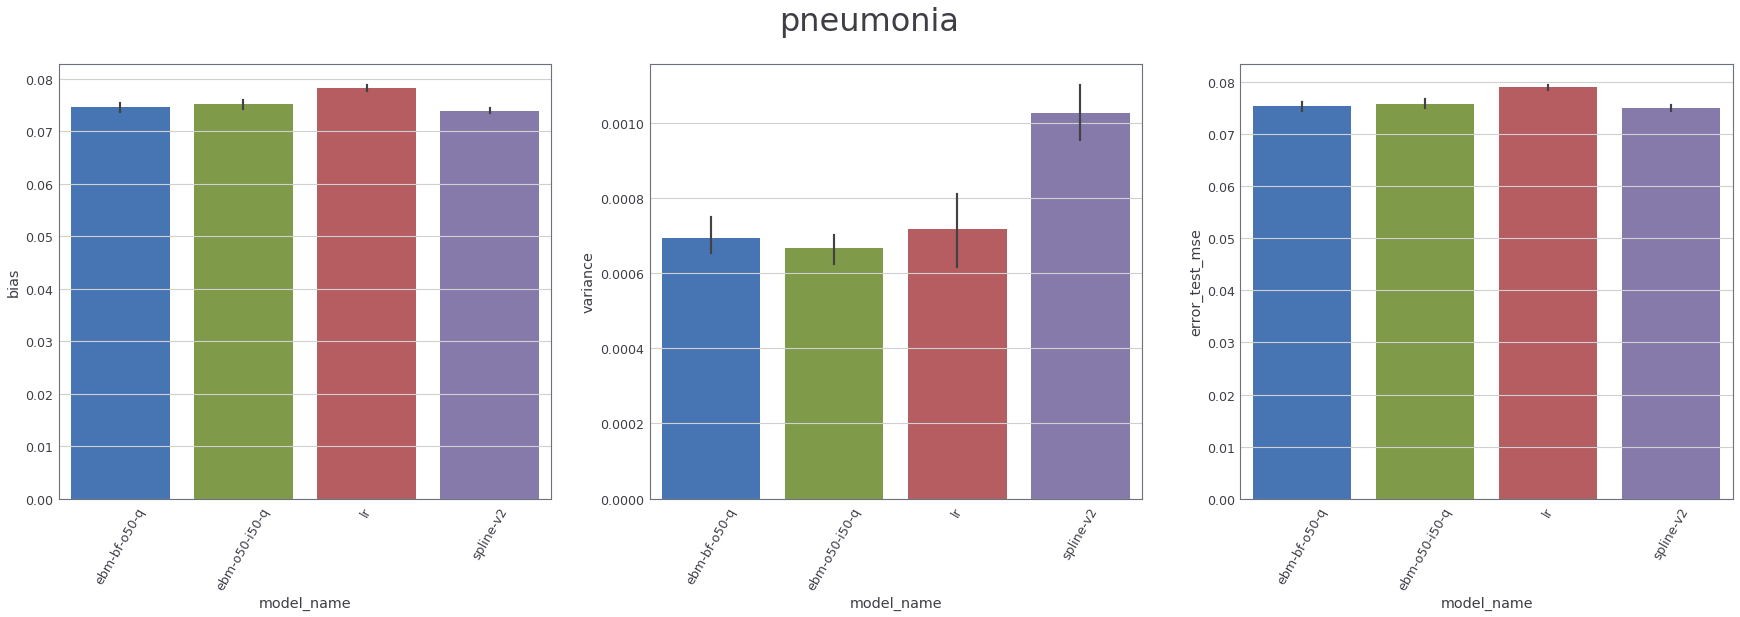

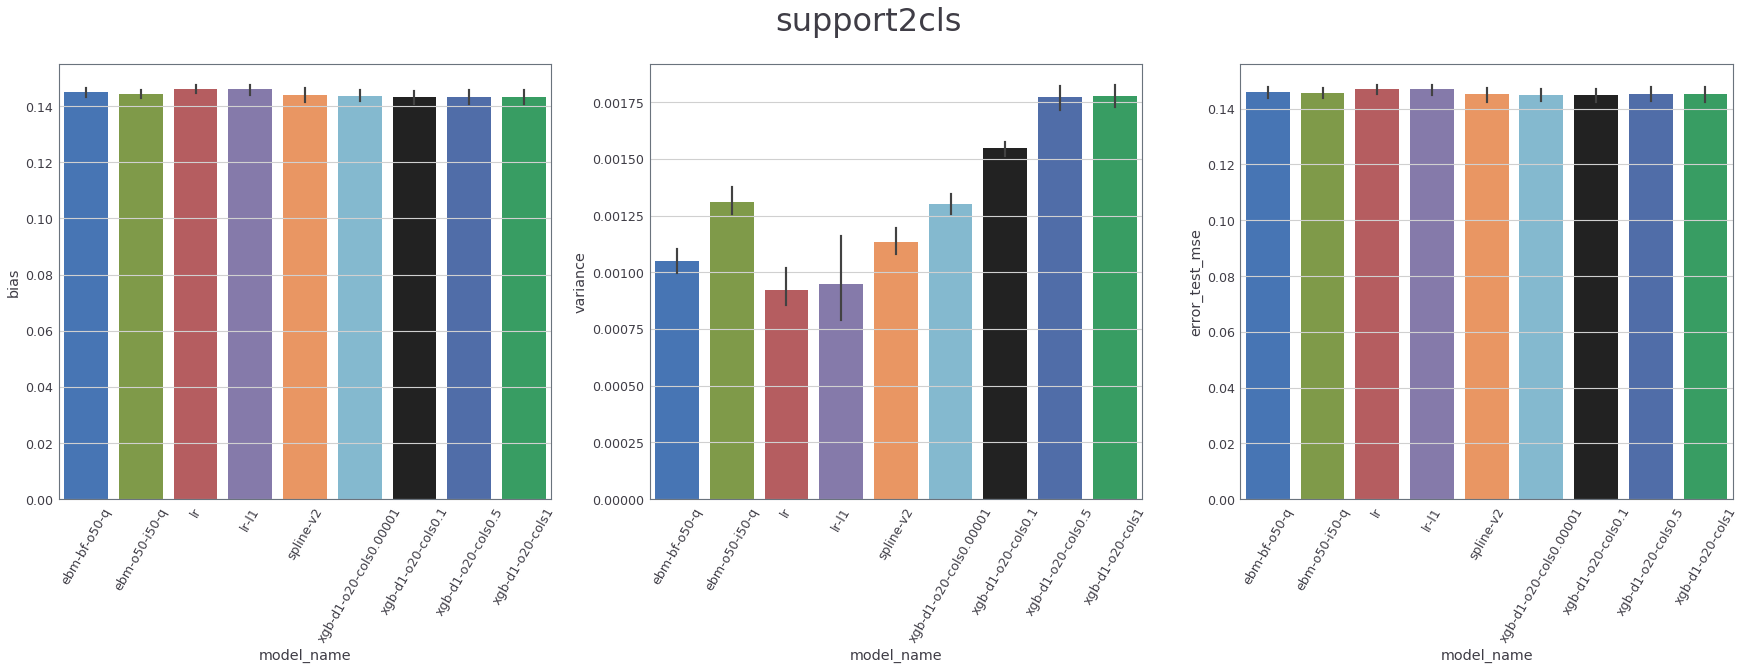

In [93]:
order = None
# order = ['dt', 'bagging-10', 'bagging-25', 'bagging-100']
# order = ['rf-10', 'rf-50', 'rf-200', 'rf-500', 'rf-1000']
# order = ['lr', 'bagging-100', 'rf-1000', 'xgb-d1', 'xgb-d3', 'ebm-main', 'ebm-pair']

for name, group in cls_record_df.groupby('d_name'):
    group = group.sort_values('model_name')
    fig, axes = plt.subplots(1, 3, figsize=(30, 8))
    
#     if name == 'bikeshare':
#         group = group[group.model_name.apply(lambda x: x != 'mlr')]
    
    sns.barplot(data=group, x='model_name', y='bias', ax=axes[0], order=order)    
    sns.barplot(data=group, x='model_name', y='variance', ax=axes[1], order=order)
    
#     second_highest = np.mean(group.variance.values)
#     axes[1].set_ylim(0., second_highest + 0.6 * second_highest)
    
    sns.barplot(data=group, x='model_name', y='error_test_mse', ax=axes[2], order=order)
#     sns.barplot(data=group, x='model_name', y='avg_test_auc', ax=axes[3], order=order)
#     axes[3].set_ylim(group.avg_test_auc.min() - 0.05, 1.)
    
    for ax in axes:
        for tick in ax.get_xticklabels():
            tick.set_rotation(60)
        
    fig.suptitle(name, fontsize=32)
    plt.show()

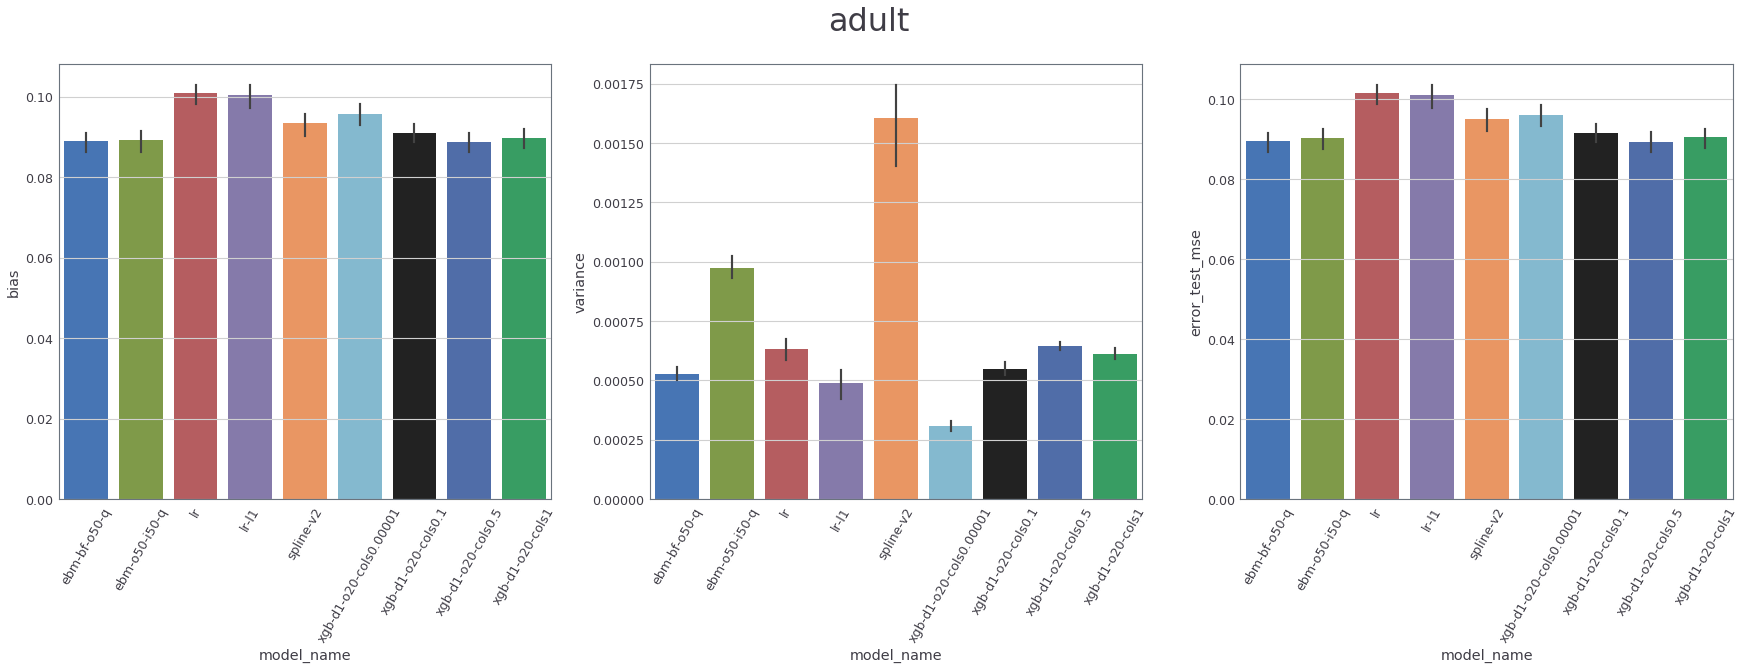

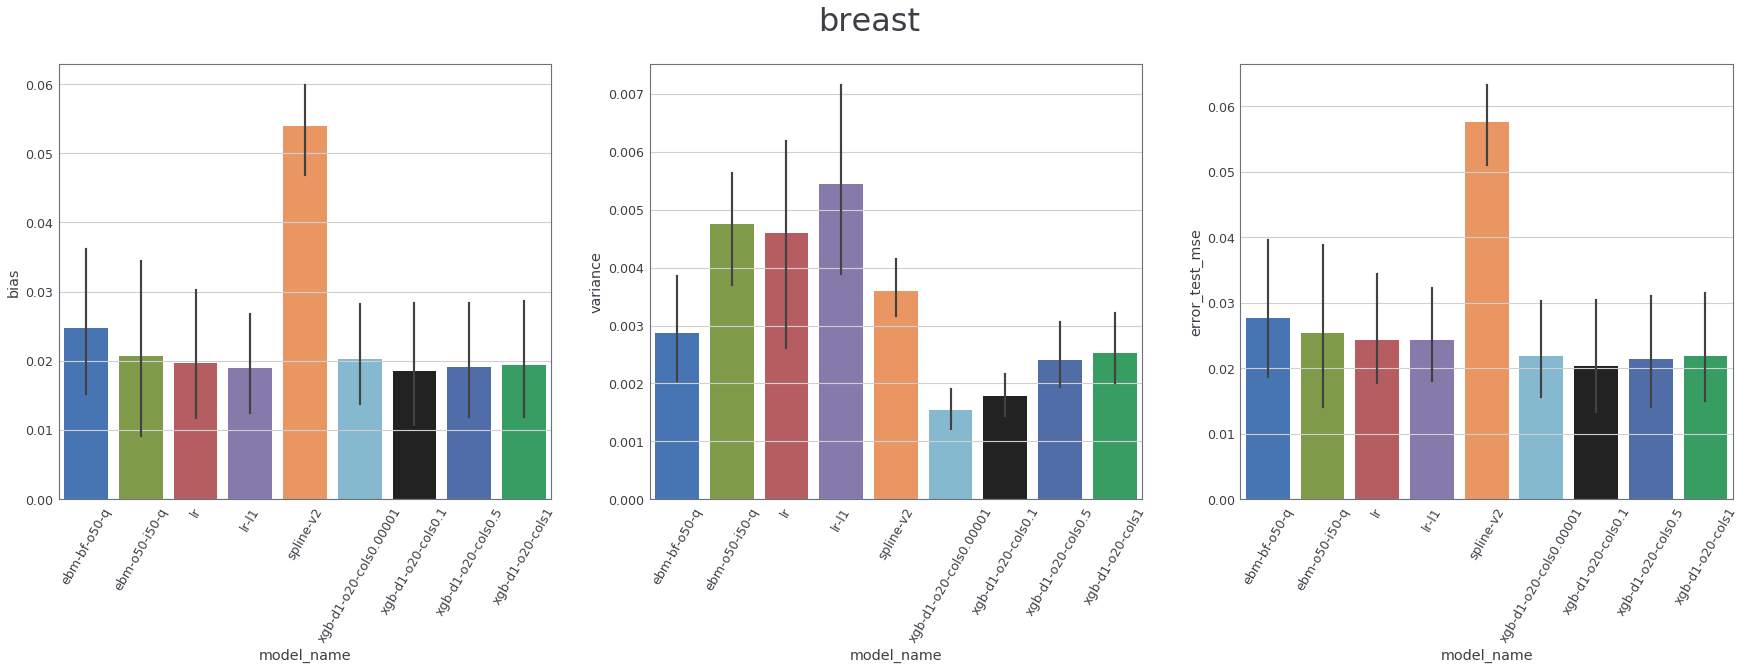

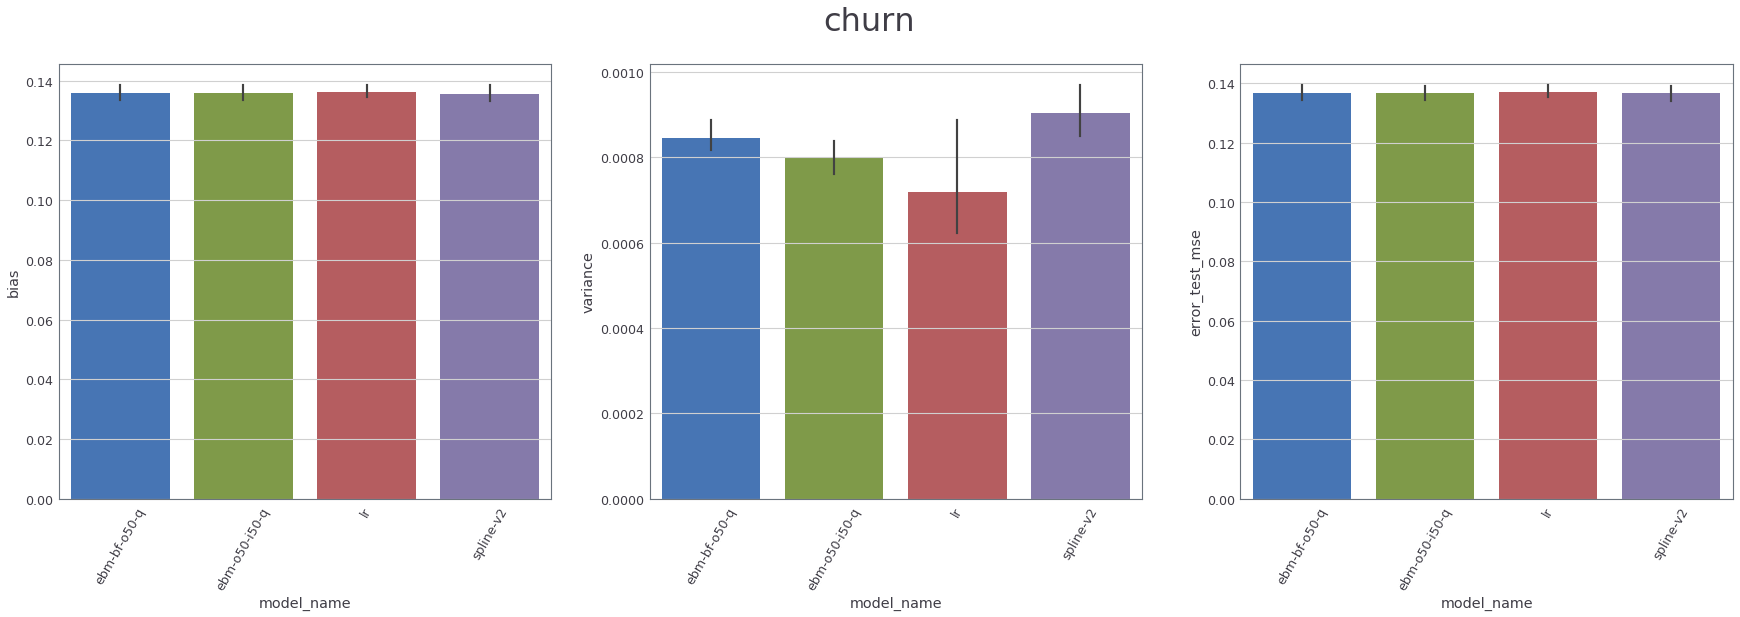

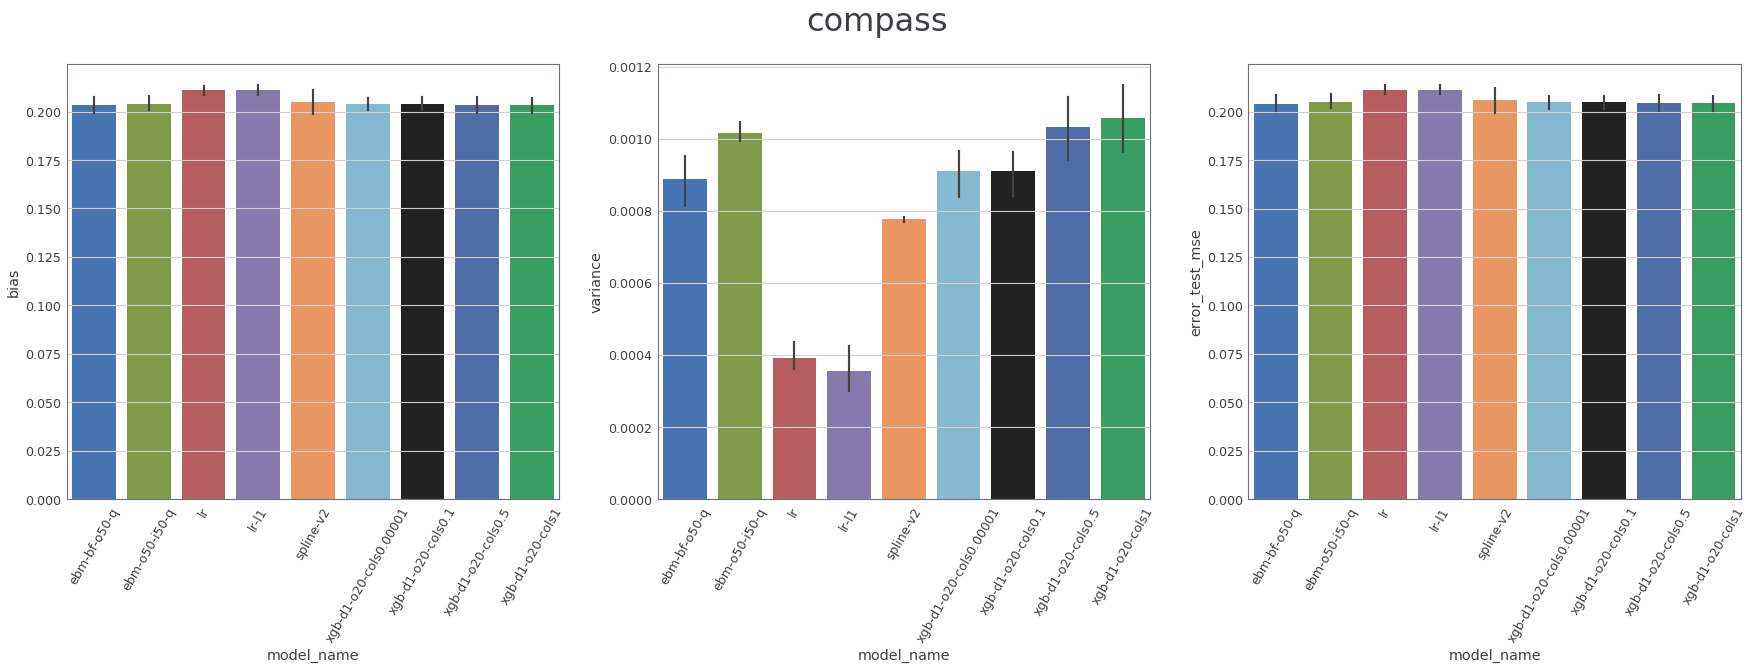

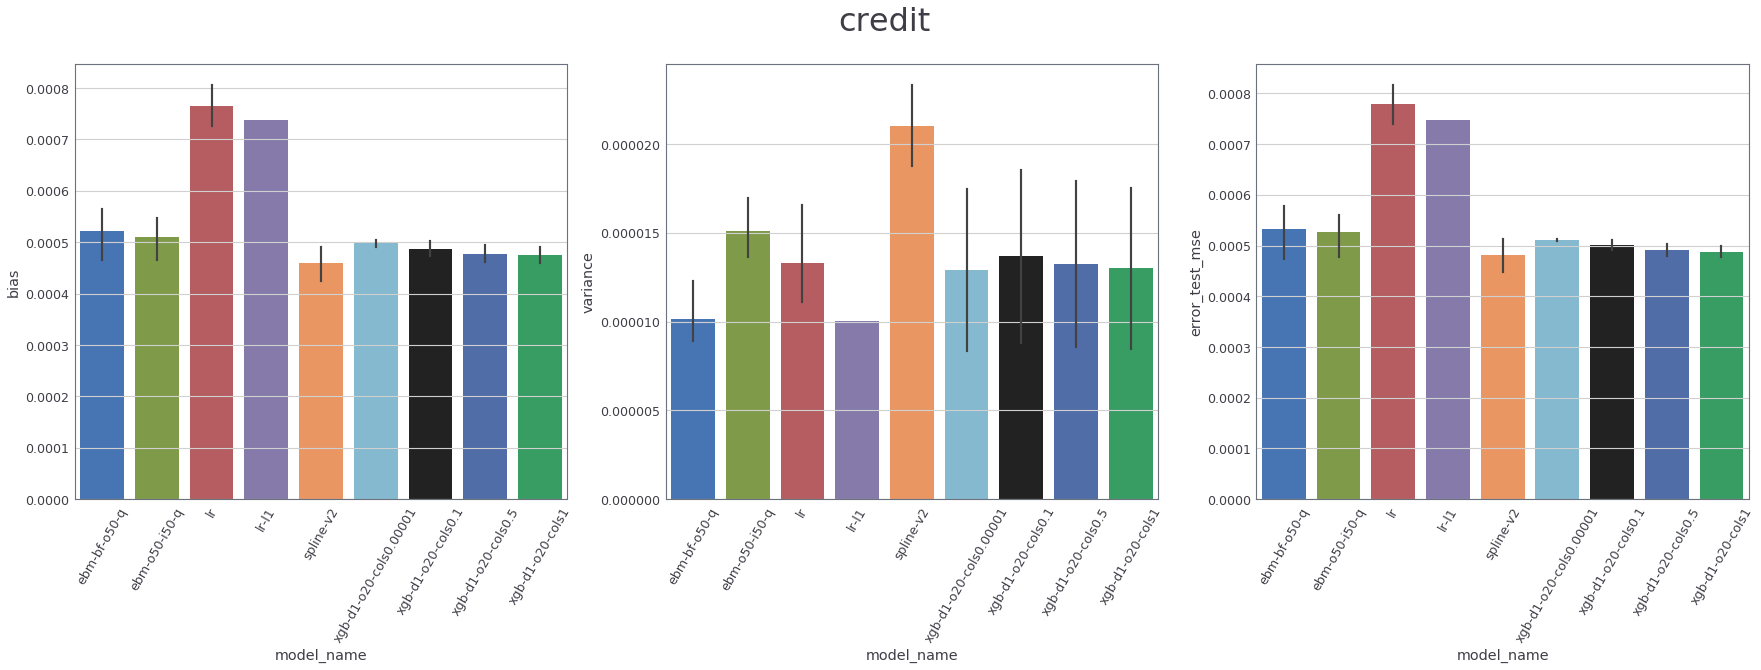

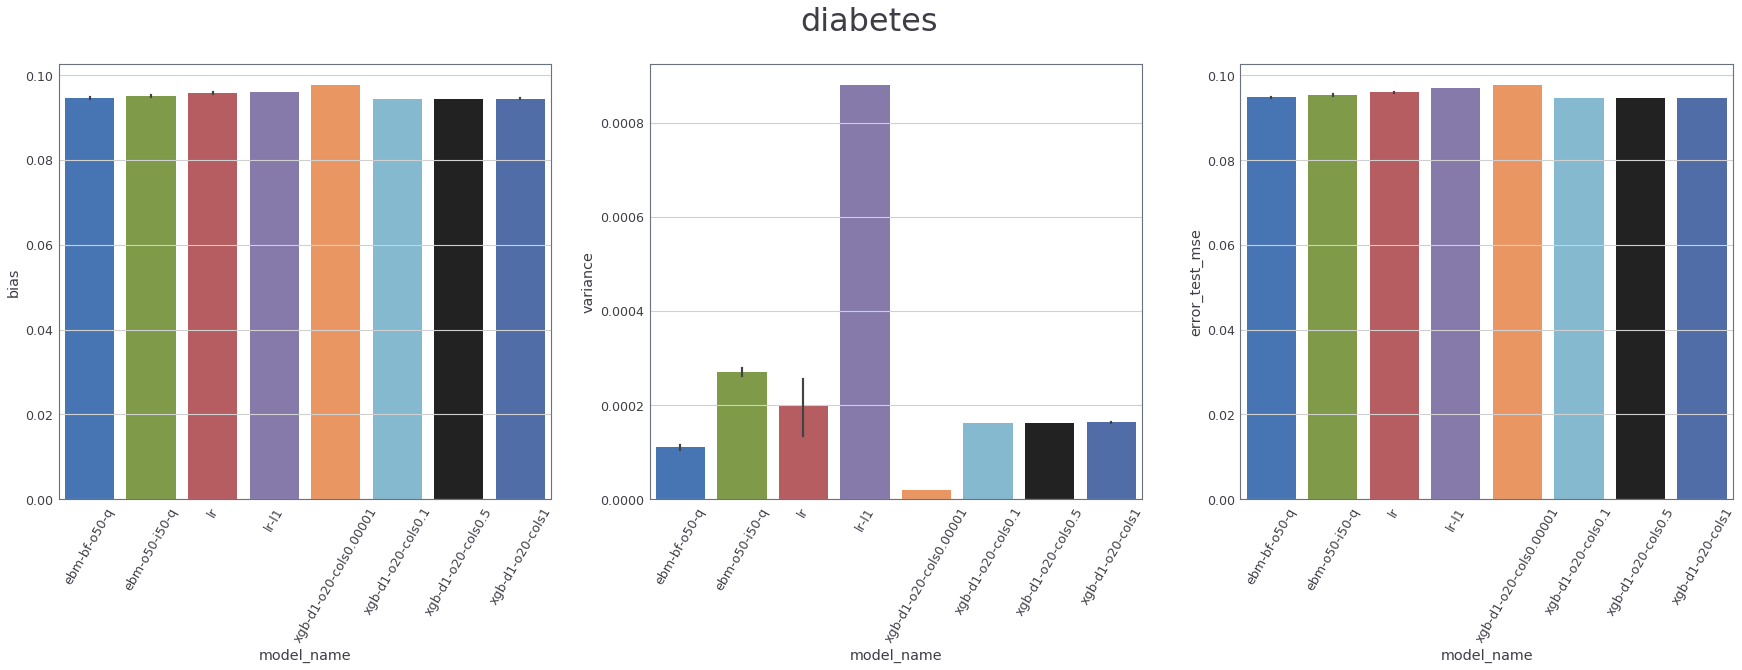

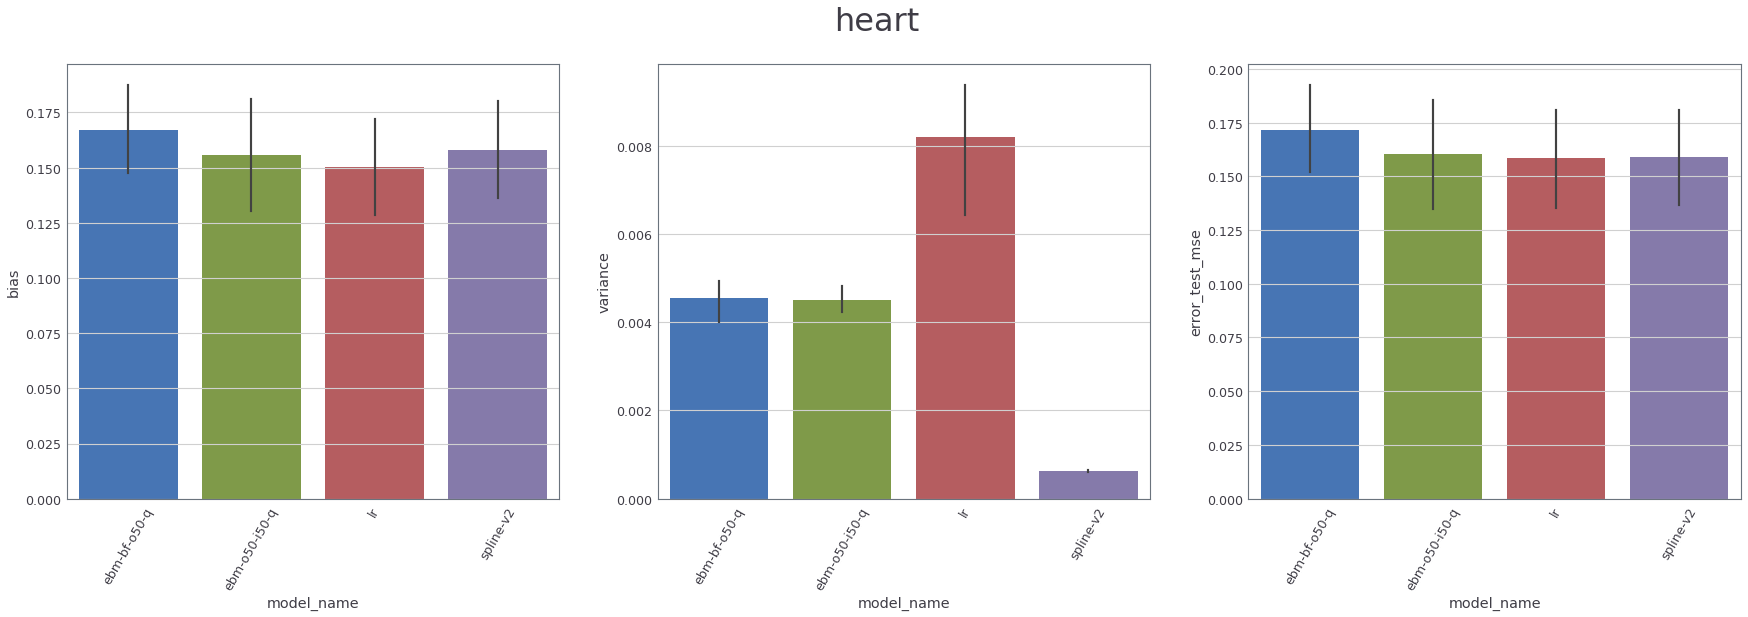

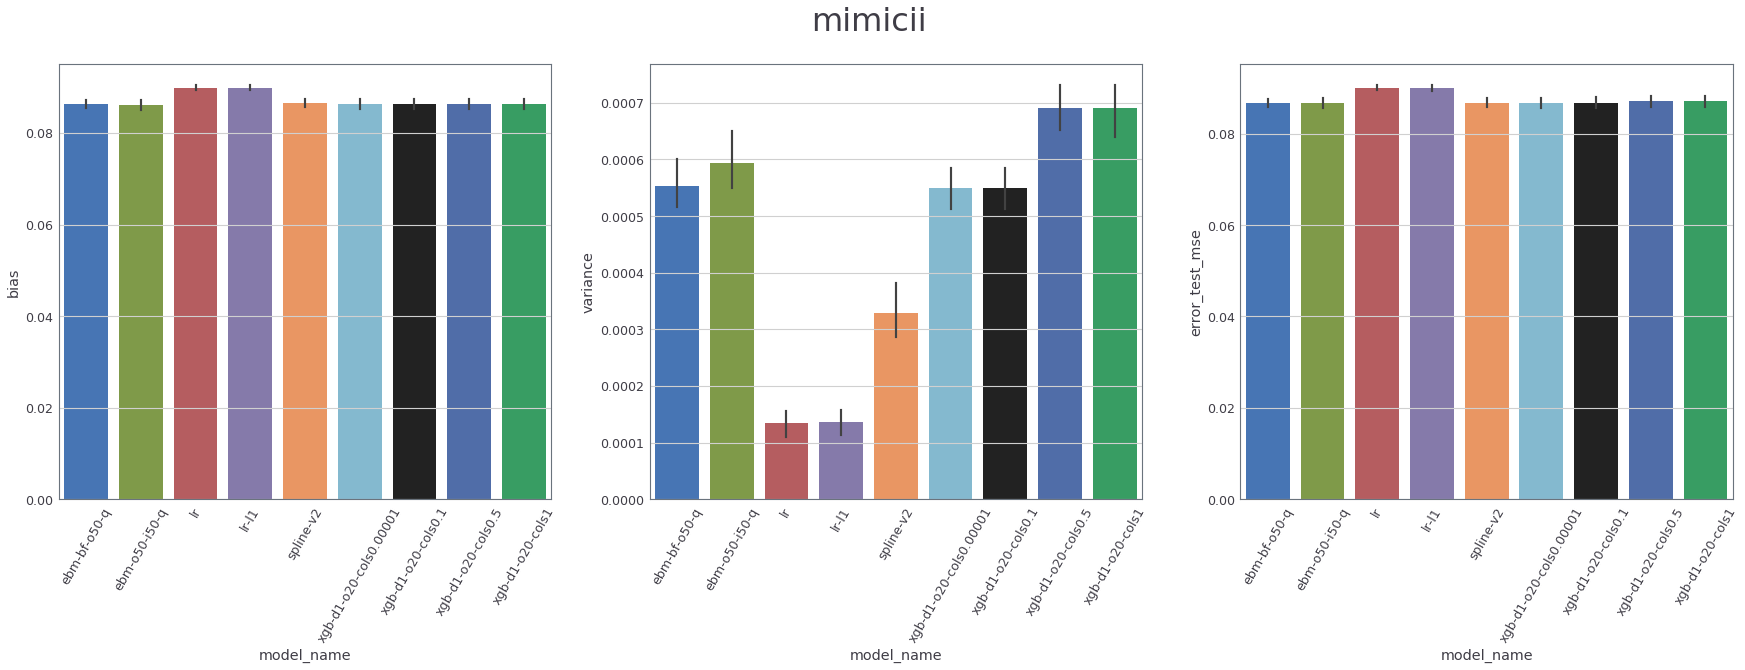

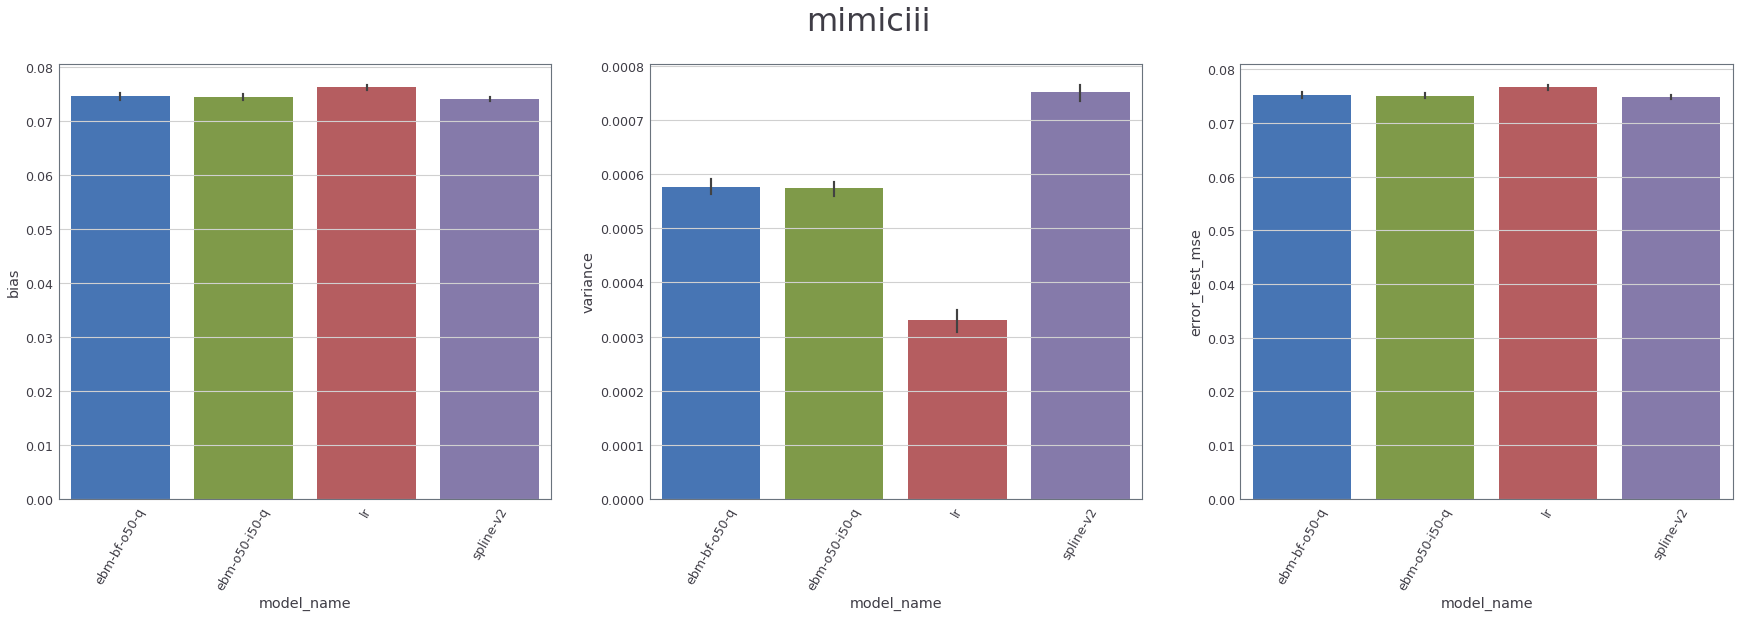

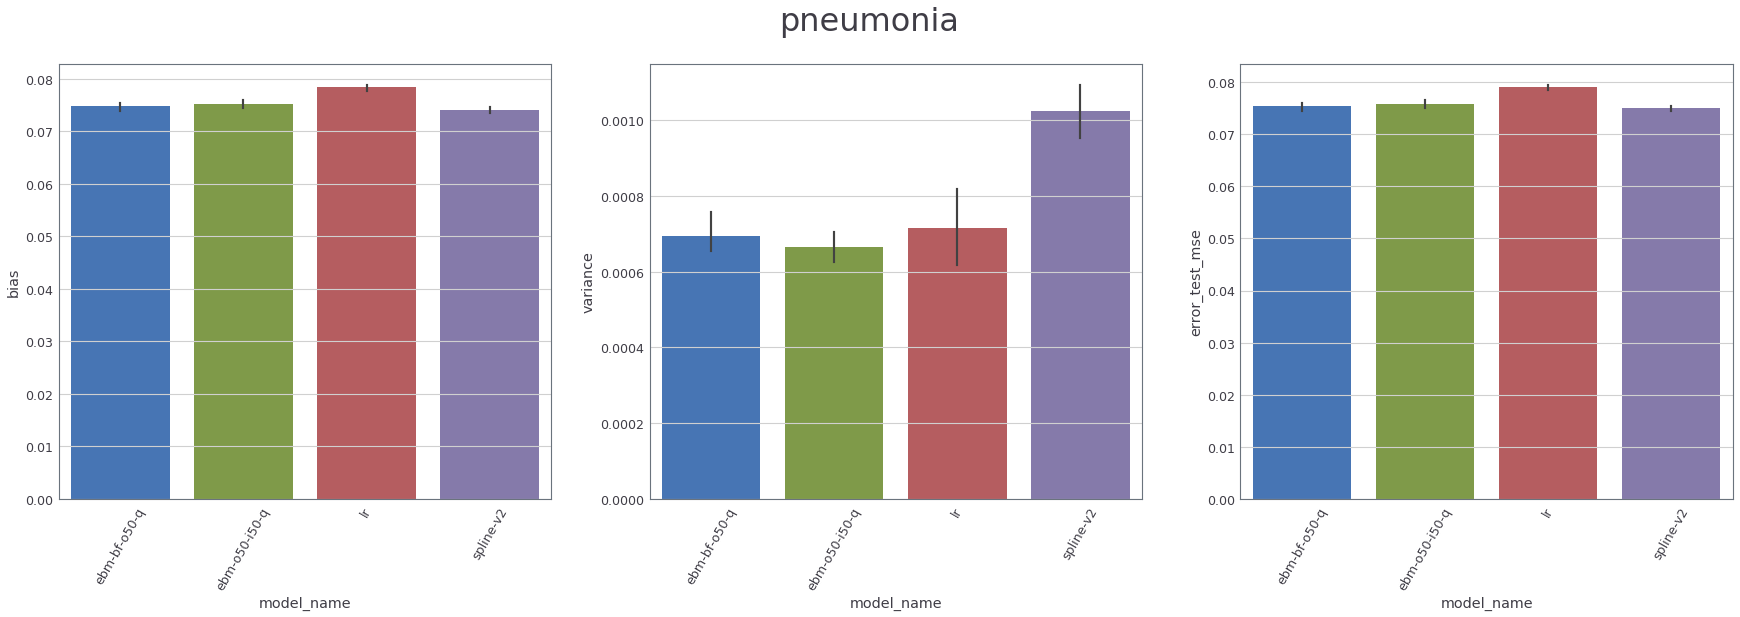

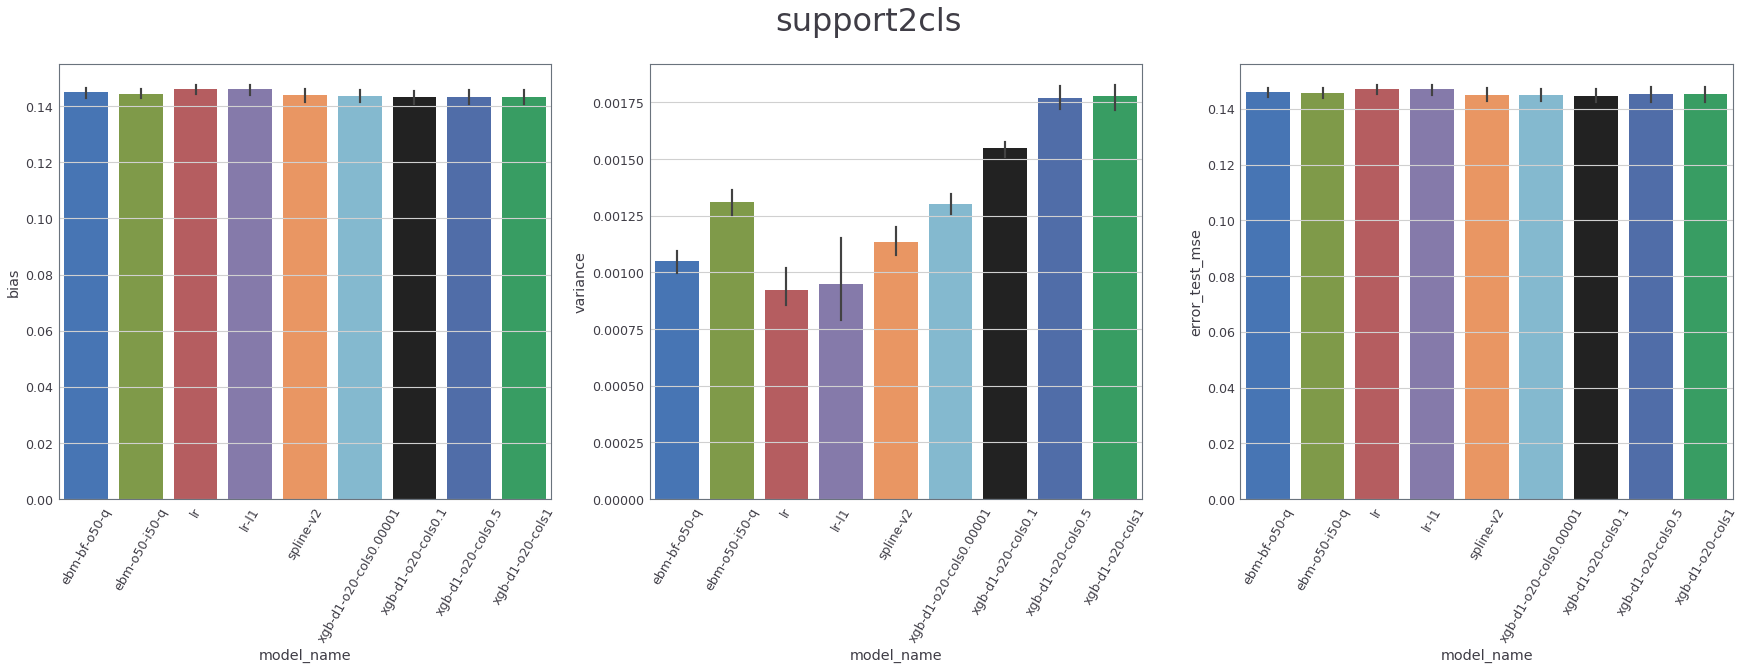

In [94]:
order = None
# order = ['dt', 'bagging-10', 'bagging-25', 'bagging-100']
# order = ['rf-10', 'rf-50', 'rf-200', 'rf-500', 'rf-1000']
# order = ['lr', 'bagging-100', 'rf-1000', 'xgb-d1', 'xgb-d3', 'ebm-main', 'ebm-pair']

for name, group in cls_record_df.groupby('d_name'):
    group = group.sort_values('model_name')
    fig, axes = plt.subplots(1, 3, figsize=(30, 8))
    
#     if name == 'bikeshare':
#         group = group[group.model_name.apply(lambda x: x != 'mlr')]
    
    sns.barplot(data=group, x='model_name', y='bias', ax=axes[0], order=order)    
    sns.barplot(data=group, x='model_name', y='variance', ax=axes[1], order=order)
    
#     second_highest = np.mean(group.variance.values)
#     axes[1].set_ylim(0., second_highest + 0.6 * second_highest)
    
    sns.barplot(data=group, x='model_name', y='error_test_mse', ax=axes[2], order=order)
#     sns.barplot(data=group, x='model_name', y='avg_test_auc', ax=axes[3], order=order)
#     axes[3].set_ylim(group.avg_test_auc.min() - 0.05, 1.)
    
    for ax in axes:
        for tick in ax.get_xticklabels():
            tick.set_rotation(60)
        
    fig.suptitle(name, fontsize=32)
    plt.show()

### Combined Bias/Var graph

In [ ]:
%matplotlibtlib inline

In [ ]:
order = None
# order = ['dt', 'bagging-10', 'bagging-25', 'bagging-100']
# order = ['rf-10', 'rf-50', 'rf-200', 'rf-500', 'rf-1000']
# order = ['lr', 'dt', 'bagging-100', 'rf-10', 'rf-1000', 'xgb-d1', 'xgb-d2', 'xgb-d3', 'ebm-main', 'ebm-pair']
# order = ['lr', 'dt', 'bagging-100', 'rf-1000-d5', 'rf-1000-d10', 'rf-1000', 'xgb-d3', 'ebm-main', 'ebm-pair']

for name, group in cls_record_df.sort_values('model_name').groupby('d_name'):
    fig, ax = plt.subplots(figsize=(22, 10))

    sns.set_color_codes("pastel")
    sns.barplot(x="model_name", y="error_test_mse", data=group,
                label="Variance", color="b", order=order)

    sns.set_color_codes("muted")
    sns.barplot(x="model_name", y="bias", data=group,
                label="Bias+Noise", color="r", order=order)

    ax.legend(ncol=2, loc="best", frameon=True)

    sns.despine(left=True, bottom=True)

    fig.suptitle(name, fontsize=32)
    plt.show()

# OLD

In [115]:
record_df = record_df[record_df.d_name != 'credit']

In [116]:
record_df.to_csv('results/bias_var_tradeoff.csv', header=None)

In [117]:
avg_prob_x = record_df.groupby(['d_name', 'model_name', 'split_idx']).test_prob.apply(lambda x: np.mean(x))
avg_prob_x.name = 'avg_prob_x'

record_df = record_df.merge(avg_prob_x, on=['d_name', 'model_name', 'split_idx'], how='outer')

variance = record_df.groupby(['d_name', 'model_name', 'split_idx']).test_prob.apply(lambda x: np.mean(np.var(np.array(x), axis=0)))
variance.name = 'variance'

record_df = record_df.merge(variance, on=['d_name', 'model_name', 'split_idx'], how='outer')

record_df['bias'] = record_df.apply(lambda x: np.mean((x.avg_prob_x - x.y_test.values) ** 2), axis=1)
# record_df['variance'] = record_df.apply(lambda x: np.sum((x.test_prob) ** 2), axis=1)
record_df['error'] = record_df.apply(lambda x: np.mean((x.test_prob - x.y_test.values) ** 2), axis=1)

record_df['auroc'] = record_df.apply(lambda x: roc_auc_score(x.y_test.values.astype(int), x.test_prob), axis=1)

record_df.head()

,d_name,fit_time,model_name,split_idx,sub_idx,test_prob,y_test,avg_prob_x,variance,bias,error,auroc
0,pneumonia,0.1,lr,0,0,"[0.0019403966939916778, 0.13539493725080312, 0...",4983 0 7328 0 7670 0 671 0 4144 ...,"[0.002548400079997235, 0.11486232208483393, 0....",0.000735,0.078689,0.079145,0.835612
1,pneumonia,0.1,lr,0,1,"[0.002235294635898577, 0.12614752926163483, 0....",4983 0 7328 0 7670 0 671 0 4144 ...,"[0.002548400079997235, 0.11486232208483393, 0....",0.000735,0.078689,0.079939,0.831495
2,pneumonia,0.2,lr,0,2,"[0.0023599269247155464, 0.10333131668972878, 0...",4983 0 7328 0 7670 0 671 0 4144 ...,"[0.002548400079997235, 0.11486232208483393, 0....",0.000735,0.078689,0.079473,0.825405
3,pneumonia,0.1,lr,0,3,"[0.0021084825971422858, 0.12162539400431853, 0...",4983 0 7328 0 7670 0 671 0 4144 ...,"[0.002548400079997235, 0.11486232208483393, 0....",0.000735,0.078689,0.079704,0.827021
4,pneumonia,0.1,lr,0,4,"[0.002733550538891471, 0.12278327387405757, 0....",4983 0 7328 0 7670 0 671 0 4144 ...,"[0.002548400079997235, 0.11486232208483393, 0....",0.000735,0.078689,0.079775,0.832719


In [118]:
summary_df = record_df.groupby(['d_name', 'model_name', 'split_idx'])['variance'].apply(lambda x: np.mean(x)).reset_index()

summary_df['bias'] = record_df.groupby(['d_name', 'model_name', 'split_idx'])['bias'].apply(lambda x: np.mean(x)).values
summary_df['error'] = record_df.groupby(['d_name', 'model_name', 'split_idx'])['error'].apply(lambda x: np.mean(x)).values
summary_df['auroc'] = record_df.groupby(['d_name', 'model_name', 'split_idx'])['auroc'].apply(lambda x: np.mean(x)).values

In [119]:
summary_df.head()

,d_name,model_name,split_idx,variance,bias,error,auroc
0,adult,ebm-main,0,0.001008,0.095430,0.096437,0.913165
1,adult,ebm-main,1,0.001879,0.094125,0.096003,0.914043
2,adult,ebm-main,2,0.001694,0.092588,0.094282,0.915546
3,adult,ebm-main,3,0.001634,0.094156,0.095789,0.915556
4,adult,ebm-main,4,0.001650,0.093497,0.095147,0.915489


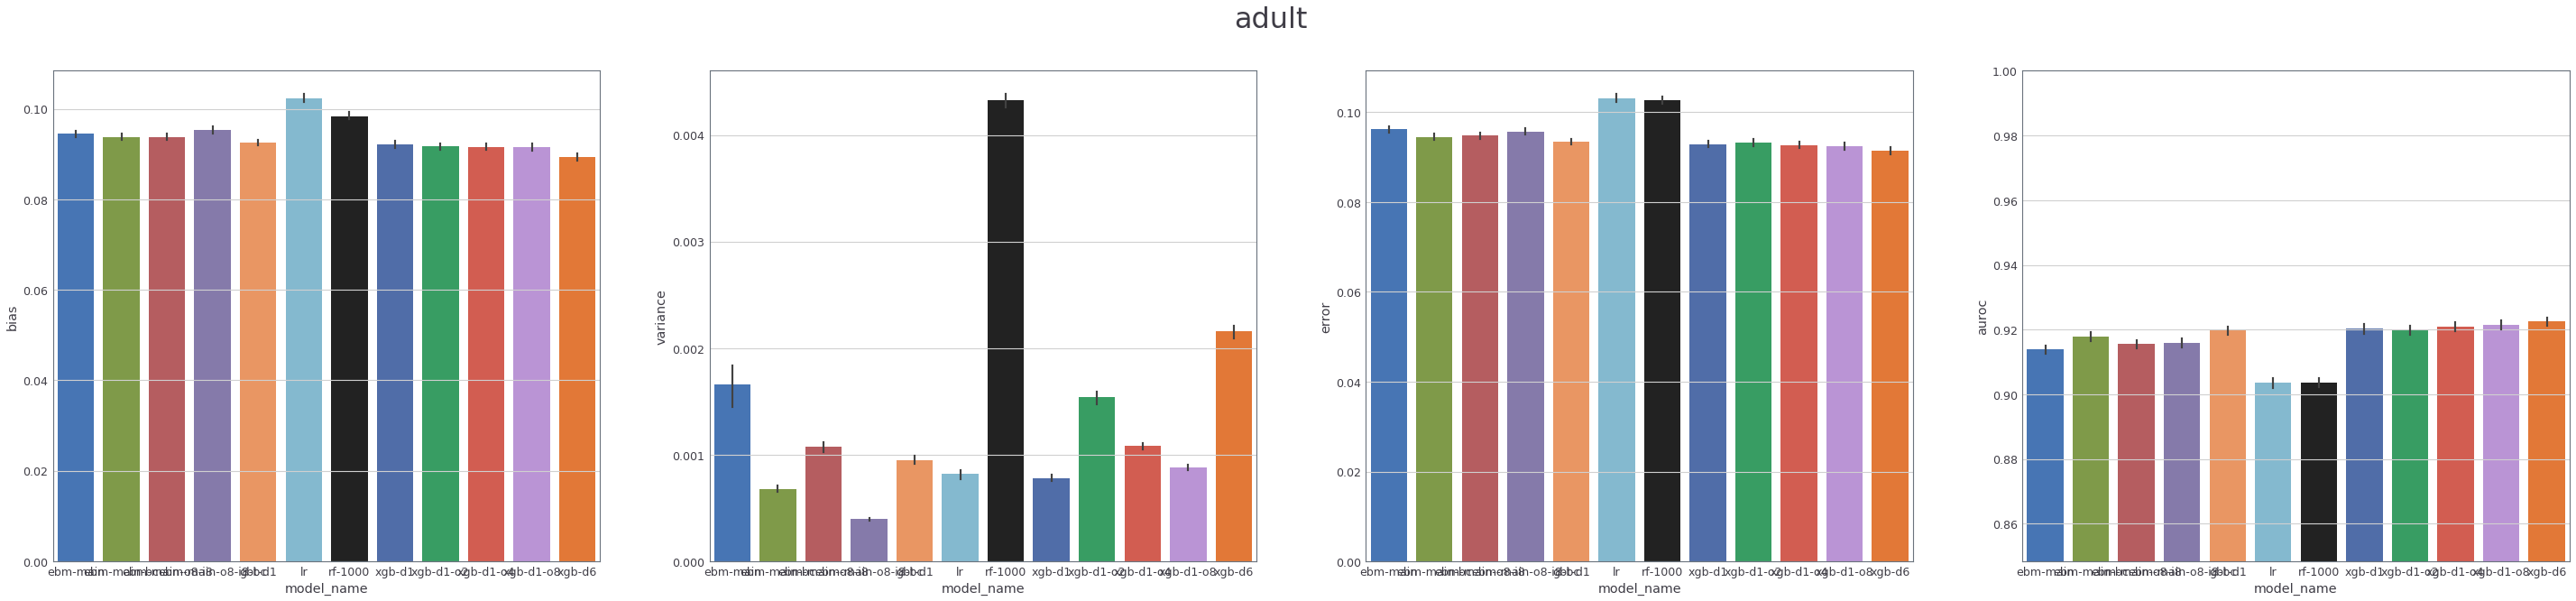

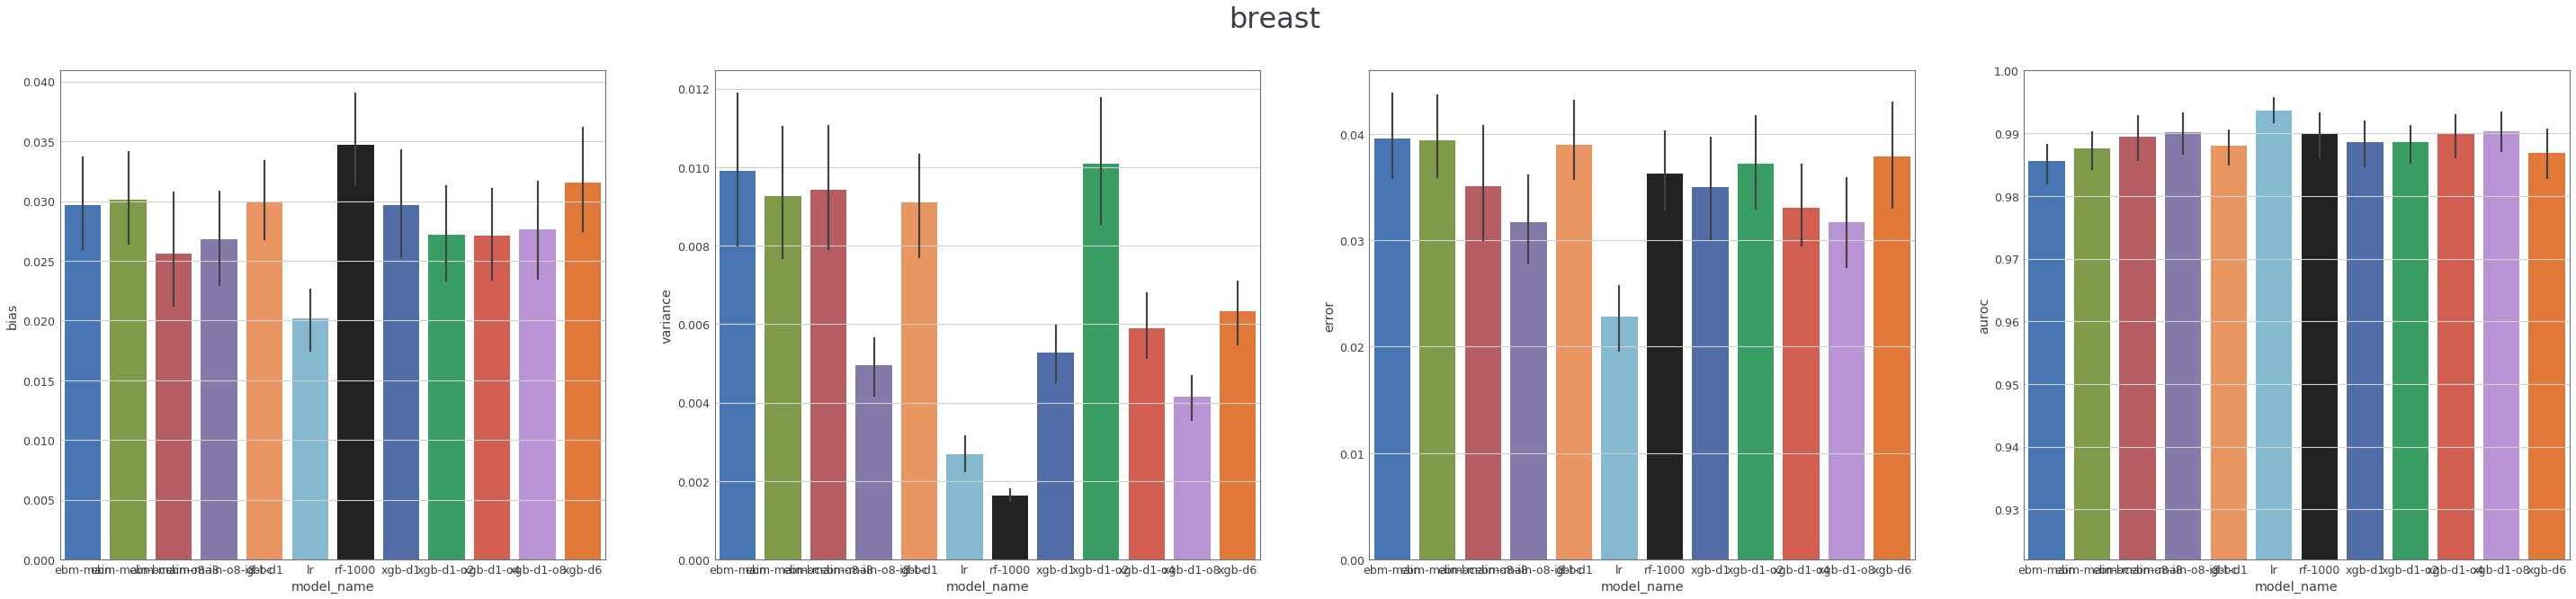

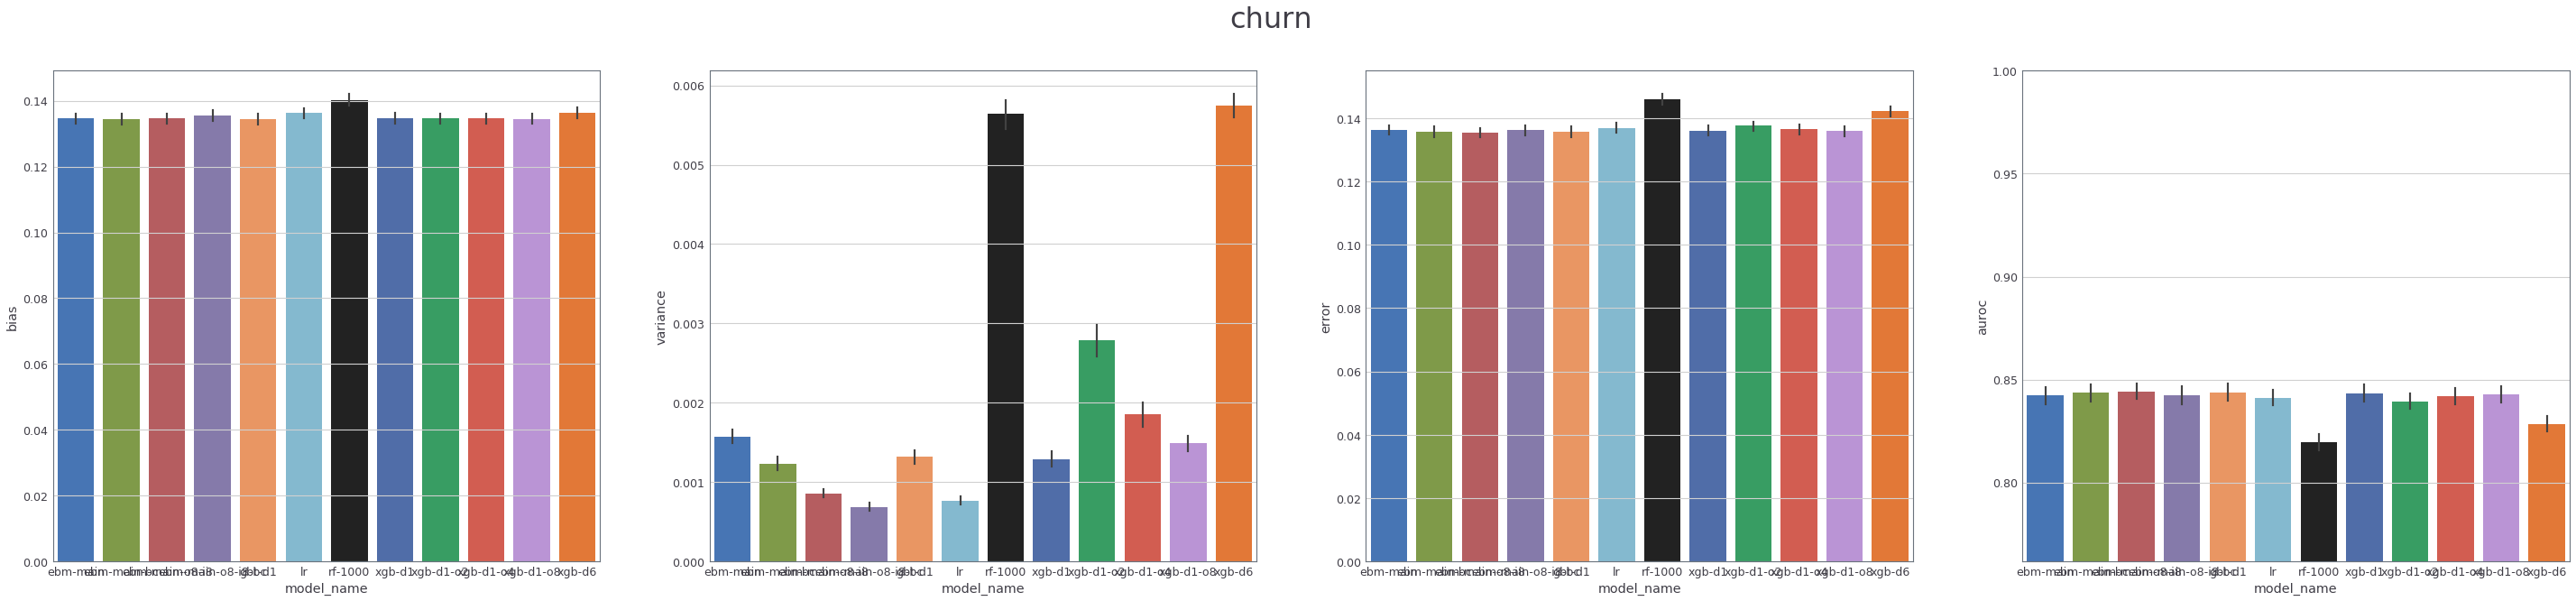

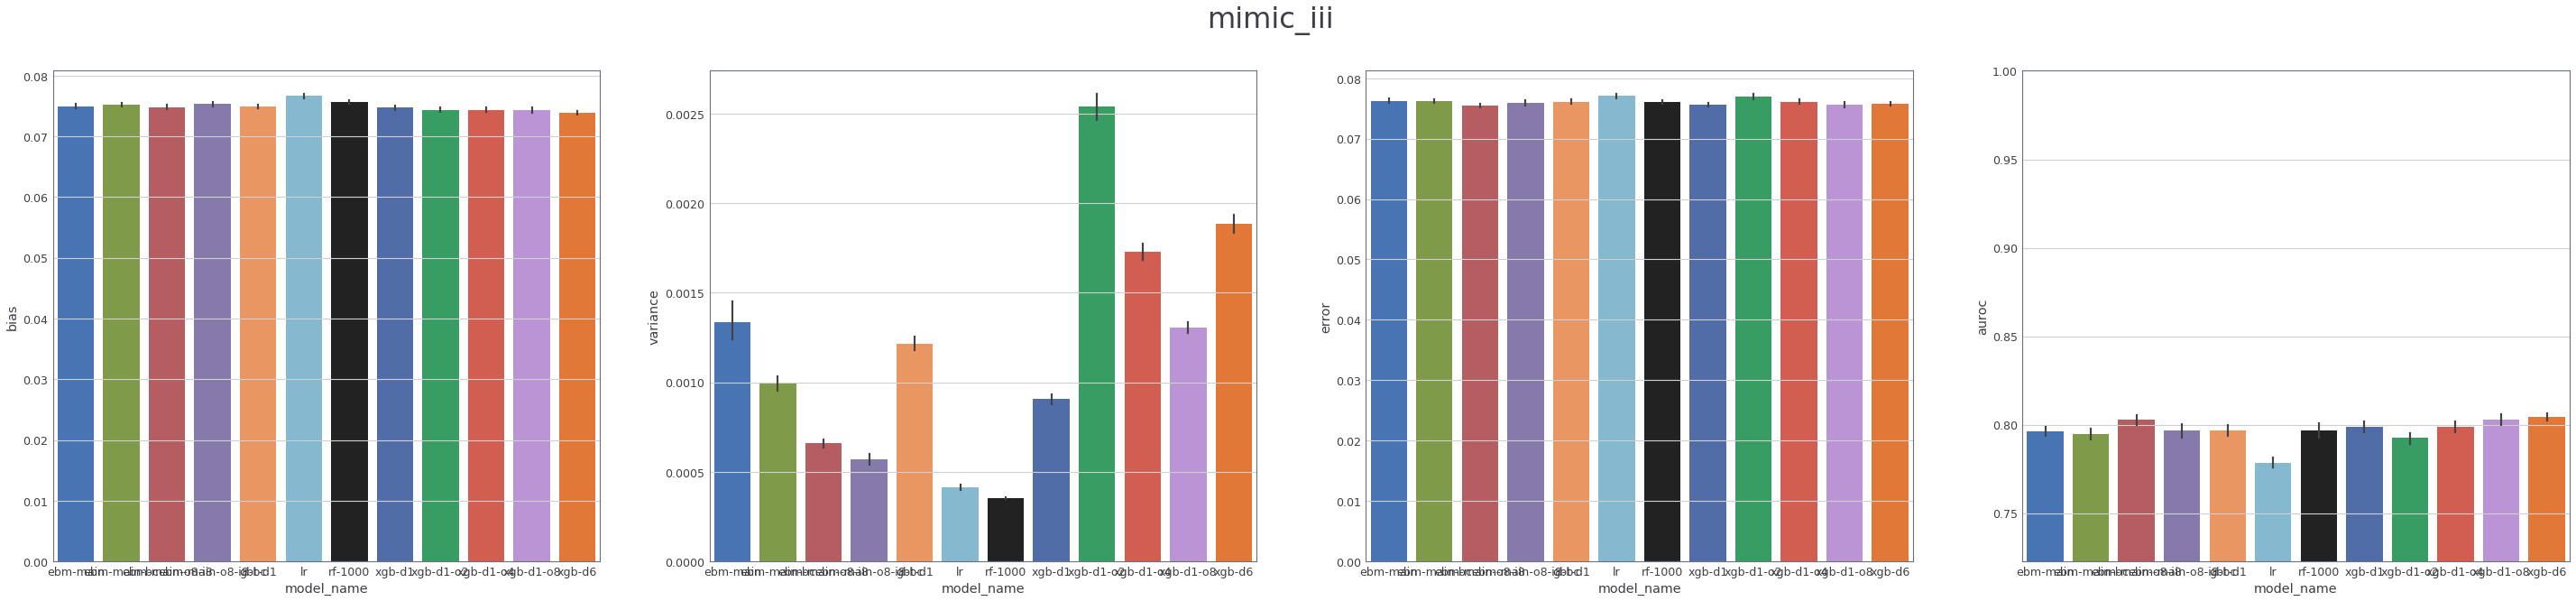

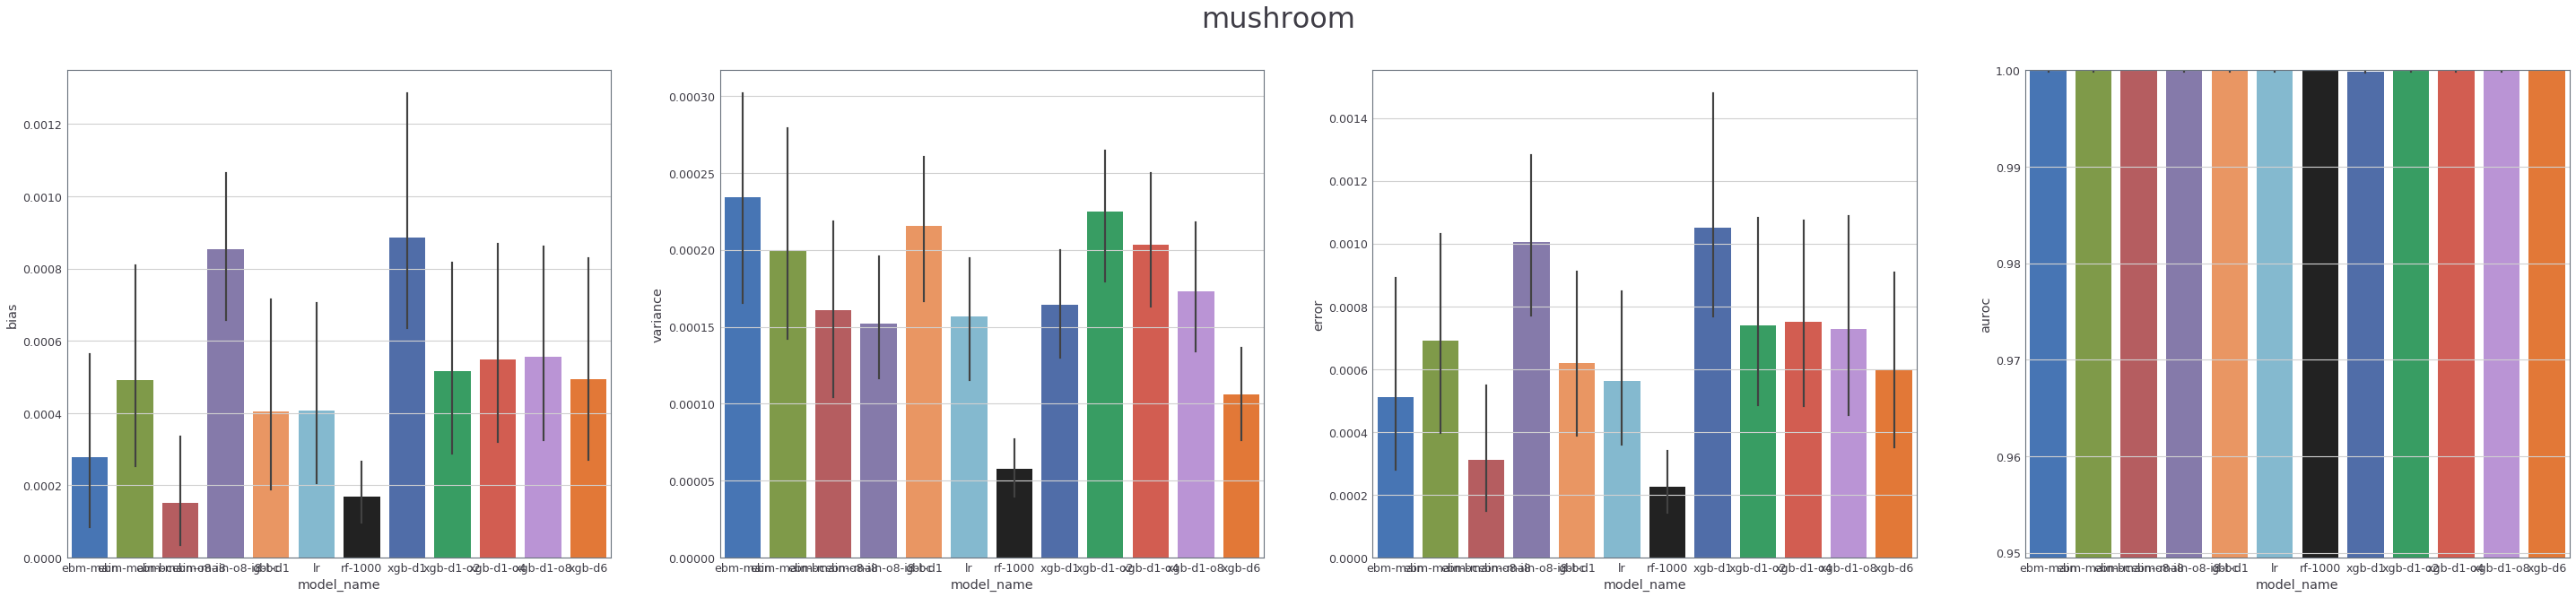

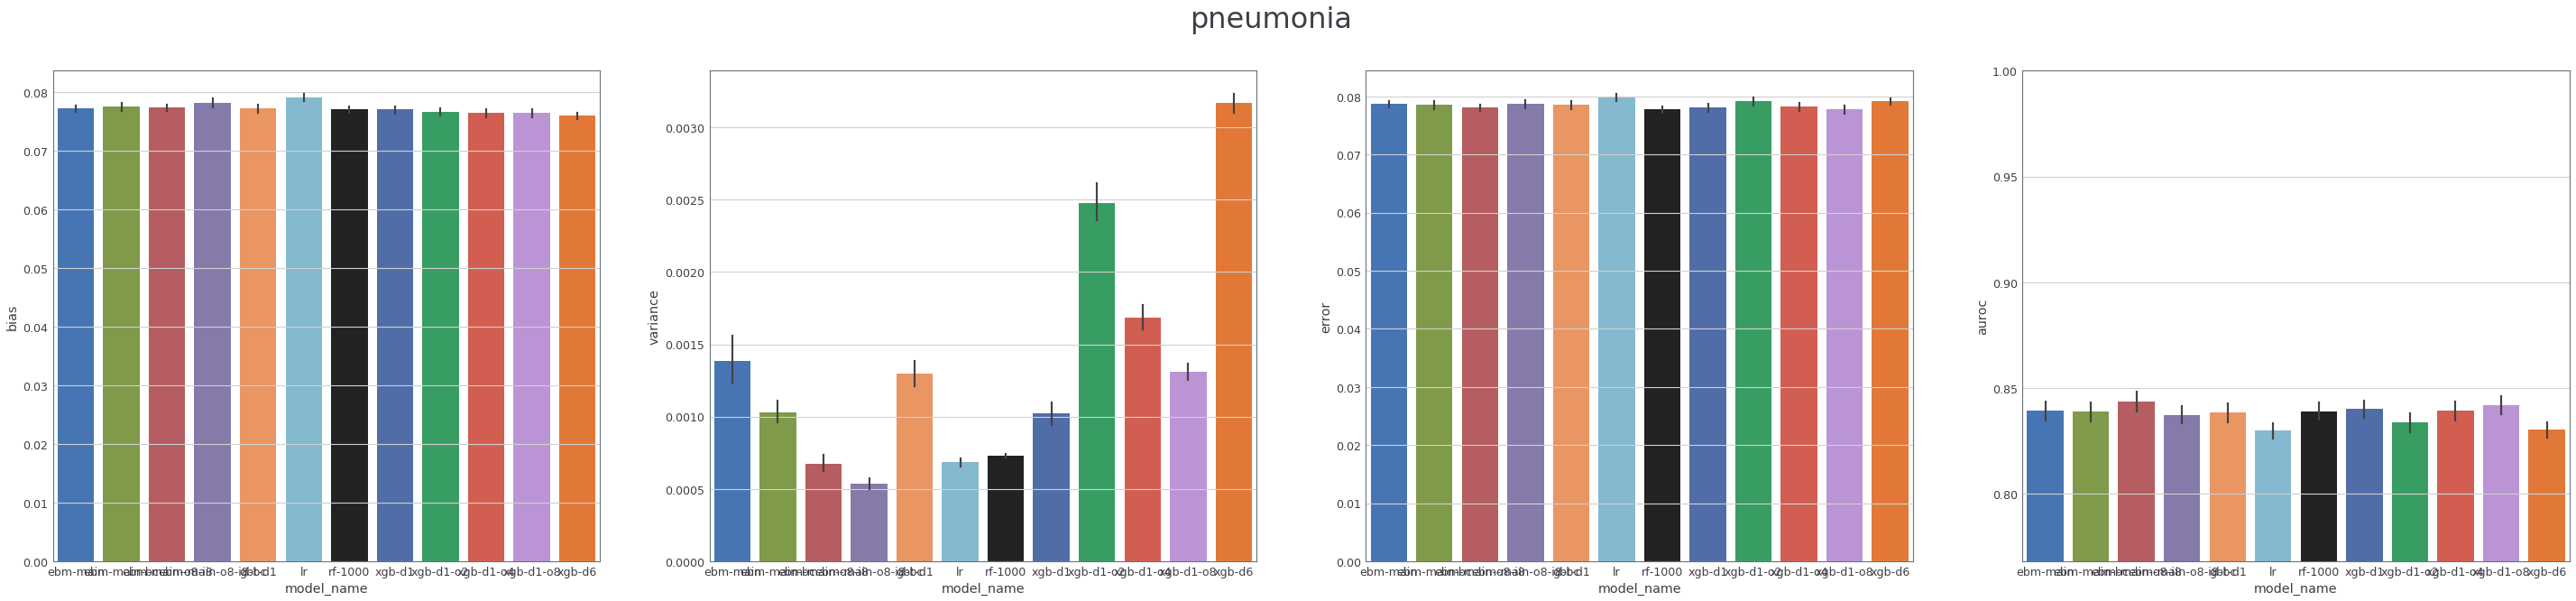

In [120]:
order = None
# order = ['dt', 'bagging-10', 'bagging-25', 'bagging-100']
# order = ['rf-10', 'rf-50', 'rf-200', 'rf-500', 'rf-1000']
# order = ['lr', 'bagging-100', 'rf-1000', 'xgb-d1', 'xgb-d3', 'ebm-main', 'ebm-pair']


for name, group in summary_df.groupby('d_name'):
    fig, axes = plt.subplots(1, 4, figsize=(50, 10))
    
    sns.barplot(data=group, x='model_name', y='bias', ax=axes[0], order=order)    
    sns.barplot(data=group, x='model_name', y='variance', ax=axes[1], order=order)
    
#     second_highest = np.mean(group.variance.values)
#     axes[1].set_ylim(0., second_highest + 0.6 * second_highest)
    
    sns.barplot(data=group, x='model_name', y='error', ax=axes[2], order=order)
    sns.barplot(data=group, x='model_name', y='auroc', ax=axes[3], order=order)
    axes[3].set_ylim(group.auroc.min() - 0.05, 1.)

    fig.suptitle(name, fontsize=32)


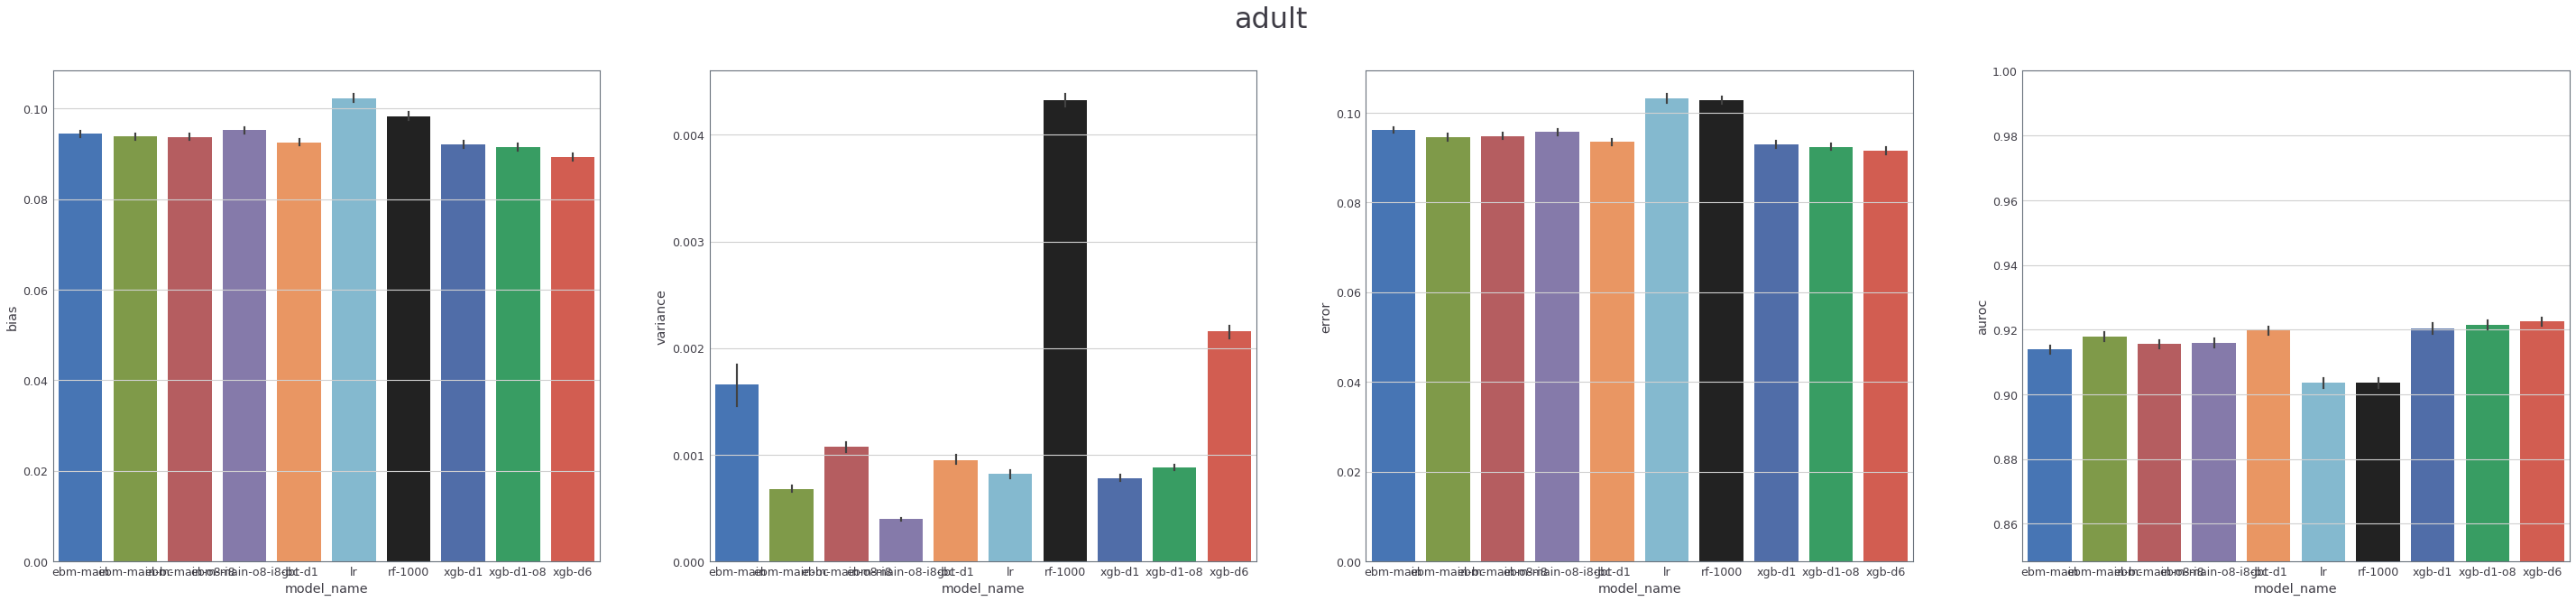

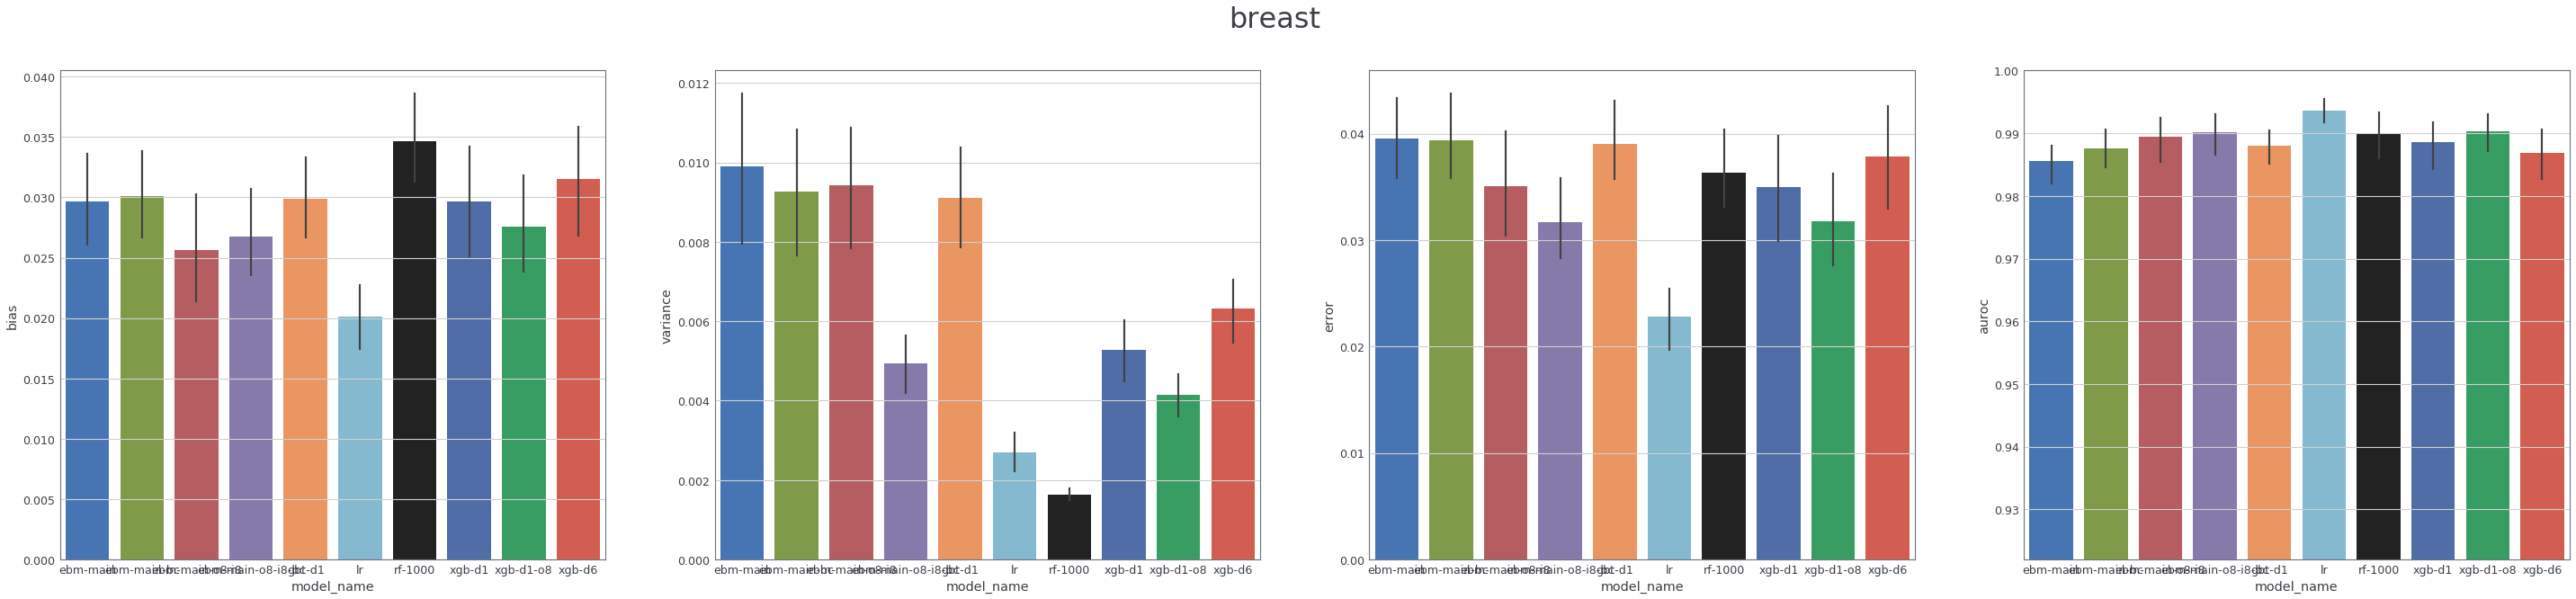

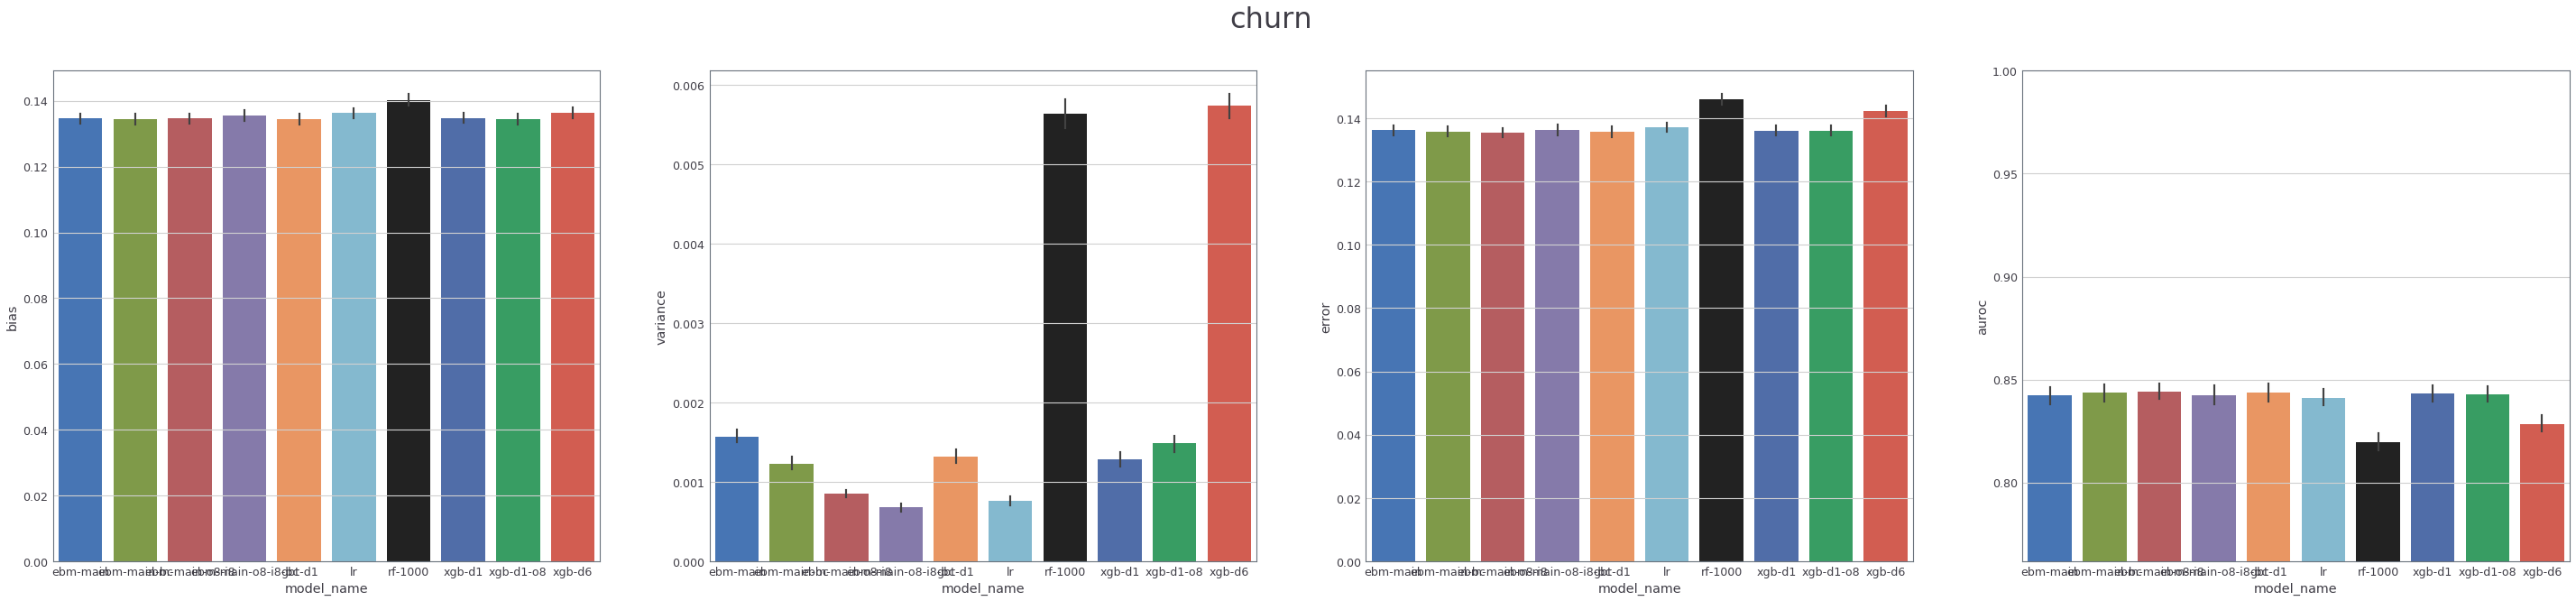

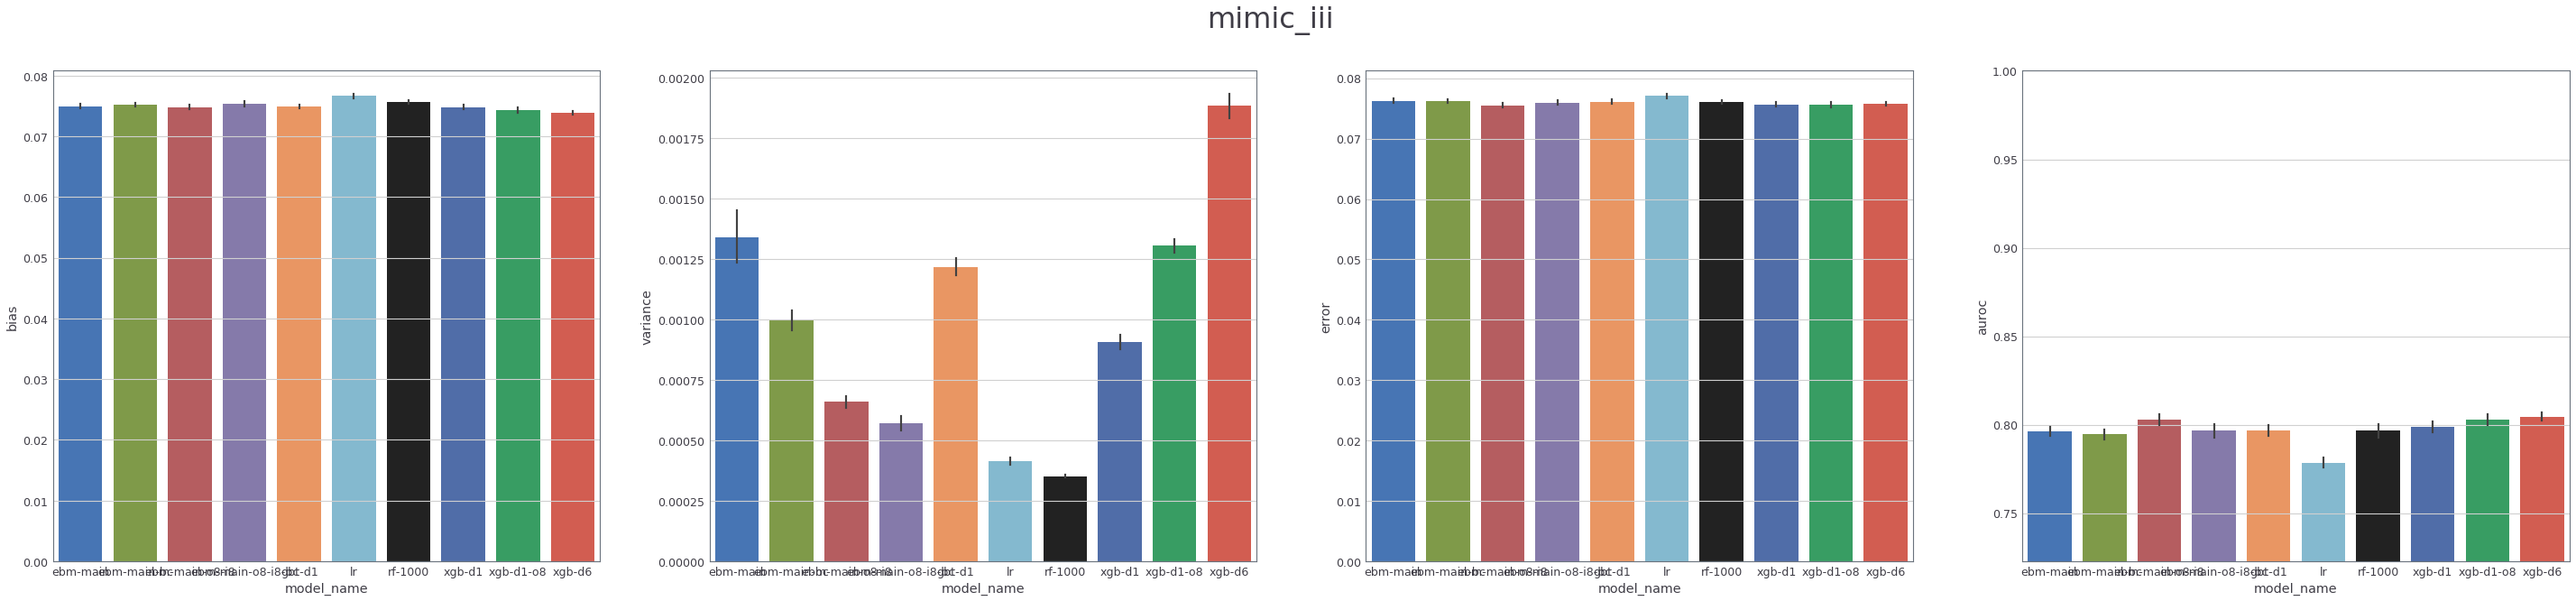

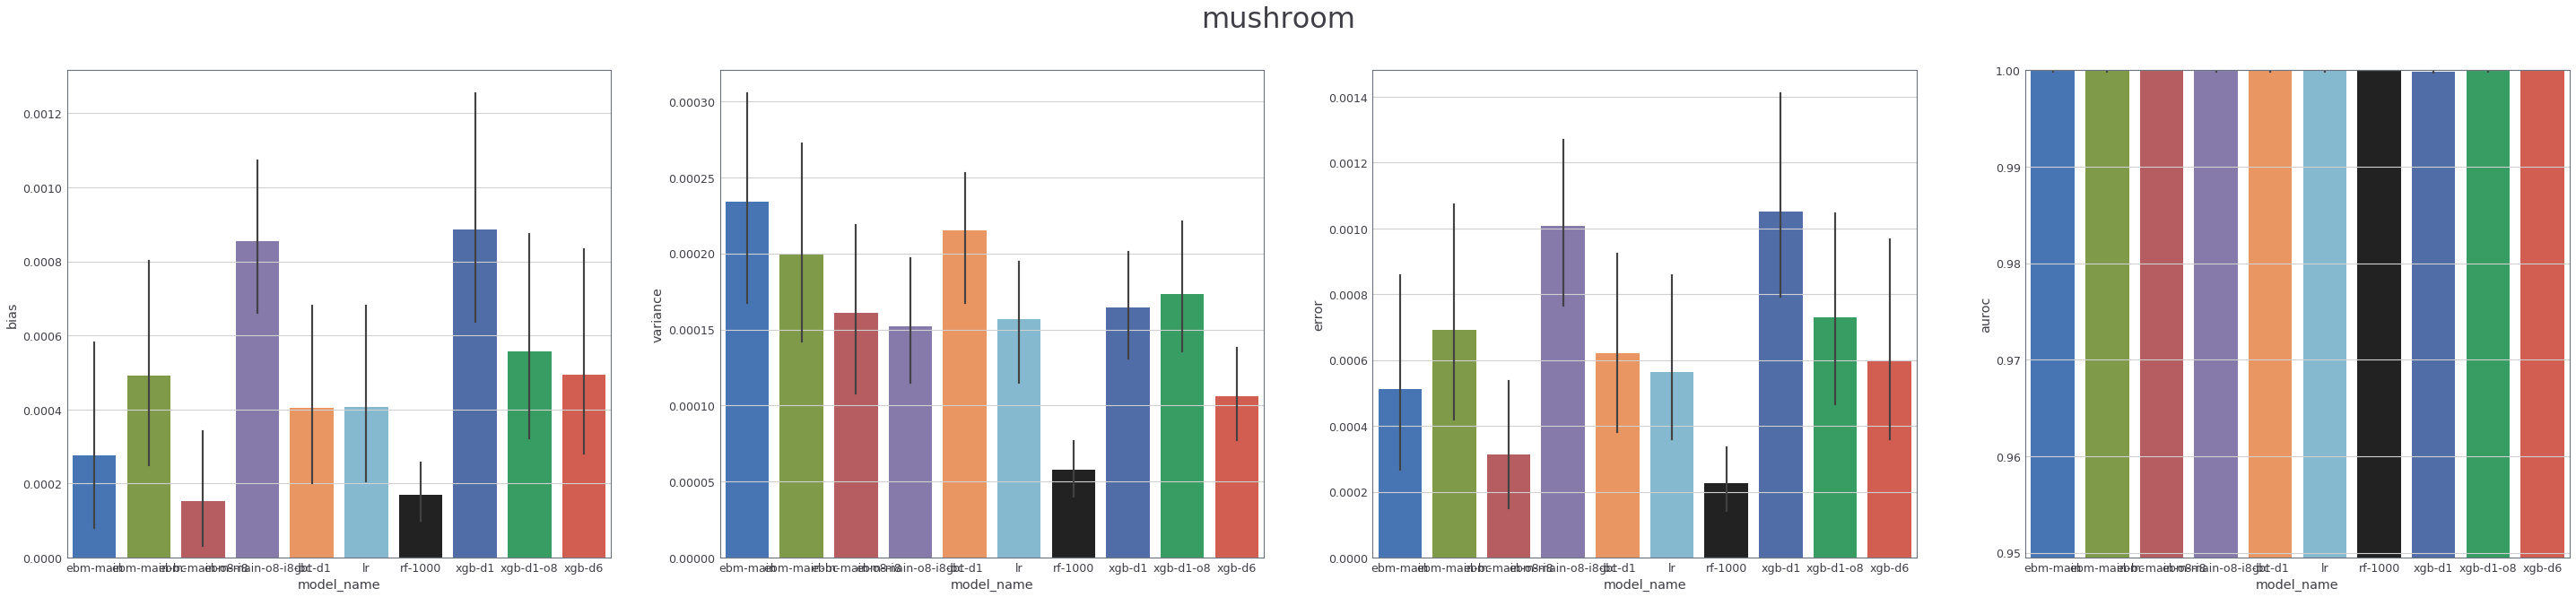

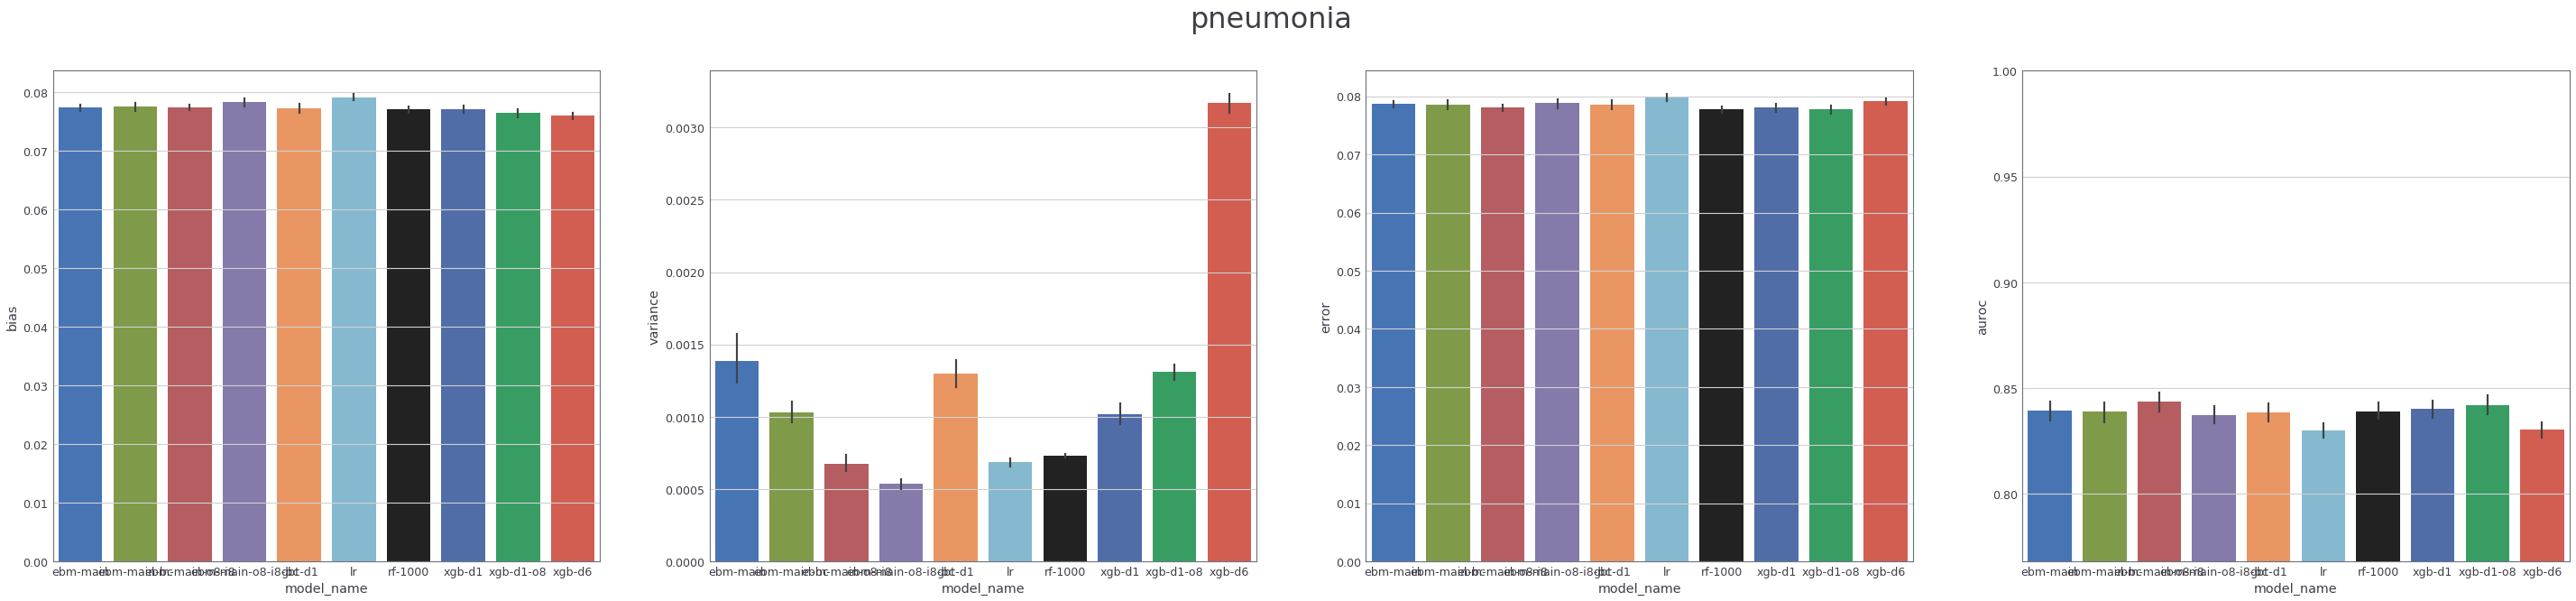

In [104]:
order = None
# order = ['dt', 'bagging-10', 'bagging-25', 'bagging-100']
# order = ['rf-10', 'rf-50', 'rf-200', 'rf-500', 'rf-1000']
# order = ['lr', 'bagging-100', 'rf-1000', 'xgb-d1', 'xgb-d3', 'ebm-main', 'ebm-pair']


for name, group in summary_df.groupby('d_name'):
    fig, axes = plt.subplots(1, 4, figsize=(50, 10))
    
    sns.barplot(data=group, x='model_name', y='bias', ax=axes[0], order=order)    
    sns.barplot(data=group, x='model_name', y='variance', ax=axes[1], order=order)
    
#     second_highest = np.mean(group.variance.values)
#     axes[1].set_ylim(0., second_highest + 0.6 * second_highest)
    
    sns.barplot(data=group, x='model_name', y='error', ax=axes[2], order=order)
    sns.barplot(data=group, x='model_name', y='auroc', ax=axes[3], order=order)
    axes[3].set_ylim(group.auroc.min() - 0.05, 1.)

    fig.suptitle(name, fontsize=32)


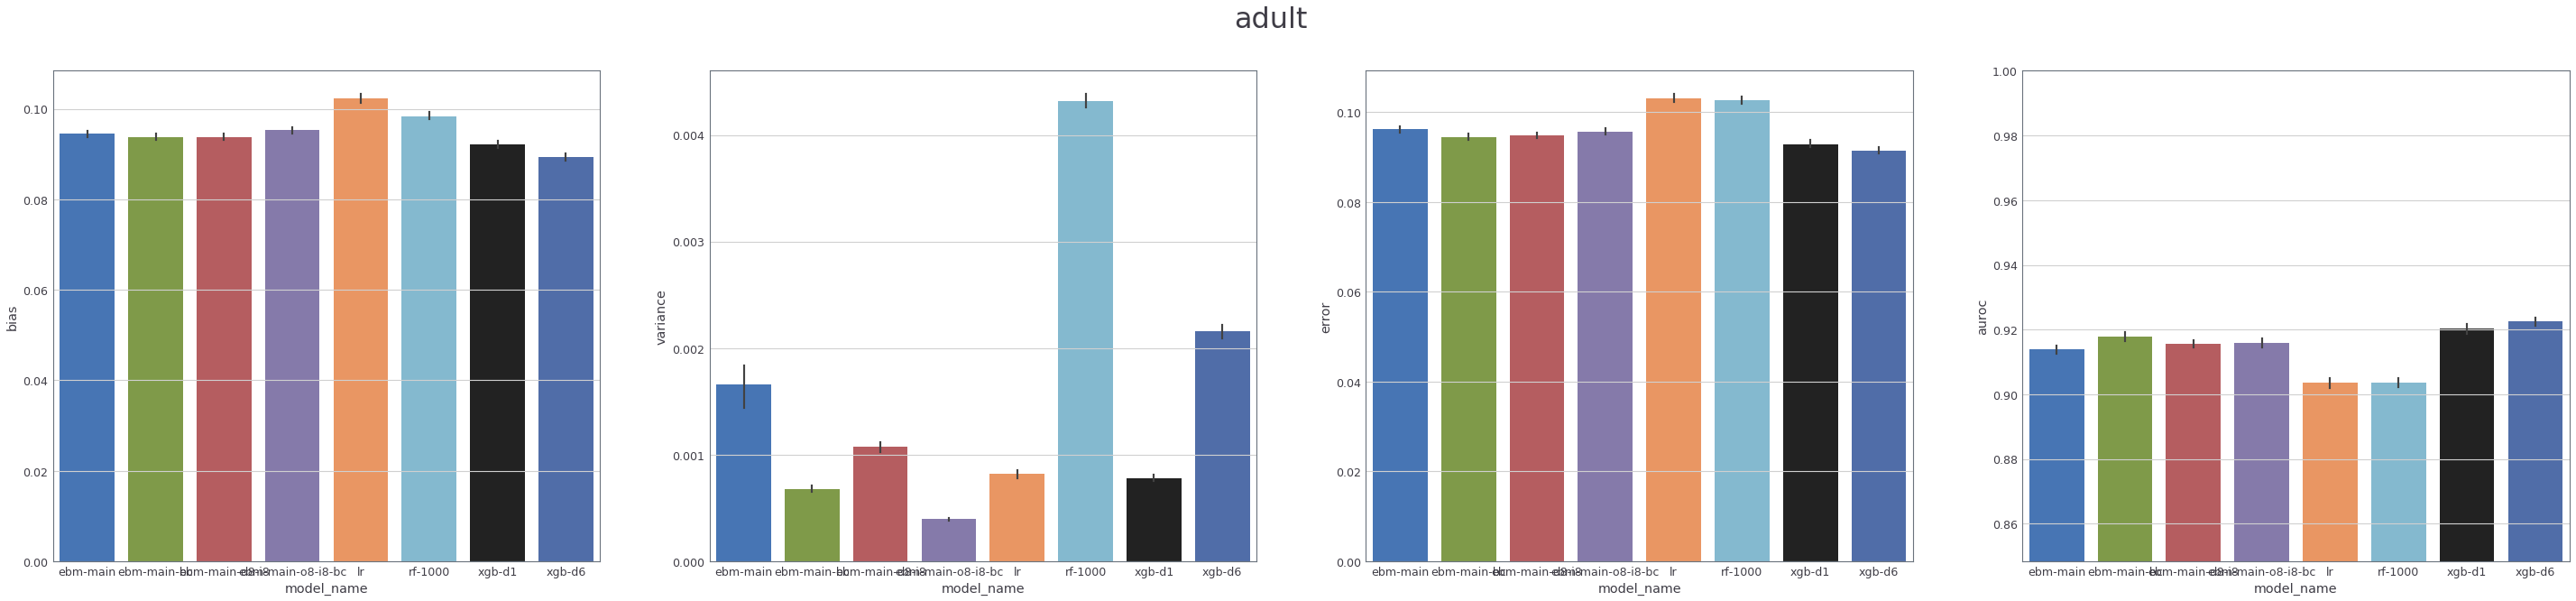

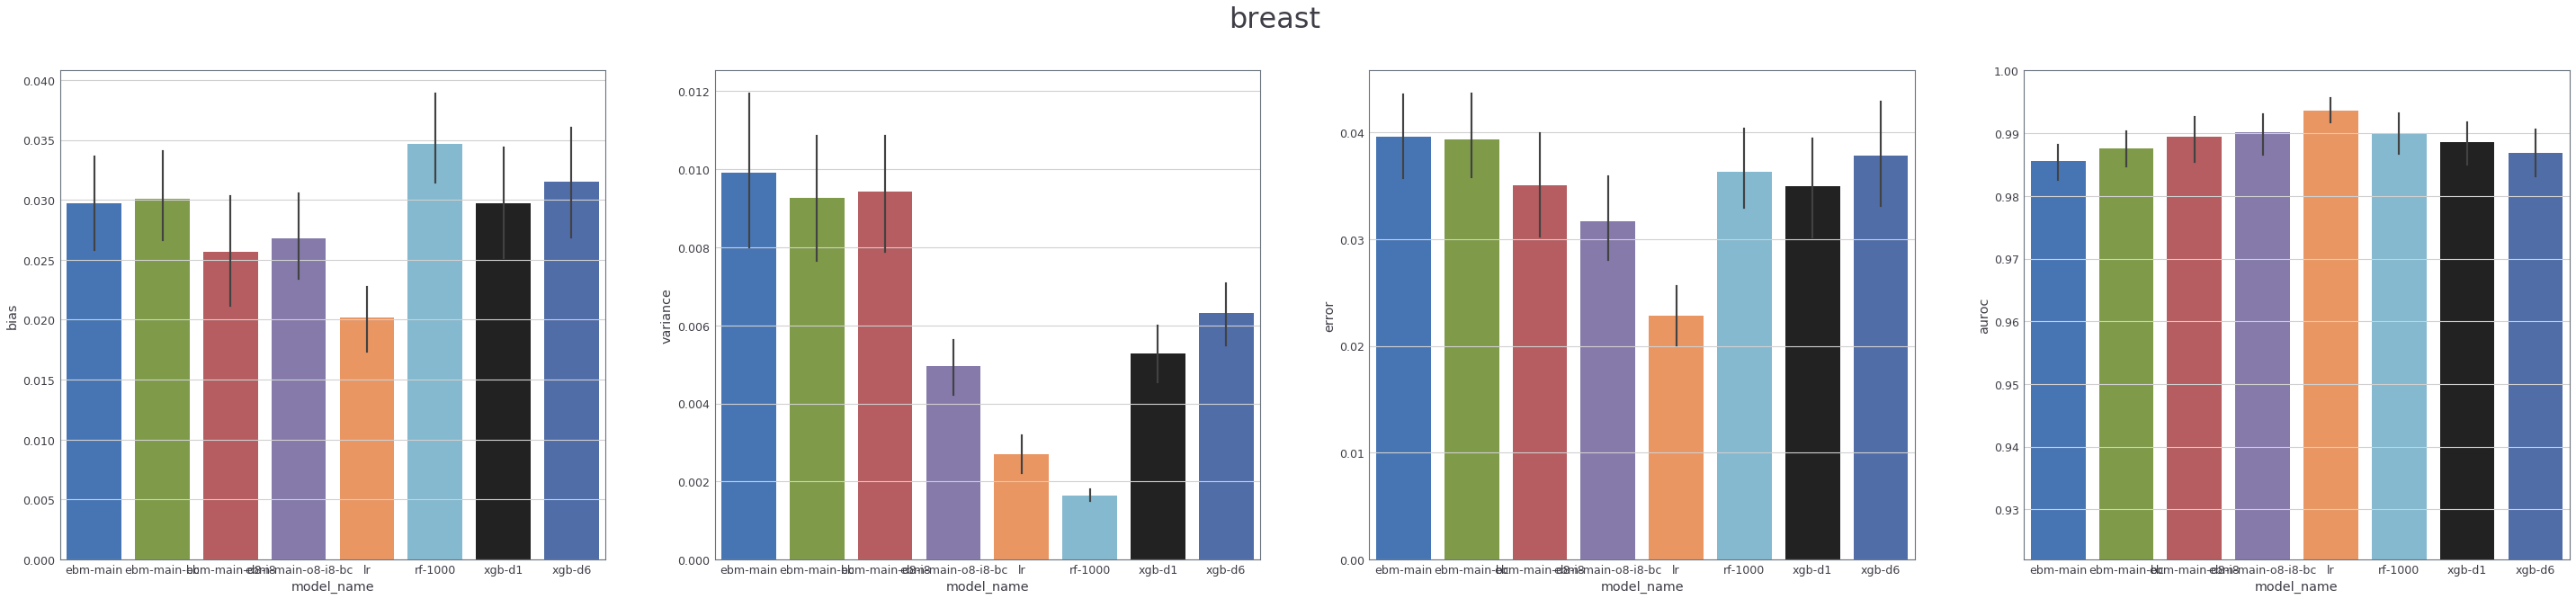

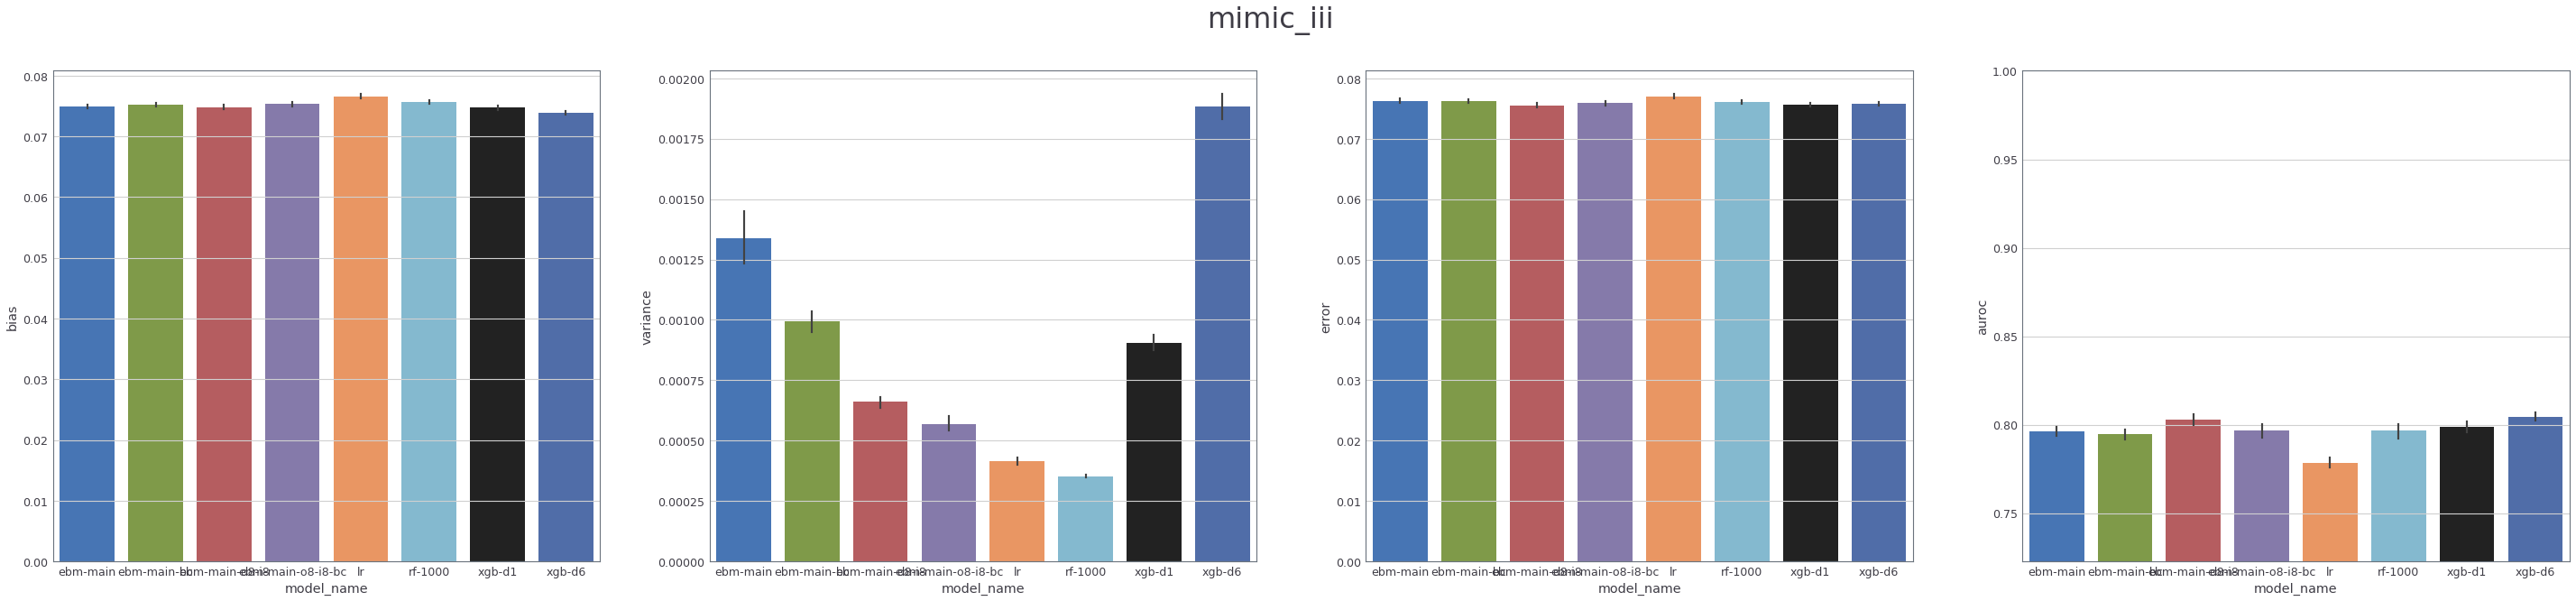

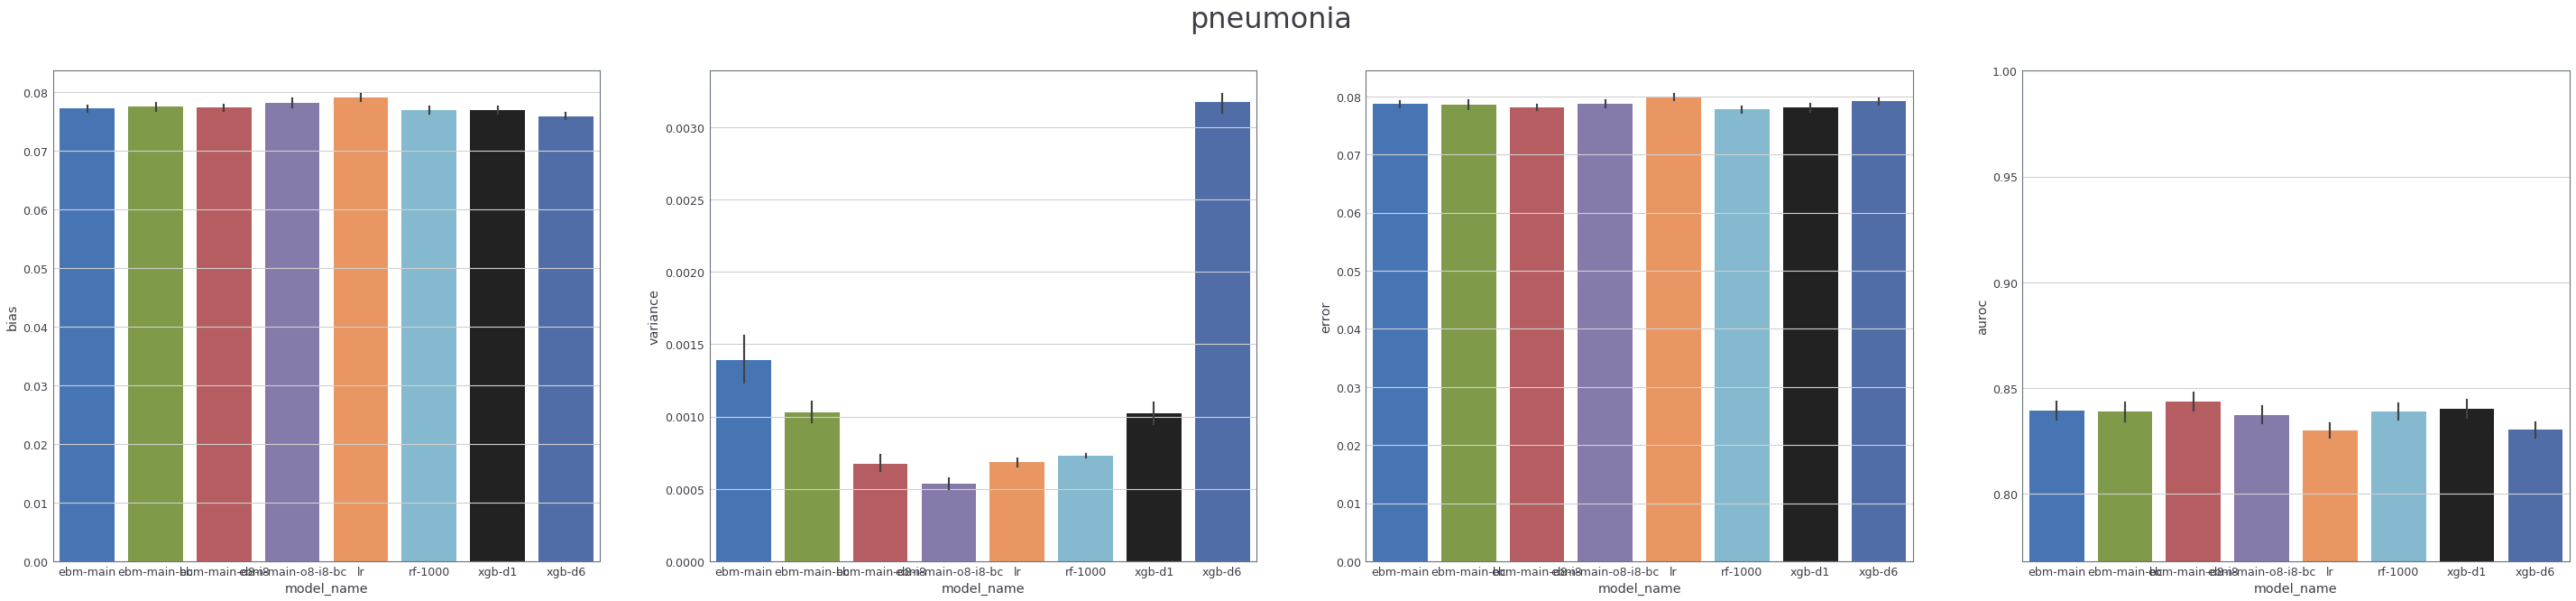

In [22]:
order = None
# order = ['dt', 'bagging-10', 'bagging-25', 'bagging-100']
# order = ['rf-10', 'rf-50', 'rf-200', 'rf-500', 'rf-1000']
# order = ['lr', 'bagging-100', 'rf-1000', 'xgb-d1', 'xgb-d3', 'ebm-main', 'ebm-pair']


for name, group in summary_df.groupby('d_name'):
    fig, axes = plt.subplots(1, 4, figsize=(50, 10))
    
    sns.barplot(data=group, x='model_name', y='bias', ax=axes[0], order=order)    
    sns.barplot(data=group, x='model_name', y='variance', ax=axes[1], order=order)
    
#     second_highest = np.mean(group.variance.values)
#     axes[1].set_ylim(0., second_highest + 0.6 * second_highest)
    
    sns.barplot(data=group, x='model_name', y='error', ax=axes[2], order=order)
    sns.barplot(data=group, x='model_name', y='auroc', ax=axes[3], order=order)
    axes[3].set_ylim(group.auroc.min() - 0.05, 1.)

    fig.suptitle(name, fontsize=32)


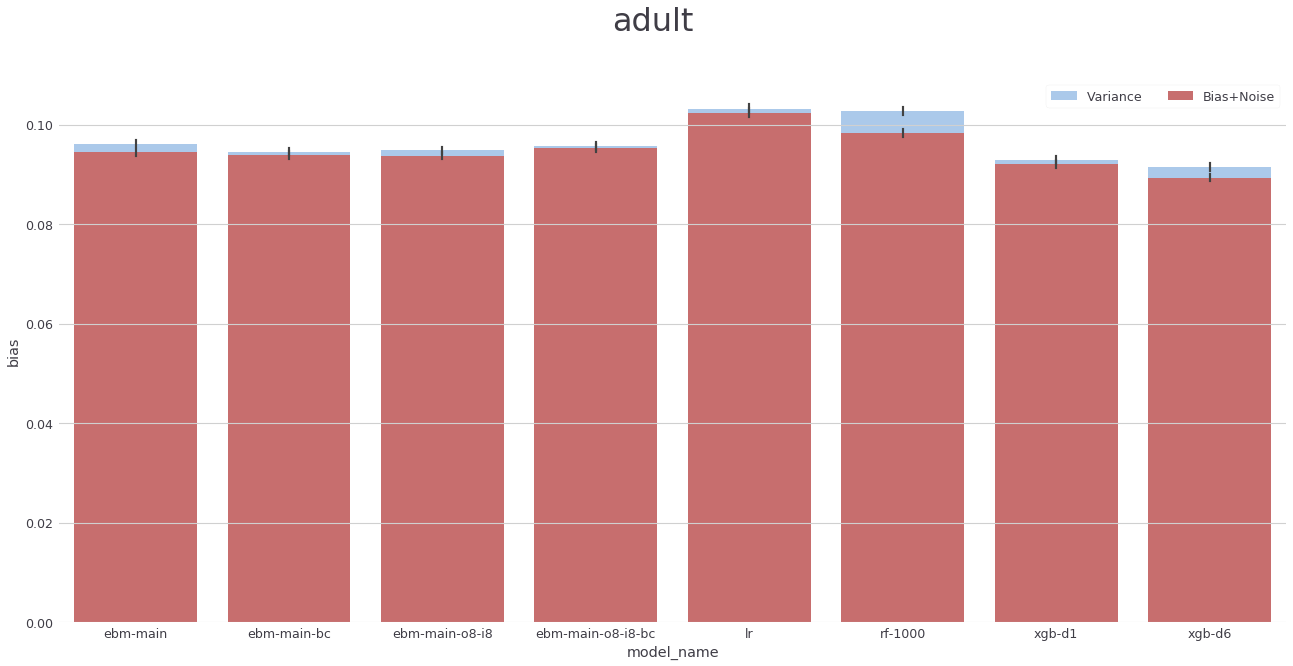

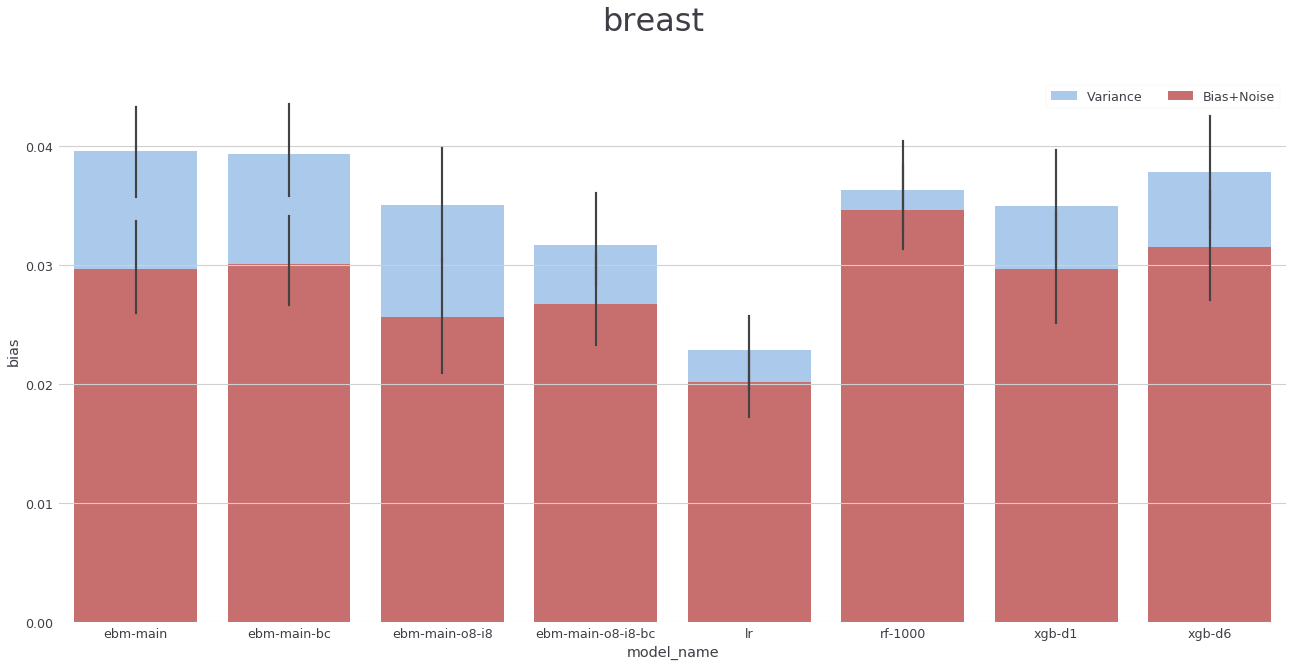

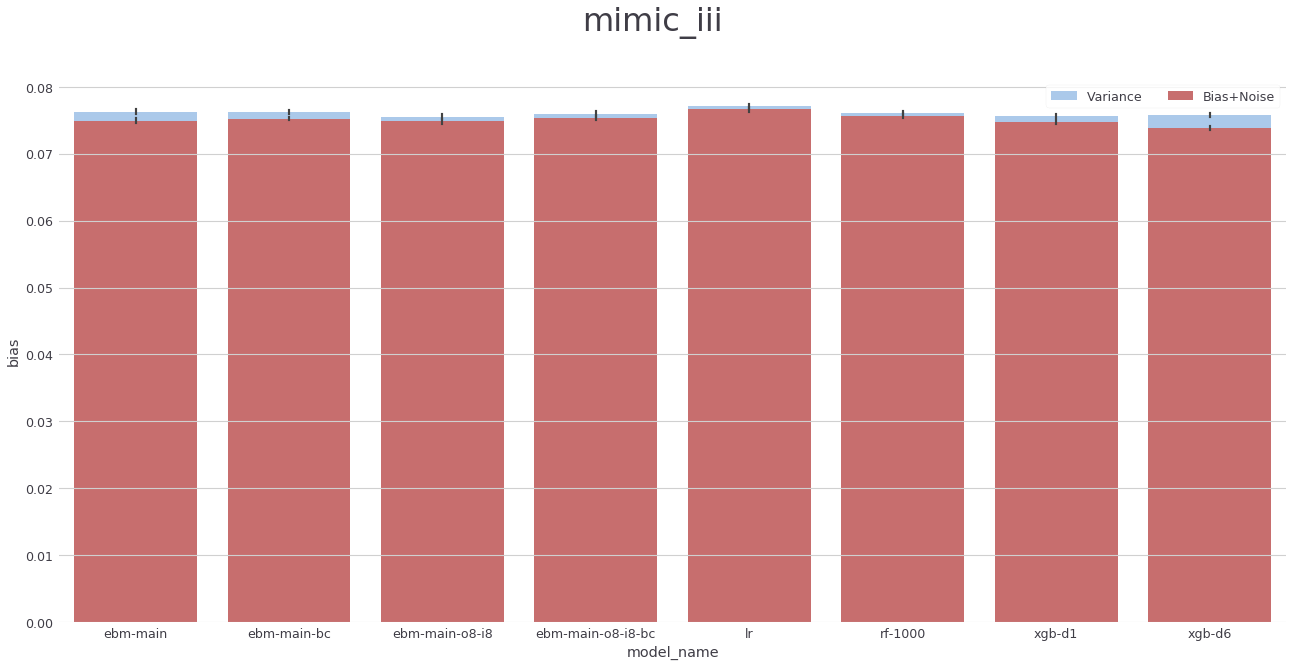

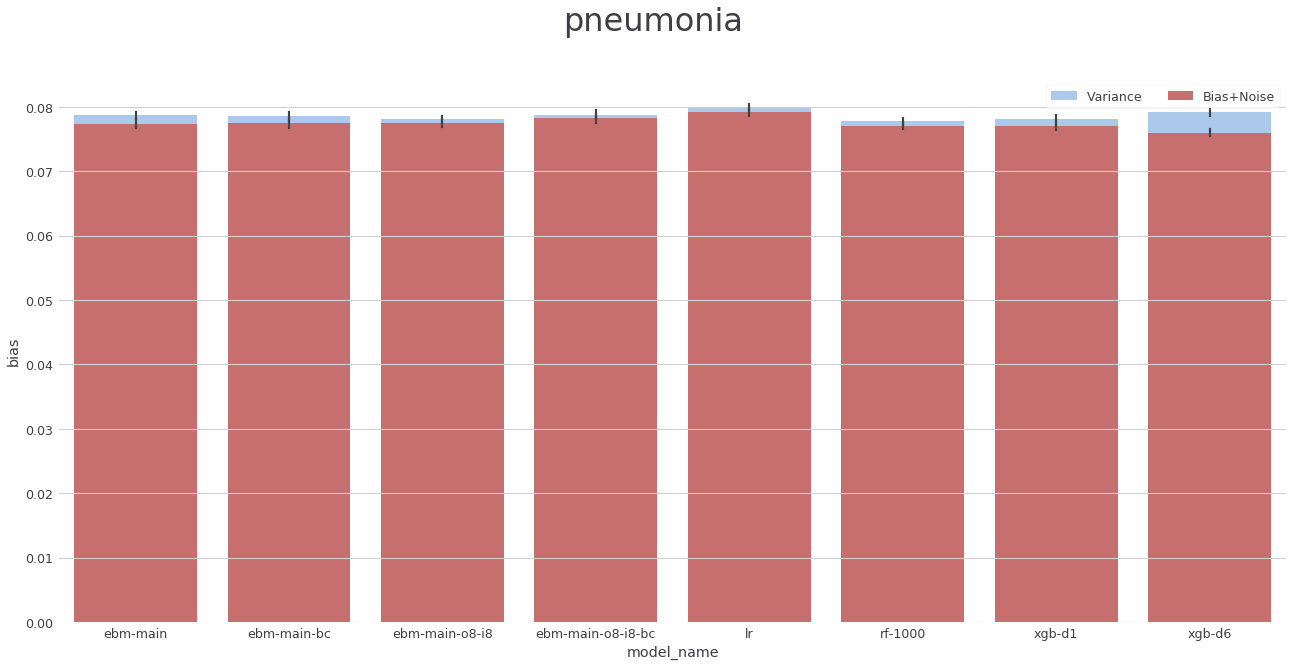

In [23]:
order = None
# order = ['dt', 'bagging-10', 'bagging-25', 'bagging-100']
# order = ['rf-10', 'rf-50', 'rf-200', 'rf-500', 'rf-1000']
# order = ['lr', 'dt', 'bagging-100', 'rf-10', 'rf-1000', 'xgb-d1', 'xgb-d2', 'xgb-d3', 'ebm-main', 'ebm-pair']
# order = ['lr', 'dt', 'bagging-100', 'rf-1000-d5', 'rf-1000-d10', 'rf-1000', 'xgb-d3', 'ebm-main', 'ebm-pair']


for name, group in summary_df.groupby('d_name'):
    fig, ax = plt.subplots(figsize=(22, 10))

    sns.set_color_codes("pastel")
    sns.barplot(x="model_name", y="error", data=group,
                label="Variance", color="b", order=order)

    sns.set_color_codes("muted")
    sns.barplot(x="model_name", y="bias", data=group,
                label="Bias+Noise", color="r", order=order)

    ax.legend(ncol=2, loc="best", frameon=True)

    sns.despine(left=True, bottom=True)

    fig.suptitle(name, fontsize=32)

# OLDDDDDD

In [ ]:
order = ['dt', 'bagging-10', 'bagging-25', 'bagging-100']
# order = ['rf-10', 'rf-50', 'rf-200', 'rf-500', 'rf-1000']
# order = ['dt', 'lr', 'rf-50', 'rf-1000', 'xgb-d1', 'xgb-d2', 'xgb-d3', 'ebm-main']

for name, group in summary_df.groupby('dataset_name'):
    fig, axes = plt.subplots(1, 4, figsize=(40, 10))
    
    sns.barplot(data=group, x='model_name', y='bias', ax=axes[0], order=order)    
    sns.barplot(data=group, x='model_name', y='variance', ax=axes[1], order=order)    
    sns.barplot(data=group, x='model_name', y='error', ax=axes[2], order=order)
    sns.barplot(data=group, x='model_name', y='auroc', ax=axes[3], order=order)
    axes[3].set_ylim(group.auroc.mean() - 0.1, 1.)

    fig.suptitle(name, fontsize=32)
